# `Setup`

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict
import operator

## Load Traffic Matrices (X) in kbps and Routing Matrix (A)

In [2]:
A = np.loadtxt('A', dtype=np.float32)
# in kbps
X = np.loadtxt('X', dtype=np.float32).reshape((-1,12,12))
print('We have in total {} traffic matrices of size {}x{}\n'.format(X.shape[0], X.shape[1], X.shape[2]))

We have in total 48384 traffic matrices of size 12x12



## Define train and test sets

In [3]:
# training is executed for 13 weeks 
train_size = 13*24*7*12 
# testing is executed for 1 week
test_size = 1*24*7*12

# in Mbps/100
X = X[:(train_size+test_size)] / 100000
print('For training and testing, we will use {} and {} traffic matrices respectively'.format(train_size, test_size))

# expand dimensions of each TM from (12,12) to (12,12,1)
X_train = np.expand_dims(X[:train_size], -1)
X_test = np.expand_dims(X[train_size:(train_size+test_size)], -1)

For training and testing, we will use 26208 and 2016 traffic matrices respectively


# `Architecture`

## Create a sampling layer

In [4]:
class Sampling(tf.keras.layers.Layer):
    ''' 
    (1) Sampling Layer is a subclass of tf.keras.layers.Layer
    (2) Reparameterization trick: use z_mean and z_log_var to sample z
    '''
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.math.exp(0.5*z_log_var) * epsilon

## Latent space dimensions

In [5]:
latent_dim = 10

## Build the encoder

In [6]:
encoder_inputs = tf.keras.Input(shape=(12, 12, 1))
x = tf.keras.layers.Dropout(0.25)(encoder_inputs)
x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 12, 1)]  0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 12, 12, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 6, 6, 32)     320         dropout[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 3, 64)     18496       conv2d[0][0]                     
____________________________________________________________________________________________

## Build the decoder

In [7]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(64, activation="relu")(latent_inputs)
x = tf.keras.layers.Dense(3 * 3 * 64, activation="relu")(x)
x = tf.keras.layers.Reshape((3, 3, 64))(x)
x = tf.keras.layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(64,  3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(32,  3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="relu", padding="same")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 576)               37440     
_________________________________________________________________
reshape (Reshape)            (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 3, 3, 128)         73856     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 6, 6, 64)          73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 12, 12, 32)        1846

## Define the VAE

In [8]:
class VAE(tf.keras.Model):
    '''
    Our VAE is a subclass of tf.keras.Model
    '''
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        '''
        Model calls automatically reset_states() on any object listed here, 
        at the beginning of each fit() epoch or at the begining of a call to evaluate().
        In this way, calling result() would return per-epoch average and not an average 
        since the start of training.
        '''
        return [self.total_loss_tracker]

    
    def train_step(self, x_true):
        ''' 
        (1) Override train_step(self, x_true) to customize what fit() does.
        (2) We use GradientTape() in order to record operations for automatic differentiation.
        '''
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x_true)
            x_pred = self.decoder(z)
            # reconstruction loss: mean squared error
            reconstruction_loss = tf.reduce_sum(tf.keras.losses.mean_squared_error(x_true, x_pred), axis=(1, 2))
            # regularization term: KL divergence
            kl_loss = tf.reduce_sum(-0.5 * (1 + z_log_var - tf.math.square(z_mean) - tf.math.exp(z_log_var)), axis=1)
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)       
        # self.trainable_variables and self.optimizer are inherited from tf.keras.Model
        # Get gradients of total loss with respect to the weights.
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Update the weights of the model.
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {
            "loss": self.total_loss_tracker.result()
        }


## Custom Early Stopping

In [9]:
# source: https://keras.io/guides/writing_your_own_callbacks/

class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    '''
    Stop training when the loss is at its min, i.e. the loss stops decreasing.

    Arguments:
        patience: Number of epochs to wait after min has been hit. 
                  After this number of no improvement, training stops.
    '''

    def __init__(self, patience=30):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("\n Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

# `Training`

Epoch 1/1000
205/205 [==============================] - 4s 19ms/step - loss: 78.9105
Epoch 2/1000
205/205 [==============================] - 4s 20ms/step - loss: 14.5201
Epoch 3/1000
205/205 [==============================] - 4s 18ms/step - loss: 11.7496
Epoch 4/1000
205/205 [==============================] - 4s 19ms/step - loss: 11.2344
Epoch 5/1000
205/205 [==============================] - 4s 18ms/step - loss: 10.0942
Epoch 6/1000
205/205 [==============================] - 4s 19ms/step - loss: 9.2670
Epoch 7/1000
205/205 [==============================] - 4s 18ms/step - loss: 9.0013
Epoch 8/1000
205/205 [==============================] - 4s 18ms/step - loss: 9.2513
Epoch 9/1000
205/205 [==============================] - 4s 18ms/step - loss: 10.0538
Epoch 10/1000
205/205 [==============================] - 4s 18ms/step - loss: 8.4731
Epoch 11/1000
205/205 [==============================] - 4s 18ms/step - loss: 8.3357
Epoch 12/1000
205/205 [==============================] - 4s 18ms/ste

205/205 [==============================] - 4s 17ms/step - loss: 6.2014
Epoch 193/1000
205/205 [==============================] - 4s 17ms/step - loss: 6.2053
Epoch 194/1000
205/205 [==============================] - 4s 17ms/step - loss: 6.1636
Epoch 195/1000
205/205 [==============================] - 4s 17ms/step - loss: 6.3056
Epoch 196/1000
205/205 [==============================] - 4s 17ms/step - loss: 6.1981
Epoch 197/1000
205/205 [==============================] - 4s 17ms/step - loss: 6.4358
Epoch 198/1000
205/205 [==============================] - 4s 17ms/step - loss: 6.2277
Epoch 199/1000
205/205 [==============================] - 4s 17ms/step - loss: 6.0828
Epoch 200/1000
205/205 [==============================] - 4s 17ms/step - loss: 6.2140
Epoch 201/1000
205/205 [==============================] - 4s 17ms/step - loss: 6.1331
Epoch 202/1000
205/205 [==============================] - 4s 17ms/step - loss: 6.1778
Epoch 203/1000
205/205 [==============================] - 4s 17ms/ste

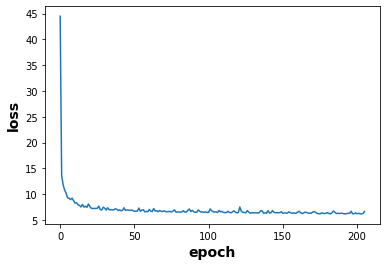

In [10]:
model = VAE(encoder, decoder)
model.compile(optimizer=tf.keras.optimizers.Adam())
history = model.fit(X_train, epochs=1000, batch_size=128, callbacks=[EarlyStoppingAtMinLoss()],)
plt.plot(history.history['loss'])
plt.ylabel('loss', fontsize=14, fontweight='bold')
plt.xlabel('epoch', fontsize=14, fontweight='bold')
plt.show()

# `Testing`

## Define variables and optimizer

In [11]:
A_var = tf.Variable(A, dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam()

## Find link counts (y) for traffic matrices (X) of training set

In [12]:
# X_test has shape [test_size, 12, 12, 1]
y_test = np.array([np.dot(A, X_test[i,:,:,0].reshape(144,1)) for i in range(X_test.shape[0])])

## Useful functions

In [13]:
def TRE(truth_seq, est_seq):
    # truth_seq and est_seq are test_sizex12x12 arrays
    res = [0] * truth_seq.shape[0]
    for i in range(truth_seq.shape[0]):
        res[i] = np.linalg.norm(est_seq[i]-truth_seq[i]) / np.linalg.norm(truth_seq[i])
    return res



def SRE(truth_seq, est_seq):
    # truth_seq and est_seq are test_sizex12x12 arrays
    w, k, l = truth_seq.shape
    true_flows = defaultdict(list) 
    est_flows = defaultdict(list)
    res = [0] * (k*l)
    for i in range(w):
        t = truth_seq[i].reshape(-1)
        e = est_seq[i].reshape(-1)
        for j in range(k*l):
            true_flows[j].append(t[j])
            est_flows[j].append(e[j])
    for i in range(k*l):
        if np.linalg.norm(true_flows[i]) == 0.0:
            if np.linalg.norm(est_flows[i]) == 0.0:
                res[i] = 0.0
            else:
                new_true_flows = [x+1e-7 for x in true_flows]
                res[i] = np.linalg.norm(list(map(operator.sub, new_true_flows[i], est_flows[i]))) / np.linalg.norm(new_true_flows[i])
        else:
            res[i] = np.linalg.norm(list(map(operator.sub, true_flows[i], est_flows[i]))) / np.linalg.norm(true_flows[i])
    return res



def RMSE(truth_seq, est_seq):
    res = [0] * truth_seq.shape[0]
    for i in range(truth_seq.shape[0]):
        res[i] = np.sqrt(np.mean(tf.keras.losses.mean_squared_error(truth_seq[i], est_seq[i])))
    return np.mean(res)



def NMAE(truth_seq, est_seq):
    # truth_seq and est_seq are test_sizex12x12 arrays
    res = [0] * truth_seq.shape[0]
    for i in range(truth_seq.shape[0]):
        res[i] = np.sum(np.abs(est_seq[i]-truth_seq[i])) / np.sum(np.abs(truth_seq[i]))
    return np.mean(res)


## Iterative optimization, starting from a "good" z, simple

In [14]:
max_optimization_iterations = 5000
max_initial_point_iterations = 3000
X_pred_2 = np.empty(shape=(test_size,12,12))


for i, y in enumerate(y_test):   
    z = tf.Variable(tf.random.normal(shape=(1,latent_dim), dtype=tf.float32))
    x_pred_start = model.decoder(z)[0,:,:,0]
    y_pred_start = tf.tensordot(A_var, tf.reshape(x_pred_start, (144,1)), 1)
    loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y, y_pred_start))
    for iteration in range(max_initial_point_iterations):
        z_new = tf.Variable(tf.random.normal(shape=(1,latent_dim), dtype=tf.float32))
        x_pred_new = model.decoder(z_new)[0,:,:,0]
        y_pred_new = tf.tensordot(A_var, tf.reshape(x_pred_new, (144,1)), 1)
        loss_new = tf.reduce_mean(tf.keras.losses.mean_squared_error(y, y_pred_new))
        if loss_new < loss:
            print('found new min loss of: {} in iteration {}'.format(loss_new, iteration))
            z = z_new
            loss = loss_new
    
    # initialize values
    minimum_rmse = np.Inf
    x_pred_best = None
    
    for iteration in range(max_optimization_iterations):
        with tf.GradientTape() as tape:
            # x_pred has shape [1 12 12 1] and we care only for [12 12]
            x_pred = model.decoder(z)[0,:,:,0]
            # find link counts (y_pred) that correspond to predicted TM (x_pred)
            y_pred = tf.tensordot(A_var, tf.reshape(x_pred, (144,1)), 1)
            # compute the loss between true link counts (y) and predicted link counts (y_pred)
            loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y, y_pred))
            # find the root mean square error between true TM (X_test) and predicted TM (x_pred)
            rmse = tf.math.sqrt(tf.reduce_mean(tf.keras.losses.mean_squared_error(100*X_test[i,:,:,0], 100*x_pred)))
            # keep TM with the smallest rmse
            if tf.math.less(rmse, minimum_rmse):
                x_pred_best = x_pred
                minimum_rmse = rmse
        # get gradient of loss with respect to z
        grads = tape.gradient(loss, z)
        # update the value of z
        optimizer.apply_gradients(zip([grads], [z]))
    
    print()
    print('minimum RMSE between X_test[{}] and x_pred_best: {} Mbps after {} iterations'.format(i, minimum_rmse, iteration+1))
    X_pred_2[i] = np.array(100*x_pred_best)

found new min loss of: 0.16729117929935455 in iteration 2
found new min loss of: 0.13214032351970673 in iteration 9
found new min loss of: 0.07297960668802261 in iteration 11
found new min loss of: 0.06903127580881119 in iteration 62
found new min loss of: 0.0589534267783165 in iteration 139
found new min loss of: 0.05556641146540642 in iteration 496

minimum RMSE between X_test[0] and x_pred_best: 7.836430549621582 Mbps after 5000 iterations
found new min loss of: 0.21712400019168854 in iteration 2
found new min loss of: 0.1797136813402176 in iteration 5
found new min loss of: 0.14077091217041016 in iteration 36
found new min loss of: 0.1388777792453766 in iteration 186
found new min loss of: 0.1384354531764984 in iteration 237
found new min loss of: 0.11887241899967194 in iteration 266
found new min loss of: 0.11551924049854279 in iteration 273
found new min loss of: 0.11259660124778748 in iteration 500
found new min loss of: 0.10758043825626373 in iteration 600
found new min loss of


minimum RMSE between X_test[15] and x_pred_best: 8.148710250854492 Mbps after 5000 iterations
found new min loss of: 0.23669078946113586 in iteration 5
found new min loss of: 0.1338653564453125 in iteration 6
found new min loss of: 0.09415662288665771 in iteration 444
found new min loss of: 0.08549999445676804 in iteration 632
found new min loss of: 0.06181016191840172 in iteration 671

minimum RMSE between X_test[16] and x_pred_best: 9.132232666015625 Mbps after 5000 iterations
found new min loss of: 0.08787955343723297 in iteration 1
found new min loss of: 0.07077883183956146 in iteration 3
found new min loss of: 0.07011011242866516 in iteration 26
found new min loss of: 0.06295035779476166 in iteration 27
found new min loss of: 0.05495217815041542 in iteration 132
found new min loss of: 0.04833999648690224 in iteration 134
found new min loss of: 0.046893272548913956 in iteration 2300
found new min loss of: 0.04359316825866699 in iteration 2302

minimum RMSE between X_test[17] and x

found new min loss of: 0.2828972637653351 in iteration 383
found new min loss of: 0.2797389626502991 in iteration 718
found new min loss of: 0.24431394040584564 in iteration 889

minimum RMSE between X_test[31] and x_pred_best: 30.447175979614258 Mbps after 5000 iterations
found new min loss of: 0.49281445145606995 in iteration 0
found new min loss of: 0.050504907965660095 in iteration 6
found new min loss of: 0.04386024922132492 in iteration 12
found new min loss of: 0.04229603335261345 in iteration 141
found new min loss of: 0.03422797471284866 in iteration 218
found new min loss of: 0.03308117762207985 in iteration 1328

minimum RMSE between X_test[32] and x_pred_best: 8.791516304016113 Mbps after 5000 iterations
found new min loss of: 1.547675371170044 in iteration 2
found new min loss of: 0.19917353987693787 in iteration 3
found new min loss of: 0.1915724277496338 in iteration 6
found new min loss of: 0.19005221128463745 in iteration 16
found new min loss of: 0.17852339148521423 i

found new min loss of: 0.1778572052717209 in iteration 1418

minimum RMSE between X_test[47] and x_pred_best: 17.87087631225586 Mbps after 5000 iterations
found new min loss of: 0.17584149539470673 in iteration 1
found new min loss of: 0.17144955694675446 in iteration 5
found new min loss of: 0.16132061183452606 in iteration 11
found new min loss of: 0.15526226162910461 in iteration 28
found new min loss of: 0.1480713039636612 in iteration 72
found new min loss of: 0.1472022384405136 in iteration 278
found new min loss of: 0.14503122866153717 in iteration 309
found new min loss of: 0.1404539793729782 in iteration 453
found new min loss of: 0.13895229995250702 in iteration 599
found new min loss of: 0.12427561730146408 in iteration 1965

minimum RMSE between X_test[48] and x_pred_best: 12.64499282836914 Mbps after 5000 iterations
found new min loss of: 0.5518487095832825 in iteration 0
found new min loss of: 0.5449507236480713 in iteration 8
found new min loss of: 0.5374155044555664 in 

found new min loss of: 0.13590313494205475 in iteration 376
found new min loss of: 0.13301794230937958 in iteration 1610

minimum RMSE between X_test[61] and x_pred_best: 21.592330932617188 Mbps after 5000 iterations
found new min loss of: 0.26514944434165955 in iteration 2
found new min loss of: 0.23389890789985657 in iteration 21
found new min loss of: 0.2254808098077774 in iteration 36
found new min loss of: 0.1689847856760025 in iteration 45
found new min loss of: 0.1682729572057724 in iteration 799
found new min loss of: 0.1637350469827652 in iteration 1605
found new min loss of: 0.16060298681259155 in iteration 2805

minimum RMSE between X_test[62] and x_pred_best: 13.282548904418945 Mbps after 5000 iterations
found new min loss of: 0.2729147672653198 in iteration 12
found new min loss of: 0.2694067060947418 in iteration 84
found new min loss of: 0.25811803340911865 in iteration 171
found new min loss of: 0.25569838285446167 in iteration 383
found new min loss of: 0.2403432428836

found new min loss of: 0.3370726704597473 in iteration 75
found new min loss of: 0.30089351534843445 in iteration 155
found new min loss of: 0.29077214002609253 in iteration 239
found new min loss of: 0.28615790605545044 in iteration 378
found new min loss of: 0.2590715289115906 in iteration 573
found new min loss of: 0.23985442519187927 in iteration 1320
found new min loss of: 0.23310936987400055 in iteration 2210

minimum RMSE between X_test[77] and x_pred_best: 15.637173652648926 Mbps after 5000 iterations
found new min loss of: 0.20754693448543549 in iteration 4
found new min loss of: 0.18690107762813568 in iteration 10
found new min loss of: 0.1708521544933319 in iteration 21
found new min loss of: 0.16555030643939972 in iteration 39
found new min loss of: 0.14188790321350098 in iteration 80
found new min loss of: 0.11737755686044693 in iteration 893
found new min loss of: 0.11024974286556244 in iteration 1899

minimum RMSE between X_test[78] and x_pred_best: 8.729483604431152 Mbp

found new min loss of: 0.1952073872089386 in iteration 145
found new min loss of: 0.18005509674549103 in iteration 267

minimum RMSE between X_test[92] and x_pred_best: 11.821394920349121 Mbps after 5000 iterations
found new min loss of: 0.3787935674190521 in iteration 2
found new min loss of: 0.3514695167541504 in iteration 15
found new min loss of: 0.33370691537857056 in iteration 73
found new min loss of: 0.30295148491859436 in iteration 154
found new min loss of: 0.29146572947502136 in iteration 209
found new min loss of: 0.2790747284889221 in iteration 550
found new min loss of: 0.2763455808162689 in iteration 648
found new min loss of: 0.26293304562568665 in iteration 1063
found new min loss of: 0.24260705709457397 in iteration 2023

minimum RMSE between X_test[93] and x_pred_best: 16.496959686279297 Mbps after 5000 iterations
found new min loss of: 0.5961934924125671 in iteration 0
found new min loss of: 0.47779029607772827 in iteration 5
found new min loss of: 0.320658057928085

found new min loss of: 0.24093982577323914 in iteration 328
found new min loss of: 0.2234228551387787 in iteration 482
found new min loss of: 0.18862375617027283 in iteration 900

minimum RMSE between X_test[108] and x_pred_best: 10.49658203125 Mbps after 5000 iterations
found new min loss of: 3.4305050373077393 in iteration 2
found new min loss of: 0.3447750210762024 in iteration 3
found new min loss of: 0.317026287317276 in iteration 39
found new min loss of: 0.3092203140258789 in iteration 55
found new min loss of: 0.30275070667266846 in iteration 105
found new min loss of: 0.25527435541152954 in iteration 169
found new min loss of: 0.24516955018043518 in iteration 882
found new min loss of: 0.2275165617465973 in iteration 1661

minimum RMSE between X_test[109] and x_pred_best: 16.145681381225586 Mbps after 5000 iterations
found new min loss of: 0.5107248425483704 in iteration 0
found new min loss of: 0.34058135747909546 in iteration 2
found new min loss of: 0.26540902256965637 in i

found new min loss of: 0.24646010994911194 in iteration 402
found new min loss of: 0.2194274514913559 in iteration 447
found new min loss of: 0.21505270898342133 in iteration 2200

minimum RMSE between X_test[124] and x_pred_best: 10.981285095214844 Mbps after 5000 iterations
found new min loss of: 0.4503994584083557 in iteration 5
found new min loss of: 0.35725465416908264 in iteration 8
found new min loss of: 0.3277234435081482 in iteration 20
found new min loss of: 0.3126494586467743 in iteration 50
found new min loss of: 0.2908872961997986 in iteration 243
found new min loss of: 0.2785526514053345 in iteration 294
found new min loss of: 0.1973678469657898 in iteration 955

minimum RMSE between X_test[125] and x_pred_best: 17.192354202270508 Mbps after 5000 iterations
found new min loss of: 3.0064752101898193 in iteration 0
found new min loss of: 0.3019859492778778 in iteration 1
found new min loss of: 0.24624647200107574 in iteration 7
found new min loss of: 0.21935853362083435 in 

found new min loss of: 0.37302008271217346 in iteration 891
found new min loss of: 0.29571235179901123 in iteration 958
found new min loss of: 0.26225215196609497 in iteration 2187

minimum RMSE between X_test[141] and x_pred_best: 18.203208923339844 Mbps after 5000 iterations
found new min loss of: 1.0902007818222046 in iteration 1
found new min loss of: 0.4687124192714691 in iteration 3
found new min loss of: 0.46553903818130493 in iteration 108
found new min loss of: 0.3999880254268646 in iteration 145
found new min loss of: 0.36688727140426636 in iteration 187
found new min loss of: 0.34540432691574097 in iteration 358

minimum RMSE between X_test[142] and x_pred_best: 12.726984977722168 Mbps after 5000 iterations
found new min loss of: 0.9948191046714783 in iteration 1
found new min loss of: 0.5798635482788086 in iteration 4
found new min loss of: 0.5407596230506897 in iteration 8
found new min loss of: 0.51133131980896 in iteration 14
found new min loss of: 0.4306473731994629 in 

found new min loss of: 0.41829726099967957 in iteration 174
found new min loss of: 0.4051772654056549 in iteration 243
found new min loss of: 0.36947426199913025 in iteration 498
found new min loss of: 0.3467566668987274 in iteration 910
found new min loss of: 0.33985188603401184 in iteration 1456
found new min loss of: 0.3301309049129486 in iteration 2607

minimum RMSE between X_test[156] and x_pred_best: 13.150294303894043 Mbps after 5000 iterations
found new min loss of: 0.5259127616882324 in iteration 46
found new min loss of: 0.40031155943870544 in iteration 142

minimum RMSE between X_test[157] and x_pred_best: 17.556013107299805 Mbps after 5000 iterations
found new min loss of: 1.600382685661316 in iteration 1
found new min loss of: 0.3662896156311035 in iteration 3
found new min loss of: 0.3175498843193054 in iteration 13
found new min loss of: 0.3153354227542877 in iteration 33
found new min loss of: 0.3020440638065338 in iteration 59
found new min loss of: 0.24418453872203827

found new min loss of: 0.380742609500885 in iteration 640
found new min loss of: 0.3771115243434906 in iteration 1621
found new min loss of: 0.3075903654098511 in iteration 1717

minimum RMSE between X_test[171] and x_pred_best: 22.892757415771484 Mbps after 5000 iterations
found new min loss of: 0.22199168801307678 in iteration 5
found new min loss of: 0.21659532189369202 in iteration 98
found new min loss of: 0.19176438450813293 in iteration 111
found new min loss of: 0.1890803873538971 in iteration 243
found new min loss of: 0.18242068588733673 in iteration 299
found new min loss of: 0.17855139076709747 in iteration 494
found new min loss of: 0.1359245926141739 in iteration 903

minimum RMSE between X_test[172] and x_pred_best: 10.833732604980469 Mbps after 5000 iterations
found new min loss of: 0.3948831856250763 in iteration 0
found new min loss of: 0.35505732893943787 in iteration 2
found new min loss of: 0.3463953733444214 in iteration 17
found new min loss of: 0.343960762023925

found new min loss of: 0.41535070538520813 in iteration 133
found new min loss of: 0.3967551589012146 in iteration 229
found new min loss of: 0.30942100286483765 in iteration 244
found new min loss of: 0.2464061677455902 in iteration 419

minimum RMSE between X_test[185] and x_pred_best: 19.46551513671875 Mbps after 5000 iterations
found new min loss of: 3.901679754257202 in iteration 1
found new min loss of: 0.17789600789546967 in iteration 2
found new min loss of: 0.16300542652606964 in iteration 3
found new min loss of: 0.15457700192928314 in iteration 6
found new min loss of: 0.08205293864011765 in iteration 16
found new min loss of: 0.08027737587690353 in iteration 1050
found new min loss of: 0.07209496945142746 in iteration 2379

minimum RMSE between X_test[186] and x_pred_best: 9.466466903686523 Mbps after 5000 iterations
found new min loss of: 0.6710996031761169 in iteration 0
found new min loss of: 0.4618968069553375 in iteration 2
found new min loss of: 0.4297412037849426 in 

found new min loss of: 0.22287669777870178 in iteration 171
found new min loss of: 0.15951649844646454 in iteration 360
found new min loss of: 0.15813346207141876 in iteration 1377
found new min loss of: 0.15414021909236908 in iteration 2315

minimum RMSE between X_test[199] and x_pred_best: 15.453604698181152 Mbps after 5000 iterations
found new min loss of: 1.2433279752731323 in iteration 0
found new min loss of: 1.1334936618804932 in iteration 1
found new min loss of: 0.21424821019172668 in iteration 2
found new min loss of: 0.17408375442028046 in iteration 15
found new min loss of: 0.17174574732780457 in iteration 32
found new min loss of: 0.1582687646150589 in iteration 44
found new min loss of: 0.1495237648487091 in iteration 63
found new min loss of: 0.1194549947977066 in iteration 87
found new min loss of: 0.09750652313232422 in iteration 143
found new min loss of: 0.08959648013114929 in iteration 421

minimum RMSE between X_test[200] and x_pred_best: 10.093249320983887 Mbps af

found new min loss of: 0.18615418672561646 in iteration 262
found new min loss of: 0.17807750403881073 in iteration 361
found new min loss of: 0.15885639190673828 in iteration 1163

minimum RMSE between X_test[213] and x_pred_best: 14.918649673461914 Mbps after 5000 iterations
found new min loss of: 0.44956108927726746 in iteration 0
found new min loss of: 0.19421061873435974 in iteration 2
found new min loss of: 0.12952326238155365 in iteration 8
found new min loss of: 0.10858625918626785 in iteration 114
found new min loss of: 0.10064150393009186 in iteration 404

minimum RMSE between X_test[214] and x_pred_best: 8.602527618408203 Mbps after 5000 iterations
found new min loss of: 0.3411697745323181 in iteration 1
found new min loss of: 0.3071899712085724 in iteration 9
found new min loss of: 0.2815649211406708 in iteration 54
found new min loss of: 0.2513984143733978 in iteration 90
found new min loss of: 0.23270301520824432 in iteration 134
found new min loss of: 0.21076534688472748

found new min loss of: 0.1399720460176468 in iteration 78
found new min loss of: 0.11913487315177917 in iteration 120
found new min loss of: 0.1190008744597435 in iteration 1077
found new min loss of: 0.10462895035743713 in iteration 1534

minimum RMSE between X_test[229] and x_pred_best: 14.693739891052246 Mbps after 5000 iterations
found new min loss of: 1.2351261377334595 in iteration 0
found new min loss of: 0.9248542189598083 in iteration 1
found new min loss of: 0.11325206607580185 in iteration 4
found new min loss of: 0.0944468304514885 in iteration 26
found new min loss of: 0.0935354083776474 in iteration 31
found new min loss of: 0.09167424589395523 in iteration 32
found new min loss of: 0.08917894959449768 in iteration 33
found new min loss of: 0.06396923959255219 in iteration 57
found new min loss of: 0.051233451813459396 in iteration 138
found new min loss of: 0.04415158927440643 in iteration 667
found new min loss of: 0.04372098669409752 in iteration 980

minimum RMSE betw

found new min loss of: 0.1288204789161682 in iteration 92
found new min loss of: 0.11497597396373749 in iteration 113
found new min loss of: 0.08305324614048004 in iteration 221
found new min loss of: 0.06073509901762009 in iteration 721

minimum RMSE between X_test[243] and x_pred_best: 13.532378196716309 Mbps after 5000 iterations
found new min loss of: 0.8902167677879333 in iteration 0
found new min loss of: 0.05756089463829994 in iteration 1
found new min loss of: 0.05101342871785164 in iteration 84
found new min loss of: 0.04569949954748154 in iteration 529
found new min loss of: 0.03747095167636871 in iteration 596
found new min loss of: 0.03706616908311844 in iteration 1372
found new min loss of: 0.03608989715576172 in iteration 1777
found new min loss of: 0.03415105491876602 in iteration 1871

minimum RMSE between X_test[244] and x_pred_best: 9.937912940979004 Mbps after 5000 iterations
found new min loss of: 0.32649391889572144 in iteration 21
found new min loss of: 0.28510394


minimum RMSE between X_test[258] and x_pred_best: 13.018009185791016 Mbps after 5000 iterations
found new min loss of: 0.15468335151672363 in iteration 0
found new min loss of: 0.15117956697940826 in iteration 4
found new min loss of: 0.14484886825084686 in iteration 31
found new min loss of: 0.1309141367673874 in iteration 38
found new min loss of: 0.12800878286361694 in iteration 116
found new min loss of: 0.12137024849653244 in iteration 245
found new min loss of: 0.11422884464263916 in iteration 673
found new min loss of: 0.11390114575624466 in iteration 1055
found new min loss of: 0.10906713455915451 in iteration 1477
found new min loss of: 0.09528055787086487 in iteration 1775

minimum RMSE between X_test[259] and x_pred_best: 13.94419002532959 Mbps after 5000 iterations
found new min loss of: 0.08540279418230057 in iteration 3
found new min loss of: 0.06485844403505325 in iteration 17
found new min loss of: 0.059549730271101 in iteration 286
found new min loss of: 0.05451296642

found new min loss of: 0.12512549757957458 in iteration 1698

minimum RMSE between X_test[273] and x_pred_best: 14.534873008728027 Mbps after 5000 iterations
found new min loss of: 0.8115135431289673 in iteration 0
found new min loss of: 0.11537989974021912 in iteration 2
found new min loss of: 0.0851537361741066 in iteration 38

minimum RMSE between X_test[274] and x_pred_best: 15.482378959655762 Mbps after 5000 iterations
found new min loss of: 1.6409687995910645 in iteration 1
found new min loss of: 0.4077387750148773 in iteration 3
found new min loss of: 0.4062504172325134 in iteration 14
found new min loss of: 0.3350294828414917 in iteration 56
found new min loss of: 0.32105717062950134 in iteration 140
found new min loss of: 0.209904283285141 in iteration 185
found new min loss of: 0.1860344409942627 in iteration 572

minimum RMSE between X_test[275] and x_pred_best: 21.677276611328125 Mbps after 5000 iterations
found new min loss of: 0.5652424097061157 in iteration 1
found new m

found new min loss of: 0.38269945979118347 in iteration 74
found new min loss of: 0.32261577248573303 in iteration 374
found new min loss of: 0.31986457109451294 in iteration 1907
found new min loss of: 0.3151831328868866 in iteration 2680

minimum RMSE between X_test[289] and x_pred_best: 16.918848037719727 Mbps after 5000 iterations
found new min loss of: 0.3305235207080841 in iteration 0
found new min loss of: 0.25080880522727966 in iteration 25
found new min loss of: 0.24907270073890686 in iteration 52
found new min loss of: 0.24664749205112457 in iteration 70
found new min loss of: 0.24174287915229797 in iteration 80
found new min loss of: 0.23226924240589142 in iteration 89
found new min loss of: 0.21833543479442596 in iteration 98
found new min loss of: 0.19706682860851288 in iteration 245
found new min loss of: 0.1790594756603241 in iteration 274
found new min loss of: 0.15888960659503937 in iteration 341

minimum RMSE between X_test[290] and x_pred_best: 8.938374519348145 Mbps

found new min loss of: 0.09706961363554001 in iteration 561

minimum RMSE between X_test[304] and x_pred_best: 8.313652992248535 Mbps after 5000 iterations
found new min loss of: 0.15101595222949982 in iteration 0
found new min loss of: 0.13787086308002472 in iteration 294
found new min loss of: 0.13646705448627472 in iteration 398
found new min loss of: 0.11620289832353592 in iteration 784
found new min loss of: 0.09076846390962601 in iteration 2989

minimum RMSE between X_test[305] and x_pred_best: 18.39243507385254 Mbps after 5000 iterations
found new min loss of: 0.19334055483341217 in iteration 1
found new min loss of: 0.13606037199497223 in iteration 10
found new min loss of: 0.10891185700893402 in iteration 16
found new min loss of: 0.09483596682548523 in iteration 77
found new min loss of: 0.09255187958478928 in iteration 201
found new min loss of: 0.07549306750297546 in iteration 260

minimum RMSE between X_test[306] and x_pred_best: 10.541691780090332 Mbps after 5000 iteratio

found new min loss of: 0.1475139707326889 in iteration 83
found new min loss of: 0.14646098017692566 in iteration 359
found new min loss of: 0.12883824110031128 in iteration 1399

minimum RMSE between X_test[320] and x_pred_best: 9.08267879486084 Mbps after 5000 iterations
found new min loss of: 0.3923778831958771 in iteration 0
found new min loss of: 0.3654375672340393 in iteration 2
found new min loss of: 0.24877780675888062 in iteration 24
found new min loss of: 0.2140359878540039 in iteration 239
found new min loss of: 0.20771090686321259 in iteration 352
found new min loss of: 0.20053905248641968 in iteration 550

minimum RMSE between X_test[321] and x_pred_best: 20.265060424804688 Mbps after 5000 iterations
found new min loss of: 3.517987012863159 in iteration 0
found new min loss of: 0.26264163851737976 in iteration 2
found new min loss of: 0.21921658515930176 in iteration 10
found new min loss of: 0.17882724106311798 in iteration 43
found new min loss of: 0.15923500061035156 in

found new min loss of: 0.20970188081264496 in iteration 156
found new min loss of: 0.2022649496793747 in iteration 282
found new min loss of: 0.20042456686496735 in iteration 335
found new min loss of: 0.19527360796928406 in iteration 1142
found new min loss of: 0.18584881722927094 in iteration 1190
found new min loss of: 0.17438380420207977 in iteration 1931

minimum RMSE between X_test[336] and x_pred_best: 8.660926818847656 Mbps after 5000 iterations
found new min loss of: 1.826940894126892 in iteration 0
found new min loss of: 0.49907124042510986 in iteration 2
found new min loss of: 0.45184510946273804 in iteration 10
found new min loss of: 0.3562171757221222 in iteration 13
found new min loss of: 0.2811940312385559 in iteration 116
found new min loss of: 0.265697181224823 in iteration 199
found new min loss of: 0.2588605582714081 in iteration 2336

minimum RMSE between X_test[337] and x_pred_best: 15.557916641235352 Mbps after 5000 iterations
found new min loss of: 0.386886149644

found new min loss of: 0.3935944736003876 in iteration 434
found new min loss of: 0.38308465480804443 in iteration 655
found new min loss of: 0.36593097448349 in iteration 1248

minimum RMSE between X_test[351] and x_pred_best: 15.073338508605957 Mbps after 5000 iterations
found new min loss of: 0.449320524930954 in iteration 157
found new min loss of: 0.4079017639160156 in iteration 338
found new min loss of: 0.3693651854991913 in iteration 2413

minimum RMSE between X_test[352] and x_pred_best: 14.021560668945312 Mbps after 5000 iterations
found new min loss of: 1.0982757806777954 in iteration 6
found new min loss of: 0.6270749568939209 in iteration 7
found new min loss of: 0.5650008320808411 in iteration 86
found new min loss of: 0.531217098236084 in iteration 150
found new min loss of: 0.4887518882751465 in iteration 156
found new min loss of: 0.4355841279029846 in iteration 1724

minimum RMSE between X_test[353] and x_pred_best: 16.468839645385742 Mbps after 5000 iterations
found 

found new min loss of: 0.3304043412208557 in iteration 102
found new min loss of: 0.3249261677265167 in iteration 354
found new min loss of: 0.3245638608932495 in iteration 717
found new min loss of: 0.2859109342098236 in iteration 1081
found new min loss of: 0.2550763189792633 in iteration 1485

minimum RMSE between X_test[368] and x_pred_best: 11.313714027404785 Mbps after 5000 iterations
found new min loss of: 0.4404791593551636 in iteration 24
found new min loss of: 0.4193996787071228 in iteration 38
found new min loss of: 0.41710636019706726 in iteration 77
found new min loss of: 0.41575196385383606 in iteration 208
found new min loss of: 0.3923608660697937 in iteration 215
found new min loss of: 0.3571712374687195 in iteration 473
found new min loss of: 0.3319145143032074 in iteration 539
found new min loss of: 0.3225994110107422 in iteration 620
found new min loss of: 0.3003603518009186 in iteration 808
found new min loss of: 0.2978437840938568 in iteration 1593
found new min lo

found new min loss of: 0.3099178671836853 in iteration 302

minimum RMSE between X_test[383] and x_pred_best: 14.736809730529785 Mbps after 5000 iterations
found new min loss of: 0.5927762985229492 in iteration 4
found new min loss of: 0.3170659840106964 in iteration 5
found new min loss of: 0.25927016139030457 in iteration 18
found new min loss of: 0.2578853368759155 in iteration 132
found new min loss of: 0.25137409567832947 in iteration 178
found new min loss of: 0.2028021514415741 in iteration 311
found new min loss of: 0.19692428410053253 in iteration 431

minimum RMSE between X_test[384] and x_pred_best: 11.972951889038086 Mbps after 5000 iterations
found new min loss of: 1.7954264879226685 in iteration 1
found new min loss of: 0.9899201989173889 in iteration 4
found new min loss of: 0.8800541758537292 in iteration 5
found new min loss of: 0.45321929454803467 in iteration 8
found new min loss of: 0.35691043734550476 in iteration 15
found new min loss of: 0.34644216299057007 in it


minimum RMSE between X_test[398] and x_pred_best: 10.903423309326172 Mbps after 5000 iterations
found new min loss of: 0.6639253497123718 in iteration 8
found new min loss of: 0.472189724445343 in iteration 10
found new min loss of: 0.39553385972976685 in iteration 42
found new min loss of: 0.34760782122612 in iteration 73
found new min loss of: 0.2978266775608063 in iteration 106
found new min loss of: 0.27262651920318604 in iteration 718

minimum RMSE between X_test[399] and x_pred_best: 17.667715072631836 Mbps after 5000 iterations
found new min loss of: 0.4215344488620758 in iteration 25
found new min loss of: 0.4116474688053131 in iteration 378
found new min loss of: 0.41046950221061707 in iteration 525
found new min loss of: 0.40610745549201965 in iteration 1359
found new min loss of: 0.3991629183292389 in iteration 2429

minimum RMSE between X_test[400] and x_pred_best: 12.972392082214355 Mbps after 5000 iterations
found new min loss of: 1.4353749752044678 in iteration 1
found 

found new min loss of: 0.23582138121128082 in iteration 232
found new min loss of: 0.23252132534980774 in iteration 440
found new min loss of: 0.22840340435504913 in iteration 1238
found new min loss of: 0.20876900851726532 in iteration 1719
found new min loss of: 0.19041647017002106 in iteration 2246

minimum RMSE between X_test[415] and x_pred_best: 13.622701644897461 Mbps after 5000 iterations
found new min loss of: 0.2847684919834137 in iteration 1
found new min loss of: 0.23206071555614471 in iteration 12
found new min loss of: 0.21006600558757782 in iteration 117
found new min loss of: 0.178190678358078 in iteration 1034

minimum RMSE between X_test[416] and x_pred_best: 10.452972412109375 Mbps after 5000 iterations
found new min loss of: 0.21091432869434357 in iteration 108
found new min loss of: 0.20661287009716034 in iteration 366
found new min loss of: 0.1844388097524643 in iteration 1052
found new min loss of: 0.1817859560251236 in iteration 1462
found new min loss of: 0.167

found new min loss of: 0.596979558467865 in iteration 190
found new min loss of: 0.5371004343032837 in iteration 207
found new min loss of: 0.5068379640579224 in iteration 228
found new min loss of: 0.46532103419303894 in iteration 245
found new min loss of: 0.4458722472190857 in iteration 251
found new min loss of: 0.43207135796546936 in iteration 277
found new min loss of: 0.42685237526893616 in iteration 353
found new min loss of: 0.41282734274864197 in iteration 526
found new min loss of: 0.40834978222846985 in iteration 534
found new min loss of: 0.39954087138175964 in iteration 560
found new min loss of: 0.39348524808883667 in iteration 803
found new min loss of: 0.39114972949028015 in iteration 1744
found new min loss of: 0.348420649766922 in iteration 2481

minimum RMSE between X_test[435] and x_pred_best: 16.523950576782227 Mbps after 5000 iterations
found new min loss of: 1.4141026735305786 in iteration 1
found new min loss of: 0.5393561720848083 in iteration 4
found new min 

found new min loss of: 0.2874203026294708 in iteration 78
found new min loss of: 0.2758355140686035 in iteration 449
found new min loss of: 0.2693837881088257 in iteration 1225
found new min loss of: 0.2485283464193344 in iteration 1693

minimum RMSE between X_test[450] and x_pred_best: 12.52885627746582 Mbps after 5000 iterations
found new min loss of: 0.9898054599761963 in iteration 0
found new min loss of: 0.8748056888580322 in iteration 4
found new min loss of: 0.681182861328125 in iteration 6
found new min loss of: 0.6259080767631531 in iteration 14
found new min loss of: 0.3973451852798462 in iteration 20
found new min loss of: 0.3538900315761566 in iteration 39
found new min loss of: 0.34486350417137146 in iteration 72
found new min loss of: 0.3397983908653259 in iteration 205
found new min loss of: 0.3324909210205078 in iteration 486
found new min loss of: 0.3226495385169983 in iteration 574
found new min loss of: 0.29815348982810974 in iteration 2406

minimum RMSE between X_te

found new min loss of: 0.20895305275917053 in iteration 89
found new min loss of: 0.19408364593982697 in iteration 964
found new min loss of: 0.18339939415454865 in iteration 1347

minimum RMSE between X_test[466] and x_pred_best: 13.32944107055664 Mbps after 5000 iterations
found new min loss of: 0.4552854001522064 in iteration 1
found new min loss of: 0.4471910893917084 in iteration 10
found new min loss of: 0.3526206314563751 in iteration 38
found new min loss of: 0.2481081485748291 in iteration 46

minimum RMSE between X_test[467] and x_pred_best: 16.001724243164062 Mbps after 5000 iterations
found new min loss of: 0.49883508682250977 in iteration 0
found new min loss of: 0.40099939703941345 in iteration 1
found new min loss of: 0.37541091442108154 in iteration 5
found new min loss of: 0.3608264923095703 in iteration 57
found new min loss of: 0.24539443850517273 in iteration 58
found new min loss of: 0.23080682754516602 in iteration 210
found new min loss of: 0.22985723614692688 in

found new min loss of: 0.1010175496339798 in iteration 2346
found new min loss of: 0.10061683505773544 in iteration 2897

minimum RMSE between X_test[480] and x_pred_best: 14.564604759216309 Mbps after 5000 iterations
found new min loss of: 0.34822922945022583 in iteration 0
found new min loss of: 0.27336618304252625 in iteration 28
found new min loss of: 0.18900397419929504 in iteration 104
found new min loss of: 0.1787048876285553 in iteration 951
found new min loss of: 0.13089816272258759 in iteration 1875

minimum RMSE between X_test[481] and x_pred_best: 22.03261947631836 Mbps after 5000 iterations
found new min loss of: 0.24399013817310333 in iteration 2
found new min loss of: 0.16932560503482819 in iteration 5
found new min loss of: 0.12527281045913696 in iteration 55
found new min loss of: 0.11835479736328125 in iteration 402
found new min loss of: 0.11474583297967911 in iteration 1364
found new min loss of: 0.09375610202550888 in iteration 1439
found new min loss of: 0.0799239

found new min loss of: 0.1127818152308464 in iteration 133
found new min loss of: 0.10701213777065277 in iteration 907
found new min loss of: 0.09350911527872086 in iteration 1085

minimum RMSE between X_test[496] and x_pred_best: 10.486865043640137 Mbps after 5000 iterations
found new min loss of: 0.32894593477249146 in iteration 1
found new min loss of: 0.2344549596309662 in iteration 8
found new min loss of: 0.1663920134305954 in iteration 58
found new min loss of: 0.16312605142593384 in iteration 1477
found new min loss of: 0.16196617484092712 in iteration 1647
found new min loss of: 0.15278376638889313 in iteration 1799

minimum RMSE between X_test[497] and x_pred_best: 17.541839599609375 Mbps after 5000 iterations
found new min loss of: 4.049988746643066 in iteration 0
found new min loss of: 2.1219401359558105 in iteration 1
found new min loss of: 1.8499832153320312 in iteration 2
found new min loss of: 1.314272403717041 in iteration 3
found new min loss of: 0.17645572125911713 i

found new min loss of: 0.1834387481212616 in iteration 88
found new min loss of: 0.1706642061471939 in iteration 343
found new min loss of: 0.1644282191991806 in iteration 572
found new min loss of: 0.15467534959316254 in iteration 821
found new min loss of: 0.1519918143749237 in iteration 1254

minimum RMSE between X_test[511] and x_pred_best: 16.195640563964844 Mbps after 5000 iterations
found new min loss of: 0.28387799859046936 in iteration 0
found new min loss of: 0.15667752921581268 in iteration 1
found new min loss of: 0.0871487557888031 in iteration 4
found new min loss of: 0.08383442461490631 in iteration 14
found new min loss of: 0.06975533813238144 in iteration 47
found new min loss of: 0.06913648545742035 in iteration 713
found new min loss of: 0.06795445084571838 in iteration 731
found new min loss of: 0.06699346005916595 in iteration 737
found new min loss of: 0.06698177754878998 in iteration 749
found new min loss of: 0.0661655142903328 in iteration 1375
found new min lo

found new min loss of: 0.06369836628437042 in iteration 1024

minimum RMSE between X_test[526] and x_pred_best: 11.507650375366211 Mbps after 5000 iterations
found new min loss of: 0.5618498921394348 in iteration 3
found new min loss of: 0.1901066154241562 in iteration 5
found new min loss of: 0.1776563823223114 in iteration 20
found new min loss of: 0.14395885169506073 in iteration 38
found new min loss of: 0.14358395338058472 in iteration 88
found new min loss of: 0.1204315647482872 in iteration 140
found new min loss of: 0.11294906586408615 in iteration 604
found new min loss of: 0.10729215294122696 in iteration 1858
found new min loss of: 0.10072830319404602 in iteration 2728

minimum RMSE between X_test[527] and x_pred_best: 15.757071495056152 Mbps after 5000 iterations
found new min loss of: 0.627734899520874 in iteration 1
found new min loss of: 0.3020090162754059 in iteration 5
found new min loss of: 0.11820108443498611 in iteration 8
found new min loss of: 0.05426478385925293 

found new min loss of: 0.09447101503610611 in iteration 2752

minimum RMSE between X_test[543] and x_pred_best: 14.806817054748535 Mbps after 5000 iterations
found new min loss of: 0.2647656500339508 in iteration 2
found new min loss of: 0.2565939724445343 in iteration 26
found new min loss of: 0.21515507996082306 in iteration 27
found new min loss of: 0.21478386223316193 in iteration 83
found new min loss of: 0.1820591241121292 in iteration 90
found new min loss of: 0.1725512146949768 in iteration 139
found new min loss of: 0.13021619617938995 in iteration 163
found new min loss of: 0.12509408593177795 in iteration 196
found new min loss of: 0.12300682812929153 in iteration 2611

minimum RMSE between X_test[544] and x_pred_best: 8.560145378112793 Mbps after 5000 iterations
found new min loss of: 0.352354496717453 in iteration 1
found new min loss of: 0.16455553472042084 in iteration 3
found new min loss of: 0.1597103327512741 in iteration 236
found new min loss of: 0.14392061531543732

found new min loss of: 0.03586661443114281 in iteration 982
found new min loss of: 0.03477146103978157 in iteration 1725

minimum RMSE between X_test[557] and x_pred_best: 8.08700180053711 Mbps after 5000 iterations
found new min loss of: 0.19199904799461365 in iteration 0
found new min loss of: 0.1602371484041214 in iteration 3
found new min loss of: 0.13546037673950195 in iteration 4
found new min loss of: 0.11649356037378311 in iteration 29
found new min loss of: 0.10741938650608063 in iteration 40
found new min loss of: 0.09109441190958023 in iteration 58
found new min loss of: 0.06612543761730194 in iteration 145
found new min loss of: 0.06007637456059456 in iteration 969

minimum RMSE between X_test[558] and x_pred_best: 11.736146926879883 Mbps after 5000 iterations
found new min loss of: 0.1269964575767517 in iteration 16
found new min loss of: 0.07122201472520828 in iteration 423
found new min loss of: 0.07053807377815247 in iteration 1234

minimum RMSE between X_test[559] and 

found new min loss of: 0.15771882236003876 in iteration 136
found new min loss of: 0.15215234458446503 in iteration 509
found new min loss of: 0.1350594013929367 in iteration 543
found new min loss of: 0.1308453381061554 in iteration 1207
found new min loss of: 0.13011465966701508 in iteration 1309
found new min loss of: 0.11836452037096024 in iteration 2149

minimum RMSE between X_test[571] and x_pred_best: 8.900182723999023 Mbps after 5000 iterations
found new min loss of: 0.13010351359844208 in iteration 13
found new min loss of: 0.09686735272407532 in iteration 42
found new min loss of: 0.07020388543605804 in iteration 526

minimum RMSE between X_test[572] and x_pred_best: 9.696186065673828 Mbps after 5000 iterations
found new min loss of: 1.518312692642212 in iteration 0
found new min loss of: 0.2594754099845886 in iteration 1
found new min loss of: 0.24672295153141022 in iteration 15
found new min loss of: 0.24183407425880432 in iteration 35
found new min loss of: 0.2279587388038

found new min loss of: 0.20808522403240204 in iteration 151
found new min loss of: 0.1704515516757965 in iteration 154
found new min loss of: 0.15887771546840668 in iteration 307
found new min loss of: 0.15066096186637878 in iteration 381
found new min loss of: 0.14072571694850922 in iteration 384
found new min loss of: 0.13135072588920593 in iteration 842
found new min loss of: 0.12991966307163239 in iteration 1173
found new min loss of: 0.12989075481891632 in iteration 2834

minimum RMSE between X_test[586] and x_pred_best: 9.714410781860352 Mbps after 5000 iterations
found new min loss of: 0.4638028144836426 in iteration 1
found new min loss of: 0.3143930733203888 in iteration 8
found new min loss of: 0.30643230676651 in iteration 12
found new min loss of: 0.3052227199077606 in iteration 17
found new min loss of: 0.2946781814098358 in iteration 26
found new min loss of: 0.23592062294483185 in iteration 37
found new min loss of: 0.17397356033325195 in iteration 81
found new min loss 

found new min loss of: 0.03413461893796921 in iteration 173
found new min loss of: 0.03391791880130768 in iteration 230
found new min loss of: 0.03239813819527626 in iteration 321
found new min loss of: 0.028505612164735794 in iteration 477
found new min loss of: 0.026036972180008888 in iteration 503
found new min loss of: 0.025791196152567863 in iteration 1419
found new min loss of: 0.02492772787809372 in iteration 2163
found new min loss of: 0.02395608089864254 in iteration 2812

minimum RMSE between X_test[602] and x_pred_best: 7.063606262207031 Mbps after 5000 iterations
found new min loss of: 0.18340057134628296 in iteration 7
found new min loss of: 0.14294902980327606 in iteration 19
found new min loss of: 0.09130633622407913 in iteration 598
found new min loss of: 0.06325304508209229 in iteration 714

minimum RMSE between X_test[603] and x_pred_best: 21.030542373657227 Mbps after 5000 iterations
found new min loss of: 0.10586845129728317 in iteration 1
found new min loss of: 0.0

found new min loss of: 0.13790932297706604 in iteration 414

minimum RMSE between X_test[617] and x_pred_best: 18.549556732177734 Mbps after 5000 iterations
found new min loss of: 0.20671309530735016 in iteration 24
found new min loss of: 0.16740305721759796 in iteration 32
found new min loss of: 0.11154340952634811 in iteration 90

minimum RMSE between X_test[618] and x_pred_best: 8.50503921508789 Mbps after 5000 iterations
found new min loss of: 0.3111872971057892 in iteration 0
found new min loss of: 0.24870729446411133 in iteration 21
found new min loss of: 0.23343759775161743 in iteration 445
found new min loss of: 0.18912728130817413 in iteration 1164

minimum RMSE between X_test[619] and x_pred_best: 18.246912002563477 Mbps after 5000 iterations
found new min loss of: 1.2858144044876099 in iteration 0
found new min loss of: 0.253202348947525 in iteration 1
found new min loss of: 0.17755374312400818 in iteration 5
found new min loss of: 0.1706700623035431 in iteration 9
found new

found new min loss of: 0.16734679043293 in iteration 280

minimum RMSE between X_test[632] and x_pred_best: 10.777868270874023 Mbps after 5000 iterations
found new min loss of: 1.2299705743789673 in iteration 1
found new min loss of: 0.18727634847164154 in iteration 4
found new min loss of: 0.15447159111499786 in iteration 116
found new min loss of: 0.15437175333499908 in iteration 780
found new min loss of: 0.13959886133670807 in iteration 1489
found new min loss of: 0.1335112303495407 in iteration 1513

minimum RMSE between X_test[633] and x_pred_best: 12.097860336303711 Mbps after 5000 iterations
found new min loss of: 0.17916230857372284 in iteration 1
found new min loss of: 0.1673949509859085 in iteration 134
found new min loss of: 0.13744232058525085 in iteration 263
found new min loss of: 0.13192184269428253 in iteration 835
found new min loss of: 0.12202567607164383 in iteration 2732

minimum RMSE between X_test[634] and x_pred_best: 11.22042179107666 Mbps after 5000 iterations

found new min loss of: 0.18055976927280426 in iteration 936

minimum RMSE between X_test[649] and x_pred_best: 18.2615966796875 Mbps after 5000 iterations
found new min loss of: 1.4590224027633667 in iteration 0
found new min loss of: 0.14847038686275482 in iteration 2
found new min loss of: 0.13456210494041443 in iteration 3
found new min loss of: 0.1283046007156372 in iteration 8
found new min loss of: 0.12520788609981537 in iteration 17
found new min loss of: 0.11496658623218536 in iteration 111
found new min loss of: 0.10661796480417252 in iteration 186
found new min loss of: 0.09614904969930649 in iteration 491
found new min loss of: 0.09473535418510437 in iteration 661

minimum RMSE between X_test[650] and x_pred_best: 9.402278900146484 Mbps after 5000 iterations
found new min loss of: 0.19005420804023743 in iteration 19
found new min loss of: 0.18786756694316864 in iteration 38
found new min loss of: 0.18446923792362213 in iteration 61
found new min loss of: 0.17582474648952484 

found new min loss of: 0.3022923767566681 in iteration 304
found new min loss of: 0.2979714274406433 in iteration 349
found new min loss of: 0.29086771607398987 in iteration 493
found new min loss of: 0.2643061876296997 in iteration 700
found new min loss of: 0.19493766129016876 in iteration 1438

minimum RMSE between X_test[665] and x_pred_best: 23.88013458251953 Mbps after 5000 iterations
found new min loss of: 0.24395009875297546 in iteration 1
found new min loss of: 0.17606769502162933 in iteration 3
found new min loss of: 0.14735741913318634 in iteration 4
found new min loss of: 0.1151595339179039 in iteration 6
found new min loss of: 0.11106192320585251 in iteration 9
found new min loss of: 0.10885968059301376 in iteration 47
found new min loss of: 0.10647330433130264 in iteration 77
found new min loss of: 0.0849626362323761 in iteration 172

minimum RMSE between X_test[666] and x_pred_best: 15.081607818603516 Mbps after 5000 iterations
found new min loss of: 0.5484526753425598 i

found new min loss of: 0.39867591857910156 in iteration 1991

minimum RMSE between X_test[679] and x_pred_best: 20.96806526184082 Mbps after 5000 iterations
found new min loss of: 2.9707443714141846 in iteration 0
found new min loss of: 2.369514226913452 in iteration 1
found new min loss of: 1.945425033569336 in iteration 5
found new min loss of: 1.3952014446258545 in iteration 7
found new min loss of: 1.2600425481796265 in iteration 8
found new min loss of: 0.4596462547779083 in iteration 9
found new min loss of: 0.4210990369319916 in iteration 21
found new min loss of: 0.4094028174877167 in iteration 24
found new min loss of: 0.3948112726211548 in iteration 78
found new min loss of: 0.3890746235847473 in iteration 153
found new min loss of: 0.36538130044937134 in iteration 277
found new min loss of: 0.35543739795684814 in iteration 517
found new min loss of: 0.35276472568511963 in iteration 520
found new min loss of: 0.32201722264289856 in iteration 799

minimum RMSE between X_test[6


minimum RMSE between X_test[693] and x_pred_best: 24.509811401367188 Mbps after 5000 iterations
found new min loss of: 0.16976074874401093 in iteration 651
found new min loss of: 0.1605919450521469 in iteration 1769
found new min loss of: 0.15583761036396027 in iteration 2436

minimum RMSE between X_test[694] and x_pred_best: 24.9969482421875 Mbps after 5000 iterations
found new min loss of: 0.18517985939979553 in iteration 0
found new min loss of: 0.17943032085895538 in iteration 4
found new min loss of: 0.15672512352466583 in iteration 6
found new min loss of: 0.13426573574543 in iteration 35
found new min loss of: 0.12842248380184174 in iteration 197
found new min loss of: 0.11890340596437454 in iteration 367
found new min loss of: 0.10991798341274261 in iteration 2673

minimum RMSE between X_test[695] and x_pred_best: 17.737428665161133 Mbps after 5000 iterations
found new min loss of: 0.2033718228340149 in iteration 3
found new min loss of: 0.19565285742282867 in iteration 8
foun

found new min loss of: 0.15260548889636993 in iteration 381
found new min loss of: 0.1519276201725006 in iteration 435
found new min loss of: 0.13029806315898895 in iteration 552
found new min loss of: 0.11655322462320328 in iteration 2666

minimum RMSE between X_test[709] and x_pred_best: 12.022744178771973 Mbps after 5000 iterations
found new min loss of: 0.12738947570323944 in iteration 0
found new min loss of: 0.10954715311527252 in iteration 2
found new min loss of: 0.1094357967376709 in iteration 14
found new min loss of: 0.10773817449808121 in iteration 87
found new min loss of: 0.10741692036390305 in iteration 102
found new min loss of: 0.1069752424955368 in iteration 105
found new min loss of: 0.09098180383443832 in iteration 180

minimum RMSE between X_test[710] and x_pred_best: 14.022757530212402 Mbps after 5000 iterations
found new min loss of: 0.1185898557305336 in iteration 2
found new min loss of: 0.11482644826173782 in iteration 38
found new min loss of: 0.1070635318756

found new min loss of: 0.21048006415367126 in iteration 855

minimum RMSE between X_test[723] and x_pred_best: 11.097016334533691 Mbps after 5000 iterations
found new min loss of: 0.3638196885585785 in iteration 6
found new min loss of: 0.31510603427886963 in iteration 12
found new min loss of: 0.30767735838890076 in iteration 21
found new min loss of: 0.3076464533805847 in iteration 27
found new min loss of: 0.30759570002555847 in iteration 73
found new min loss of: 0.3073042631149292 in iteration 86
found new min loss of: 0.289929062128067 in iteration 95
found new min loss of: 0.280850350856781 in iteration 201
found new min loss of: 0.27300694584846497 in iteration 532
found new min loss of: 0.269508957862854 in iteration 676
found new min loss of: 0.22261348366737366 in iteration 882
found new min loss of: 0.20667386054992676 in iteration 1681

minimum RMSE between X_test[724] and x_pred_best: 9.482755661010742 Mbps after 5000 iterations
found new min loss of: 0.2895202338695526 i

found new min loss of: 0.7337126135826111 in iteration 152
found new min loss of: 0.21624673902988434 in iteration 292
found new min loss of: 0.11289534717798233 in iteration 701

minimum RMSE between X_test[737] and x_pred_best: 11.016252517700195 Mbps after 5000 iterations
found new min loss of: 1.7254905700683594 in iteration 1
found new min loss of: 1.558495283126831 in iteration 47
found new min loss of: 0.5033382177352905 in iteration 182
found new min loss of: 0.4236431419849396 in iteration 215
found new min loss of: 0.27204883098602295 in iteration 600
found new min loss of: 0.19254761934280396 in iteration 1174
found new min loss of: 0.14315524697303772 in iteration 2143
found new min loss of: 0.1373133808374405 in iteration 2764

minimum RMSE between X_test[738] and x_pred_best: 10.092716217041016 Mbps after 5000 iterations
found new min loss of: 7.659786701202393 in iteration 0
found new min loss of: 4.759582996368408 in iteration 5
found new min loss of: 4.509398460388184 

found new min loss of: 0.20352154970169067 in iteration 119
found new min loss of: 0.19234681129455566 in iteration 145
found new min loss of: 0.17364750802516937 in iteration 195
found new min loss of: 0.16988597810268402 in iteration 274
found new min loss of: 0.1668706238269806 in iteration 651
found new min loss of: 0.16380833089351654 in iteration 2252

minimum RMSE between X_test[751] and x_pred_best: 12.54513931274414 Mbps after 5000 iterations
found new min loss of: 83.19098663330078 in iteration 1
found new min loss of: 6.082009315490723 in iteration 35
found new min loss of: 0.5577155351638794 in iteration 111
found new min loss of: 0.38443100452423096 in iteration 1923
found new min loss of: 0.25939425826072693 in iteration 2683

minimum RMSE between X_test[752] and x_pred_best: 10.227655410766602 Mbps after 5000 iterations
found new min loss of: 38.3892707824707 in iteration 2
found new min loss of: 36.43901443481445 in iteration 13
found new min loss of: 36.34261703491211 

found new min loss of: 0.19118031859397888 in iteration 1016

minimum RMSE between X_test[764] and x_pred_best: 8.878512382507324 Mbps after 5000 iterations
found new min loss of: 19.30370330810547 in iteration 5
found new min loss of: 14.335634231567383 in iteration 8
found new min loss of: 2.0961618423461914 in iteration 79
found new min loss of: 0.2427806258201599 in iteration 186
found new min loss of: 0.1829233467578888 in iteration 2805

minimum RMSE between X_test[765] and x_pred_best: 10.160063743591309 Mbps after 5000 iterations
found new min loss of: 29.719358444213867 in iteration 0
found new min loss of: 21.799083709716797 in iteration 2
found new min loss of: 20.645238876342773 in iteration 12
found new min loss of: 19.95911407470703 in iteration 15
found new min loss of: 18.04571533203125 in iteration 17
found new min loss of: 17.18785285949707 in iteration 44
found new min loss of: 0.2833773195743561 in iteration 45
found new min loss of: 0.2677844762802124 in iteration 

found new min loss of: 0.12642578780651093 in iteration 209
found new min loss of: 0.12464569509029388 in iteration 411
found new min loss of: 0.12435778230428696 in iteration 899
found new min loss of: 0.12409873306751251 in iteration 2196

minimum RMSE between X_test[781] and x_pred_best: 13.713020324707031 Mbps after 5000 iterations
found new min loss of: 0.73069167137146 in iteration 0
found new min loss of: 0.22211593389511108 in iteration 2
found new min loss of: 0.1225503459572792 in iteration 13
found new min loss of: 0.12077625840902328 in iteration 92
found new min loss of: 0.12063390761613846 in iteration 208
found new min loss of: 0.1173785850405693 in iteration 695
found new min loss of: 0.11581115424633026 in iteration 1163
found new min loss of: 0.1112370416522026 in iteration 1658
found new min loss of: 0.11108055710792542 in iteration 1946

minimum RMSE between X_test[782] and x_pred_best: 12.693354606628418 Mbps after 5000 iterations
found new min loss of: 0.502136528

found new min loss of: 0.13754437863826752 in iteration 158
found new min loss of: 0.1319034993648529 in iteration 588
found new min loss of: 0.10352317988872528 in iteration 1150
found new min loss of: 0.10190420597791672 in iteration 2623

minimum RMSE between X_test[796] and x_pred_best: 13.812986373901367 Mbps after 5000 iterations
found new min loss of: 0.4740663170814514 in iteration 0
found new min loss of: 0.22865167260169983 in iteration 1
found new min loss of: 0.13270331919193268 in iteration 3
found new min loss of: 0.10243969410657883 in iteration 29
found new min loss of: 0.10163865238428116 in iteration 237
found new min loss of: 0.10054416954517365 in iteration 239
found new min loss of: 0.09658069908618927 in iteration 381
found new min loss of: 0.09172726422548294 in iteration 1542

minimum RMSE between X_test[797] and x_pred_best: 13.990752220153809 Mbps after 5000 iterations
found new min loss of: 5.188753128051758 in iteration 0
found new min loss of: 3.86212944984

found new min loss of: 0.13277067244052887 in iteration 499

minimum RMSE between X_test[811] and x_pred_best: 12.46534252166748 Mbps after 5000 iterations
found new min loss of: 0.6473703980445862 in iteration 0
found new min loss of: 0.1399316042661667 in iteration 2
found new min loss of: 0.11978259682655334 in iteration 13
found new min loss of: 0.10775795578956604 in iteration 45
found new min loss of: 0.09903310984373093 in iteration 241
found new min loss of: 0.09328291565179825 in iteration 366
found new min loss of: 0.09308897703886032 in iteration 779
found new min loss of: 0.09088059514760971 in iteration 1239

minimum RMSE between X_test[812] and x_pred_best: 12.39805793762207 Mbps after 5000 iterations
found new min loss of: 0.5857130885124207 in iteration 0
found new min loss of: 0.42275291681289673 in iteration 1
found new min loss of: 0.2241346687078476 in iteration 8
found new min loss of: 0.14887714385986328 in iteration 9
found new min loss of: 0.10949117690324783 in


minimum RMSE between X_test[827] and x_pred_best: 13.278398513793945 Mbps after 5000 iterations
found new min loss of: 2.727503538131714 in iteration 0
found new min loss of: 0.8562242984771729 in iteration 2
found new min loss of: 0.3248623013496399 in iteration 3
found new min loss of: 0.24844956398010254 in iteration 9
found new min loss of: 0.23870058357715607 in iteration 74
found new min loss of: 0.23364610970020294 in iteration 77
found new min loss of: 0.2282945215702057 in iteration 266
found new min loss of: 0.2274072915315628 in iteration 856
found new min loss of: 0.22062768042087555 in iteration 2054

minimum RMSE between X_test[828] and x_pred_best: 15.276409149169922 Mbps after 5000 iterations
found new min loss of: 0.4426642656326294 in iteration 4
found new min loss of: 0.3826810121536255 in iteration 5
found new min loss of: 0.27213871479034424 in iteration 6
found new min loss of: 0.24382886290550232 in iteration 15
found new min loss of: 0.24365916848182678 in iter

found new min loss of: 0.10955379903316498 in iteration 846
found new min loss of: 0.10628830641508102 in iteration 931
found new min loss of: 0.10594289004802704 in iteration 1667

minimum RMSE between X_test[842] and x_pred_best: 15.623452186584473 Mbps after 5000 iterations
found new min loss of: 0.6798198223114014 in iteration 0
found new min loss of: 0.17397700250148773 in iteration 1
found new min loss of: 0.11633758991956711 in iteration 2
found new min loss of: 0.10968036204576492 in iteration 19
found new min loss of: 0.10816917568445206 in iteration 55
found new min loss of: 0.10029573738574982 in iteration 99
found new min loss of: 0.0972370058298111 in iteration 106
found new min loss of: 0.09649675339460373 in iteration 455
found new min loss of: 0.09556863456964493 in iteration 508
found new min loss of: 0.09523044526576996 in iteration 582
found new min loss of: 0.09441205859184265 in iteration 725
found new min loss of: 0.09353739768266678 in iteration 2108
found new mi

found new min loss of: 0.06189421936869621 in iteration 1320
found new min loss of: 0.05985959991812706 in iteration 1486

minimum RMSE between X_test[858] and x_pred_best: 9.325496673583984 Mbps after 5000 iterations
found new min loss of: 0.7977694272994995 in iteration 0
found new min loss of: 0.09729369729757309 in iteration 1
found new min loss of: 0.09604053199291229 in iteration 42
found new min loss of: 0.09569428116083145 in iteration 104
found new min loss of: 0.09417378902435303 in iteration 320
found new min loss of: 0.09338198602199554 in iteration 511
found new min loss of: 0.09238171577453613 in iteration 545
found new min loss of: 0.09104006737470627 in iteration 573
found new min loss of: 0.09095682203769684 in iteration 609
found new min loss of: 0.09087987244129181 in iteration 1089
found new min loss of: 0.09075020998716354 in iteration 2382

minimum RMSE between X_test[859] and x_pred_best: 12.0184326171875 Mbps after 5000 iterations
found new min loss of: 2.798867

found new min loss of: 0.06234719976782799 in iteration 101
found new min loss of: 0.06195267289876938 in iteration 1017

minimum RMSE between X_test[875] and x_pred_best: 10.841886520385742 Mbps after 5000 iterations
found new min loss of: 0.12093119323253632 in iteration 5
found new min loss of: 0.05339210852980614 in iteration 8
found new min loss of: 0.0525837279856205 in iteration 24
found new min loss of: 0.04722297191619873 in iteration 30
found new min loss of: 0.04668135195970535 in iteration 302
found new min loss of: 0.0449938029050827 in iteration 618
found new min loss of: 0.04390085116028786 in iteration 794
found new min loss of: 0.04332718998193741 in iteration 1988

minimum RMSE between X_test[876] and x_pred_best: 8.515292167663574 Mbps after 5000 iterations
found new min loss of: 0.08008069545030594 in iteration 19
found new min loss of: 0.07698287814855576 in iteration 167
found new min loss of: 0.0743536502122879 in iteration 560

minimum RMSE between X_test[877] a

found new min loss of: 0.12428617477416992 in iteration 124
found new min loss of: 0.12314333021640778 in iteration 985
found new min loss of: 0.12277710437774658 in iteration 1548
found new min loss of: 0.12166722863912582 in iteration 2533

minimum RMSE between X_test[890] and x_pred_best: 11.178202629089355 Mbps after 5000 iterations
found new min loss of: 0.3618273138999939 in iteration 0
found new min loss of: 0.17783014476299286 in iteration 2
found new min loss of: 0.17345952987670898 in iteration 10
found new min loss of: 0.17336949706077576 in iteration 13
found new min loss of: 0.1446637064218521 in iteration 14
found new min loss of: 0.13583005964756012 in iteration 92
found new min loss of: 0.13400964438915253 in iteration 97
found new min loss of: 0.13102087378501892 in iteration 391
found new min loss of: 0.1300559639930725 in iteration 522
found new min loss of: 0.12958863377571106 in iteration 1961
found new min loss of: 0.12807677686214447 in iteration 2394

minimum RM

found new min loss of: 0.06072772666811943 in iteration 709
found new min loss of: 0.05966781824827194 in iteration 1982

minimum RMSE between X_test[904] and x_pred_best: 11.603653907775879 Mbps after 5000 iterations
found new min loss of: 0.24906489253044128 in iteration 3
found new min loss of: 0.24732309579849243 in iteration 4
found new min loss of: 0.16488318145275116 in iteration 5
found new min loss of: 0.12520457804203033 in iteration 15
found new min loss of: 0.12193654477596283 in iteration 102
found new min loss of: 0.12118539959192276 in iteration 874
found new min loss of: 0.11901720613241196 in iteration 1143

minimum RMSE between X_test[905] and x_pred_best: 12.324468612670898 Mbps after 5000 iterations
found new min loss of: 0.08351197093725204 in iteration 29
found new min loss of: 0.07848705351352692 in iteration 317

minimum RMSE between X_test[906] and x_pred_best: 11.586596488952637 Mbps after 5000 iterations
found new min loss of: 0.23845107853412628 in iteration

found new min loss of: 0.09214771538972855 in iteration 1414
found new min loss of: 0.08932708203792572 in iteration 1781

minimum RMSE between X_test[921] and x_pred_best: 10.910110473632812 Mbps after 5000 iterations
found new min loss of: 1.4323307275772095 in iteration 1
found new min loss of: 0.07030609995126724 in iteration 2
found new min loss of: 0.05559246242046356 in iteration 4
found new min loss of: 0.053915392607450485 in iteration 142
found new min loss of: 0.0529034286737442 in iteration 253
found new min loss of: 0.04810795933008194 in iteration 473
found new min loss of: 0.04646296426653862 in iteration 1762
found new min loss of: 0.04509298503398895 in iteration 2074

minimum RMSE between X_test[922] and x_pred_best: 9.737617492675781 Mbps after 5000 iterations
found new min loss of: 3.0215909481048584 in iteration 0
found new min loss of: 0.986445963382721 in iteration 1
found new min loss of: 0.7338818311691284 in iteration 3
found new min loss of: 0.109401017427444

found new min loss of: 0.10325633734464645 in iteration 75
found new min loss of: 0.10205605626106262 in iteration 105
found new min loss of: 0.09808016568422318 in iteration 501
found new min loss of: 0.08718764036893845 in iteration 738
found new min loss of: 0.08003191649913788 in iteration 1541

minimum RMSE between X_test[935] and x_pred_best: 8.282519340515137 Mbps after 5000 iterations
found new min loss of: 0.1436627358198166 in iteration 20
found new min loss of: 0.13818852603435516 in iteration 34
found new min loss of: 0.13737128674983978 in iteration 38
found new min loss of: 0.13729652762413025 in iteration 231
found new min loss of: 0.13672570884227753 in iteration 291
found new min loss of: 0.1318722367286682 in iteration 386
found new min loss of: 0.1291039139032364 in iteration 393
found new min loss of: 0.12353982776403427 in iteration 395
found new min loss of: 0.11560750007629395 in iteration 1614
found new min loss of: 0.10054732859134674 in iteration 2999

minimum


minimum RMSE between X_test[949] and x_pred_best: 10.769261360168457 Mbps after 5000 iterations
found new min loss of: 0.1321985274553299 in iteration 4
found new min loss of: 0.126750186085701 in iteration 13
found new min loss of: 0.1208968311548233 in iteration 18
found new min loss of: 0.12016966938972473 in iteration 105
found new min loss of: 0.12016607820987701 in iteration 116
found new min loss of: 0.1189599484205246 in iteration 153
found new min loss of: 0.11697458475828171 in iteration 154
found new min loss of: 0.11035607010126114 in iteration 655

minimum RMSE between X_test[950] and x_pred_best: 10.901543617248535 Mbps after 5000 iterations
found new min loss of: 0.4441419243812561 in iteration 1
found new min loss of: 0.12526935338974 in iteration 2
found new min loss of: 0.12178117781877518 in iteration 36
found new min loss of: 0.11150716990232468 in iteration 55
found new min loss of: 0.09832935035228729 in iteration 73

minimum RMSE between X_test[951] and x_pred_b

found new min loss of: 0.13778354227542877 in iteration 185
found new min loss of: 0.12920944392681122 in iteration 239
found new min loss of: 0.12534448504447937 in iteration 2176
found new min loss of: 0.121963270008564 in iteration 2451

minimum RMSE between X_test[966] and x_pred_best: 17.763525009155273 Mbps after 5000 iterations
found new min loss of: 0.22584158182144165 in iteration 0
found new min loss of: 0.1643897444009781 in iteration 24
found new min loss of: 0.15792874991893768 in iteration 1019

minimum RMSE between X_test[967] and x_pred_best: 16.599430084228516 Mbps after 5000 iterations
found new min loss of: 2.520148992538452 in iteration 0
found new min loss of: 0.2753402292728424 in iteration 2
found new min loss of: 0.25530678033828735 in iteration 6
found new min loss of: 0.24941882491111755 in iteration 12
found new min loss of: 0.23936960101127625 in iteration 17
found new min loss of: 0.2380918562412262 in iteration 423
found new min loss of: 0.2226305007934570

found new min loss of: 0.17131291329860687 in iteration 462
found new min loss of: 0.1626778542995453 in iteration 1800

minimum RMSE between X_test[981] and x_pred_best: 12.483560562133789 Mbps after 5000 iterations
found new min loss of: 0.6330955624580383 in iteration 0
found new min loss of: 0.3922317624092102 in iteration 2
found new min loss of: 0.3152090311050415 in iteration 4
found new min loss of: 0.2613970935344696 in iteration 11
found new min loss of: 0.25528818368911743 in iteration 236
found new min loss of: 0.2547302544116974 in iteration 248
found new min loss of: 0.24064067006111145 in iteration 265
found new min loss of: 0.2234937697649002 in iteration 701
found new min loss of: 0.20362772047519684 in iteration 824
found new min loss of: 0.1364624947309494 in iteration 1007

minimum RMSE between X_test[982] and x_pred_best: 13.819389343261719 Mbps after 5000 iterations
found new min loss of: 1.0377601385116577 in iteration 2
found new min loss of: 0.26561838388442993

found new min loss of: 0.29852166771888733 in iteration 134
found new min loss of: 0.29517704248428345 in iteration 545
found new min loss of: 0.2888852655887604 in iteration 1127
found new min loss of: 0.28541868925094604 in iteration 1148
found new min loss of: 0.20895209908485413 in iteration 1427
found new min loss of: 0.2072947472333908 in iteration 2324
found new min loss of: 0.1905623823404312 in iteration 2636

minimum RMSE between X_test[995] and x_pred_best: 12.383861541748047 Mbps after 5000 iterations
found new min loss of: 0.2407166212797165 in iteration 0
found new min loss of: 0.22426752746105194 in iteration 26
found new min loss of: 0.2132757008075714 in iteration 40
found new min loss of: 0.1942228525876999 in iteration 43
found new min loss of: 0.1730532944202423 in iteration 1033
found new min loss of: 0.16529245674610138 in iteration 2661

minimum RMSE between X_test[996] and x_pred_best: 12.829524040222168 Mbps after 5000 iterations
found new min loss of: 0.242324


minimum RMSE between X_test[1008] and x_pred_best: 45.463253021240234 Mbps after 5000 iterations
found new min loss of: 0.6736774444580078 in iteration 7
found new min loss of: 0.5902720093727112 in iteration 748
found new min loss of: 0.5388423800468445 in iteration 1848

minimum RMSE between X_test[1009] and x_pred_best: 38.230560302734375 Mbps after 5000 iterations
found new min loss of: 1.3943628072738647 in iteration 1
found new min loss of: 1.1886076927185059 in iteration 2
found new min loss of: 1.1868137121200562 in iteration 4
found new min loss of: 1.153680443763733 in iteration 7
found new min loss of: 0.9734271168708801 in iteration 8
found new min loss of: 0.7100604772567749 in iteration 24
found new min loss of: 0.6899548768997192 in iteration 109
found new min loss of: 0.6697499752044678 in iteration 189
found new min loss of: 0.5067347288131714 in iteration 190

minimum RMSE between X_test[1010] and x_pred_best: 34.27052307128906 Mbps after 5000 iterations
found new mi

found new min loss of: 0.31397056579589844 in iteration 164
found new min loss of: 0.26040807366371155 in iteration 604

minimum RMSE between X_test[1024] and x_pred_best: 16.154613494873047 Mbps after 5000 iterations
found new min loss of: 0.4695996046066284 in iteration 3
found new min loss of: 0.37347331643104553 in iteration 12
found new min loss of: 0.33727753162384033 in iteration 30
found new min loss of: 0.2958773970603943 in iteration 52
found new min loss of: 0.23965734243392944 in iteration 1107

minimum RMSE between X_test[1025] and x_pred_best: 12.871288299560547 Mbps after 5000 iterations
found new min loss of: 0.38144636154174805 in iteration 1
found new min loss of: 0.3661736249923706 in iteration 12
found new min loss of: 0.3320619761943817 in iteration 31
found new min loss of: 0.31475815176963806 in iteration 186
found new min loss of: 0.30601006746292114 in iteration 400
found new min loss of: 0.29911836981773376 in iteration 529
found new min loss of: 0.23392611742

found new min loss of: 0.28945663571357727 in iteration 307
found new min loss of: 0.2780258357524872 in iteration 593
found new min loss of: 0.2696094512939453 in iteration 1610
found new min loss of: 0.26392075419425964 in iteration 1738
found new min loss of: 0.261626273393631 in iteration 1838
found new min loss of: 0.24563178420066833 in iteration 1893

minimum RMSE between X_test[1041] and x_pred_best: 16.00012969970703 Mbps after 5000 iterations
found new min loss of: 0.4689675569534302 in iteration 2
found new min loss of: 0.38371145725250244 in iteration 9
found new min loss of: 0.3764561414718628 in iteration 21
found new min loss of: 0.35326799750328064 in iteration 38
found new min loss of: 0.31846606731414795 in iteration 50
found new min loss of: 0.28822797536849976 in iteration 182

minimum RMSE between X_test[1042] and x_pred_best: 15.255424499511719 Mbps after 5000 iterations
found new min loss of: 0.22323265671730042 in iteration 3
found new min loss of: 0.21742585301

found new min loss of: 0.17576177418231964 in iteration 124
found new min loss of: 0.16063523292541504 in iteration 189
found new min loss of: 0.15076380968093872 in iteration 395
found new min loss of: 0.14780853688716888 in iteration 1107
found new min loss of: 0.14659252762794495 in iteration 2039

minimum RMSE between X_test[1056] and x_pred_best: 14.72182559967041 Mbps after 5000 iterations
found new min loss of: 0.2701510190963745 in iteration 0
found new min loss of: 0.2395269274711609 in iteration 2
found new min loss of: 0.22639156877994537 in iteration 108
found new min loss of: 0.21403123438358307 in iteration 115
found new min loss of: 0.20052067935466766 in iteration 201
found new min loss of: 0.17182479798793793 in iteration 212
found new min loss of: 0.1544681042432785 in iteration 779

minimum RMSE between X_test[1057] and x_pred_best: 15.78612995147705 Mbps after 5000 iterations
found new min loss of: 0.1894771009683609 in iteration 0
found new min loss of: 0.183914989

found new min loss of: 0.13594505190849304 in iteration 337
found new min loss of: 0.135939821600914 in iteration 361
found new min loss of: 0.13006502389907837 in iteration 601

minimum RMSE between X_test[1071] and x_pred_best: 16.882301330566406 Mbps after 5000 iterations
found new min loss of: 0.3288995325565338 in iteration 0
found new min loss of: 0.1626020073890686 in iteration 1
found new min loss of: 0.09043111652135849 in iteration 14
found new min loss of: 0.06916257739067078 in iteration 32
found new min loss of: 0.06557020545005798 in iteration 34
found new min loss of: 0.06481582671403885 in iteration 37
found new min loss of: 0.0627695694565773 in iteration 63
found new min loss of: 0.0612109936773777 in iteration 210
found new min loss of: 0.06107502430677414 in iteration 496

minimum RMSE between X_test[1072] and x_pred_best: 13.231501579284668 Mbps after 5000 iterations
found new min loss of: 0.07961437851190567 in iteration 0
found new min loss of: 0.0748170837759971

found new min loss of: 0.10955942422151566 in iteration 108
found new min loss of: 0.10740981251001358 in iteration 256
found new min loss of: 0.10546375811100006 in iteration 1085

minimum RMSE between X_test[1085] and x_pred_best: 13.787137031555176 Mbps after 5000 iterations
found new min loss of: 0.7253347039222717 in iteration 0
found new min loss of: 0.10244353860616684 in iteration 1
found new min loss of: 0.10192771255970001 in iteration 404
found new min loss of: 0.10056650638580322 in iteration 559
found new min loss of: 0.09840314835309982 in iteration 919

minimum RMSE between X_test[1086] and x_pred_best: 13.344023704528809 Mbps after 5000 iterations
found new min loss of: 3.1730759143829346 in iteration 0
found new min loss of: 2.6487245559692383 in iteration 1
found new min loss of: 0.20171897113323212 in iteration 2
found new min loss of: 0.18499180674552917 in iteration 3
found new min loss of: 0.11932714283466339 in iteration 15
found new min loss of: 0.10968752950429

found new min loss of: 0.2452559769153595 in iteration 97
found new min loss of: 0.24464057385921478 in iteration 99
found new min loss of: 0.24367238581180573 in iteration 129
found new min loss of: 0.22500790655612946 in iteration 208
found new min loss of: 0.21648168563842773 in iteration 345
found new min loss of: 0.21477100253105164 in iteration 1041

minimum RMSE between X_test[1101] and x_pred_best: 15.213541030883789 Mbps after 5000 iterations
found new min loss of: 0.32115498185157776 in iteration 0
found new min loss of: 0.276557594537735 in iteration 23
found new min loss of: 0.27473485469818115 in iteration 67
found new min loss of: 0.26527807116508484 in iteration 104
found new min loss of: 0.2633002996444702 in iteration 106
found new min loss of: 0.2601102292537689 in iteration 178
found new min loss of: 0.24357588589191437 in iteration 207
found new min loss of: 0.2413504719734192 in iteration 210
found new min loss of: 0.2355668842792511 in iteration 316
found new min 

found new min loss of: 0.08899962902069092 in iteration 107
found new min loss of: 0.0864366739988327 in iteration 315
found new min loss of: 0.08512676507234573 in iteration 766
found new min loss of: 0.08463725447654724 in iteration 1358
found new min loss of: 0.08380807936191559 in iteration 1465
found new min loss of: 0.08376220613718033 in iteration 1583
found new min loss of: 0.08339177072048187 in iteration 2171

minimum RMSE between X_test[1117] and x_pred_best: 17.859975814819336 Mbps after 5000 iterations
found new min loss of: 2.251405954360962 in iteration 0
found new min loss of: 0.08338303864002228 in iteration 1
found new min loss of: 0.08197567611932755 in iteration 37
found new min loss of: 0.07711317390203476 in iteration 55
found new min loss of: 0.07485275715589523 in iteration 75

minimum RMSE between X_test[1118] and x_pred_best: 16.56487274169922 Mbps after 5000 iterations
found new min loss of: 0.09608931094408035 in iteration 5
found new min loss of: 0.08196482

found new min loss of: 0.1896934062242508 in iteration 206
found new min loss of: 0.18599572777748108 in iteration 557
found new min loss of: 0.1835300475358963 in iteration 1447

minimum RMSE between X_test[1134] and x_pred_best: 23.0650691986084 Mbps after 5000 iterations
found new min loss of: 0.4358275830745697 in iteration 4
found new min loss of: 0.24851185083389282 in iteration 7
found new min loss of: 0.24590268731117249 in iteration 9
found new min loss of: 0.22336044907569885 in iteration 18
found new min loss of: 0.19026969373226166 in iteration 24
found new min loss of: 0.18601734936237335 in iteration 25
found new min loss of: 0.18465664982795715 in iteration 244
found new min loss of: 0.18462584912776947 in iteration 1457
found new min loss of: 0.18388351798057556 in iteration 1657
found new min loss of: 0.18351930379867554 in iteration 2254
found new min loss of: 0.1834542453289032 in iteration 2888

minimum RMSE between X_test[1135] and x_pred_best: 18.16922378540039 Mb

found new min loss of: 0.0698423832654953 in iteration 113
found new min loss of: 0.06390608847141266 in iteration 703

minimum RMSE between X_test[1150] and x_pred_best: 16.532501220703125 Mbps after 5000 iterations
found new min loss of: 0.1150258406996727 in iteration 0
found new min loss of: 0.10995755344629288 in iteration 12
found new min loss of: 0.10845533758401871 in iteration 22
found new min loss of: 0.10565093159675598 in iteration 60
found new min loss of: 0.1034180149435997 in iteration 62
found new min loss of: 0.09989987313747406 in iteration 186
found new min loss of: 0.09967194497585297 in iteration 250
found new min loss of: 0.09855165332555771 in iteration 324
found new min loss of: 0.07892400771379471 in iteration 624
found new min loss of: 0.07809359580278397 in iteration 967
found new min loss of: 0.07168267667293549 in iteration 1738

minimum RMSE between X_test[1151] and x_pred_best: 15.4231538772583 Mbps after 5000 iterations
found new min loss of: 0.082360096

found new min loss of: 0.13943661749362946 in iteration 284
found new min loss of: 0.13650961220264435 in iteration 406
found new min loss of: 0.1344708949327469 in iteration 649

minimum RMSE between X_test[1165] and x_pred_best: 20.817142486572266 Mbps after 5000 iterations
found new min loss of: 0.1551186889410019 in iteration 17
found new min loss of: 0.15308068692684174 in iteration 55
found new min loss of: 0.15246719121932983 in iteration 836
found new min loss of: 0.15219047665596008 in iteration 1191
found new min loss of: 0.14997754991054535 in iteration 1257
found new min loss of: 0.14960497617721558 in iteration 1448
found new min loss of: 0.1488559991121292 in iteration 1977
found new min loss of: 0.14661476016044617 in iteration 2631

minimum RMSE between X_test[1166] and x_pred_best: 19.03227996826172 Mbps after 5000 iterations
found new min loss of: 0.19251134991645813 in iteration 3
found new min loss of: 0.15542323887348175 in iteration 5
found new min loss of: 0.1548

found new min loss of: 0.13221387565135956 in iteration 119
found new min loss of: 0.12845583260059357 in iteration 130
found new min loss of: 0.12739485502243042 in iteration 222
found new min loss of: 0.12651753425598145 in iteration 1906
found new min loss of: 0.12648533284664154 in iteration 2318

minimum RMSE between X_test[1183] and x_pred_best: 13.060677528381348 Mbps after 5000 iterations
found new min loss of: 0.12658058106899261 in iteration 4
found new min loss of: 0.12271229922771454 in iteration 279
found new min loss of: 0.12172241508960724 in iteration 405
found new min loss of: 0.1187392845749855 in iteration 1379

minimum RMSE between X_test[1184] and x_pred_best: 10.755545616149902 Mbps after 5000 iterations
found new min loss of: 0.2839050889015198 in iteration 1
found new min loss of: 0.22835789620876312 in iteration 5
found new min loss of: 0.21601757407188416 in iteration 8
found new min loss of: 0.20812343060970306 in iteration 11
found new min loss of: 0.1782395

found new min loss of: 0.23507164418697357 in iteration 265
found new min loss of: 0.22959038615226746 in iteration 366
found new min loss of: 0.1376492977142334 in iteration 422
found new min loss of: 0.11022485047578812 in iteration 752

minimum RMSE between X_test[1197] and x_pred_best: 10.122008323669434 Mbps after 5000 iterations
found new min loss of: 0.15286210179328918 in iteration 5
found new min loss of: 0.11273923516273499 in iteration 7
found new min loss of: 0.11149945110082626 in iteration 32
found new min loss of: 0.10299977660179138 in iteration 34
found new min loss of: 0.10147176682949066 in iteration 124
found new min loss of: 0.10066159814596176 in iteration 735
found new min loss of: 0.10023398697376251 in iteration 921
found new min loss of: 0.0983821228146553 in iteration 1250
found new min loss of: 0.09444298595190048 in iteration 1412

minimum RMSE between X_test[1198] and x_pred_best: 9.909784317016602 Mbps after 5000 iterations
found new min loss of: 0.115407

found new min loss of: 0.0878433957695961 in iteration 949

minimum RMSE between X_test[1213] and x_pred_best: 12.244544982910156 Mbps after 5000 iterations
found new min loss of: 0.10732173919677734 in iteration 0
found new min loss of: 0.10476580262184143 in iteration 17
found new min loss of: 0.09207490086555481 in iteration 18
found new min loss of: 0.09089874476194382 in iteration 180
found new min loss of: 0.07253096997737885 in iteration 604

minimum RMSE between X_test[1214] and x_pred_best: 11.012700080871582 Mbps after 5000 iterations
found new min loss of: 0.19728899002075195 in iteration 1
found new min loss of: 0.1970660239458084 in iteration 48
found new min loss of: 0.19601128995418549 in iteration 74
found new min loss of: 0.1759996861219406 in iteration 80
found new min loss of: 0.1703071892261505 in iteration 110
found new min loss of: 0.13334409892559052 in iteration 655
found new min loss of: 0.07140359282493591 in iteration 867
found new min loss of: 0.068451322615

found new min loss of: 0.08543864637613297 in iteration 939

minimum RMSE between X_test[1228] and x_pred_best: 12.197022438049316 Mbps after 5000 iterations
found new min loss of: 0.14344336092472076 in iteration 0
found new min loss of: 0.1409398764371872 in iteration 22
found new min loss of: 0.13067835569381714 in iteration 25
found new min loss of: 0.1287992149591446 in iteration 259
found new min loss of: 0.12023655325174332 in iteration 284

minimum RMSE between X_test[1229] and x_pred_best: 10.87804126739502 Mbps after 5000 iterations
found new min loss of: 0.11789477616548538 in iteration 305
found new min loss of: 0.11655799299478531 in iteration 451
found new min loss of: 0.11600985378026962 in iteration 699
found new min loss of: 0.1078394278883934 in iteration 962
found new min loss of: 0.10768210887908936 in iteration 1599
found new min loss of: 0.1066686287522316 in iteration 2830

minimum RMSE between X_test[1230] and x_pred_best: 11.380877494812012 Mbps after 5000 iter

found new min loss of: 0.06229611858725548 in iteration 162
found new min loss of: 0.043014392256736755 in iteration 2699

minimum RMSE between X_test[1244] and x_pred_best: 14.116639137268066 Mbps after 5000 iterations
found new min loss of: 1.164070963859558 in iteration 4
found new min loss of: 1.1165679693222046 in iteration 31
found new min loss of: 0.3320769667625427 in iteration 179
found new min loss of: 0.10594146698713303 in iteration 318
found new min loss of: 0.05164759233593941 in iteration 2106

minimum RMSE between X_test[1245] and x_pred_best: 11.331958770751953 Mbps after 5000 iterations
found new min loss of: 0.6509225964546204 in iteration 0
found new min loss of: 0.6447071433067322 in iteration 4
found new min loss of: 0.6230406165122986 in iteration 10
found new min loss of: 0.5857817530632019 in iteration 25
found new min loss of: 0.5728937983512878 in iteration 79
found new min loss of: 0.5625056624412537 in iteration 160
found new min loss of: 0.519510805606842 

found new min loss of: 0.08914770185947418 in iteration 224
found new min loss of: 0.08334813266992569 in iteration 1099

minimum RMSE between X_test[1259] and x_pred_best: 9.317619323730469 Mbps after 5000 iterations
found new min loss of: 0.6368001103401184 in iteration 1
found new min loss of: 0.1676657795906067 in iteration 4
found new min loss of: 0.16366516053676605 in iteration 10
found new min loss of: 0.14890101552009583 in iteration 13
found new min loss of: 0.13978463411331177 in iteration 22
found new min loss of: 0.1343374401330948 in iteration 52
found new min loss of: 0.11601932346820831 in iteration 413
found new min loss of: 0.11571803689002991 in iteration 1105
found new min loss of: 0.09166264533996582 in iteration 1473
found new min loss of: 0.08546770364046097 in iteration 2214

minimum RMSE between X_test[1260] and x_pred_best: 17.165987014770508 Mbps after 5000 iterations
found new min loss of: 1.733033537864685 in iteration 3
found new min loss of: 1.61302745342

found new min loss of: 0.20859496295452118 in iteration 255
found new min loss of: 0.15188373625278473 in iteration 266
found new min loss of: 0.13663266599178314 in iteration 871

minimum RMSE between X_test[1275] and x_pred_best: 12.15810489654541 Mbps after 5000 iterations
found new min loss of: 0.5643885135650635 in iteration 1
found new min loss of: 0.5568221211433411 in iteration 5
found new min loss of: 0.532768189907074 in iteration 19
found new min loss of: 0.4320017993450165 in iteration 48
found new min loss of: 0.24373674392700195 in iteration 140
found new min loss of: 0.12593431770801544 in iteration 266
found new min loss of: 0.12056375294923782 in iteration 416
found new min loss of: 0.08497442305088043 in iteration 2187

minimum RMSE between X_test[1276] and x_pred_best: 11.36538314819336 Mbps after 5000 iterations
found new min loss of: 0.6415727138519287 in iteration 0
found new min loss of: 0.5650156140327454 in iteration 2
found new min loss of: 0.5537033081054688 

found new min loss of: 0.130857452750206 in iteration 306
found new min loss of: 0.12346848100423813 in iteration 591
found new min loss of: 0.11630474030971527 in iteration 1447

minimum RMSE between X_test[1289] and x_pred_best: 10.257328033447266 Mbps after 5000 iterations
found new min loss of: 2.2722692489624023 in iteration 0
found new min loss of: 1.8441816568374634 in iteration 1
found new min loss of: 0.21906818449497223 in iteration 3
found new min loss of: 0.209299698472023 in iteration 4
found new min loss of: 0.2091483771800995 in iteration 5
found new min loss of: 0.19064277410507202 in iteration 25
found new min loss of: 0.1809702217578888 in iteration 33
found new min loss of: 0.1656424105167389 in iteration 353
found new min loss of: 0.11761943995952606 in iteration 1886
found new min loss of: 0.09143085032701492 in iteration 2029
found new min loss of: 0.07048038393259048 in iteration 2374

minimum RMSE between X_test[1290] and x_pred_best: 8.813837051391602 Mbps afte

found new min loss of: 0.2435503602027893 in iteration 76
found new min loss of: 0.20720019936561584 in iteration 435
found new min loss of: 0.18485672771930695 in iteration 1944
found new min loss of: 0.1688227355480194 in iteration 2103
found new min loss of: 0.1469280868768692 in iteration 2309

minimum RMSE between X_test[1303] and x_pred_best: 12.379800796508789 Mbps after 5000 iterations
found new min loss of: 1.2677767276763916 in iteration 0
found new min loss of: 0.3765641748905182 in iteration 1
found new min loss of: 0.3605286777019501 in iteration 20
found new min loss of: 0.35654357075691223 in iteration 42
found new min loss of: 0.34055835008621216 in iteration 55
found new min loss of: 0.33365094661712646 in iteration 57
found new min loss of: 0.3099309802055359 in iteration 86
found new min loss of: 0.2119569480419159 in iteration 130
found new min loss of: 0.11745306849479675 in iteration 1290

minimum RMSE between X_test[1304] and x_pred_best: 13.080672264099121 Mbps 

found new min loss of: 0.381578266620636 in iteration 81
found new min loss of: 0.3737502098083496 in iteration 153
found new min loss of: 0.35550013184547424 in iteration 220
found new min loss of: 0.19936217367649078 in iteration 422

minimum RMSE between X_test[1317] and x_pred_best: 15.019150733947754 Mbps after 5000 iterations
found new min loss of: 0.5337938666343689 in iteration 1
found new min loss of: 0.456854909658432 in iteration 7
found new min loss of: 0.4483254849910736 in iteration 36
found new min loss of: 0.4477280080318451 in iteration 166
found new min loss of: 0.25270262360572815 in iteration 171
found new min loss of: 0.142045259475708 in iteration 434

minimum RMSE between X_test[1318] and x_pred_best: 13.209748268127441 Mbps after 5000 iterations
found new min loss of: 0.3562902808189392 in iteration 1
found new min loss of: 0.09033031016588211 in iteration 11

minimum RMSE between X_test[1319] and x_pred_best: 14.006854057312012 Mbps after 5000 iterations
found 

found new min loss of: 0.19436810910701752 in iteration 106
found new min loss of: 0.18719631433486938 in iteration 297
found new min loss of: 0.17273113131523132 in iteration 348
found new min loss of: 0.16616412997245789 in iteration 1966
found new min loss of: 0.15466856956481934 in iteration 2644

minimum RMSE between X_test[1333] and x_pred_best: 10.87476921081543 Mbps after 5000 iterations
found new min loss of: 0.6022590398788452 in iteration 0
found new min loss of: 0.47627872228622437 in iteration 3
found new min loss of: 0.24375739693641663 in iteration 4
found new min loss of: 0.23515953123569489 in iteration 130
found new min loss of: 0.23121386766433716 in iteration 178
found new min loss of: 0.22875681519508362 in iteration 179
found new min loss of: 0.2255733162164688 in iteration 367
found new min loss of: 0.19977447390556335 in iteration 460
found new min loss of: 0.187747985124588 in iteration 696
found new min loss of: 0.17637035250663757 in iteration 933
found new m

found new min loss of: 0.09190648049116135 in iteration 873
found new min loss of: 0.0917755663394928 in iteration 1266

minimum RMSE between X_test[1349] and x_pred_best: 12.946737289428711 Mbps after 5000 iterations
found new min loss of: 0.6290174722671509 in iteration 3
found new min loss of: 0.10870519280433655 in iteration 4
found new min loss of: 0.10692886263132095 in iteration 23
found new min loss of: 0.1026608794927597 in iteration 39
found new min loss of: 0.09463130682706833 in iteration 85
found new min loss of: 0.09444967657327652 in iteration 431
found new min loss of: 0.09334716945886612 in iteration 607
found new min loss of: 0.09180431813001633 in iteration 608
found new min loss of: 0.09143102169036865 in iteration 816
found new min loss of: 0.09059702605009079 in iteration 989

minimum RMSE between X_test[1350] and x_pred_best: 13.574357986450195 Mbps after 5000 iterations
found new min loss of: 2.9775428771972656 in iteration 0
found new min loss of: 0.10722254961

found new min loss of: 0.062322840094566345 in iteration 965

minimum RMSE between X_test[1365] and x_pred_best: 10.386459350585938 Mbps after 5000 iterations
found new min loss of: 0.22560590505599976 in iteration 0
found new min loss of: 0.11337653547525406 in iteration 14
found new min loss of: 0.05942852422595024 in iteration 16
found new min loss of: 0.05823862552642822 in iteration 235
found new min loss of: 0.05636885389685631 in iteration 1705

minimum RMSE between X_test[1366] and x_pred_best: 9.485077857971191 Mbps after 5000 iterations
found new min loss of: 0.11707896739244461 in iteration 2
found new min loss of: 0.06822492182254791 in iteration 3
found new min loss of: 0.06340789049863815 in iteration 14
found new min loss of: 0.062317777425050735 in iteration 25
found new min loss of: 0.06196385994553566 in iteration 113
found new min loss of: 0.0612943209707737 in iteration 145
found new min loss of: 0.060041461139917374 in iteration 150
found new min loss of: 0.0589060

found new min loss of: 0.11517198383808136 in iteration 103
found new min loss of: 0.11125247925519943 in iteration 105
found new min loss of: 0.11022068560123444 in iteration 947
found new min loss of: 0.10975801944732666 in iteration 2105
found new min loss of: 0.1074695885181427 in iteration 2913

minimum RMSE between X_test[1380] and x_pred_best: 11.958975791931152 Mbps after 5000 iterations
found new min loss of: 0.11370505392551422 in iteration 16
found new min loss of: 0.05906255543231964 in iteration 18
found new min loss of: 0.05788835510611534 in iteration 99
found new min loss of: 0.05657057464122772 in iteration 111
found new min loss of: 0.056467071175575256 in iteration 664
found new min loss of: 0.05612491816282272 in iteration 682
found new min loss of: 0.055739469826221466 in iteration 880
found new min loss of: 0.054468706250190735 in iteration 916

minimum RMSE between X_test[1381] and x_pred_best: 16.294357299804688 Mbps after 5000 iterations
found new min loss of: 

found new min loss of: 0.08239340037107468 in iteration 225
found new min loss of: 0.07230709493160248 in iteration 456
found new min loss of: 0.07200834155082703 in iteration 844

minimum RMSE between X_test[1395] and x_pred_best: 18.62619972229004 Mbps after 5000 iterations
found new min loss of: 0.0635528713464737 in iteration 197
found new min loss of: 0.06161825731396675 in iteration 482
found new min loss of: 0.05771129950881004 in iteration 1455

minimum RMSE between X_test[1396] and x_pred_best: 21.908065795898438 Mbps after 5000 iterations
found new min loss of: 0.152582585811615 in iteration 3
found new min loss of: 0.13033442199230194 in iteration 4
found new min loss of: 0.12519827485084534 in iteration 169

minimum RMSE between X_test[1397] and x_pred_best: 22.242115020751953 Mbps after 5000 iterations
found new min loss of: 0.18895535171031952 in iteration 1
found new min loss of: 0.18187876045703888 in iteration 4
found new min loss of: 0.1770830601453781 in iteration 21

found new min loss of: 0.11411450803279877 in iteration 88
found new min loss of: 0.11334965378046036 in iteration 222
found new min loss of: 0.11228573322296143 in iteration 307
found new min loss of: 0.11145053058862686 in iteration 441
found new min loss of: 0.10869399458169937 in iteration 910
found new min loss of: 0.1081465557217598 in iteration 1852

minimum RMSE between X_test[1411] and x_pred_best: 18.319917678833008 Mbps after 5000 iterations
found new min loss of: 0.18947866559028625 in iteration 8
found new min loss of: 0.10442794114351273 in iteration 11
found new min loss of: 0.08470997959375381 in iteration 32

minimum RMSE between X_test[1412] and x_pred_best: 10.396449089050293 Mbps after 5000 iterations
found new min loss of: 0.45573920011520386 in iteration 0
found new min loss of: 0.15465214848518372 in iteration 3
found new min loss of: 0.14665621519088745 in iteration 5
found new min loss of: 0.14402523636817932 in iteration 7
found new min loss of: 0.125092521309

found new min loss of: 0.060496557503938675 in iteration 118
found new min loss of: 0.060112692415714264 in iteration 773
found new min loss of: 0.05938052758574486 in iteration 948
found new min loss of: 0.05931038782000542 in iteration 2646

minimum RMSE between X_test[1427] and x_pred_best: 9.66230583190918 Mbps after 5000 iterations
found new min loss of: 1.738683819770813 in iteration 0
found new min loss of: 0.22700944542884827 in iteration 7
found new min loss of: 0.08951134234666824 in iteration 13
found new min loss of: 0.08623448759317398 in iteration 16
found new min loss of: 0.08219979703426361 in iteration 23
found new min loss of: 0.07138562202453613 in iteration 32
found new min loss of: 0.07116362452507019 in iteration 330
found new min loss of: 0.0702882781624794 in iteration 538
found new min loss of: 0.06914184242486954 in iteration 697
found new min loss of: 0.06847012042999268 in iteration 1860

minimum RMSE between X_test[1428] and x_pred_best: 11.9929780960083 Mb

found new min loss of: 0.17790192365646362 in iteration 192
found new min loss of: 0.17328596115112305 in iteration 221
found new min loss of: 0.16919976472854614 in iteration 1723

minimum RMSE between X_test[1443] and x_pred_best: 16.416973114013672 Mbps after 5000 iterations
found new min loss of: 0.09237496554851532 in iteration 1
found new min loss of: 0.04997489973902702 in iteration 4
found new min loss of: 0.04947395622730255 in iteration 55
found new min loss of: 0.04876101016998291 in iteration 227
found new min loss of: 0.0475052073597908 in iteration 701
found new min loss of: 0.04703473299741745 in iteration 1178
found new min loss of: 0.044081974774599075 in iteration 2688

minimum RMSE between X_test[1444] and x_pred_best: 8.698034286499023 Mbps after 5000 iterations
found new min loss of: 0.661541759967804 in iteration 0
found new min loss of: 0.5923240780830383 in iteration 2
found new min loss of: 0.2200249582529068 in iteration 5
found new min loss of: 0.219109207391


minimum RMSE between X_test[1460] and x_pred_best: 9.92507266998291 Mbps after 5000 iterations
found new min loss of: 0.2671010196208954 in iteration 0
found new min loss of: 0.2614009380340576 in iteration 7
found new min loss of: 0.2475917488336563 in iteration 10
found new min loss of: 0.23902708292007446 in iteration 19
found new min loss of: 0.23130594193935394 in iteration 102
found new min loss of: 0.22935089468955994 in iteration 106
found new min loss of: 0.22822071611881256 in iteration 155
found new min loss of: 0.22431065142154694 in iteration 327
found new min loss of: 0.22290264070034027 in iteration 405
found new min loss of: 0.17756299674510956 in iteration 500

minimum RMSE between X_test[1461] and x_pred_best: 10.941239356994629 Mbps after 5000 iterations
found new min loss of: 0.11286841332912445 in iteration 0
found new min loss of: 0.1084253117442131 in iteration 2
found new min loss of: 0.09320737421512604 in iteration 13
found new min loss of: 0.0863673388957977

found new min loss of: 0.35902437567710876 in iteration 92
found new min loss of: 0.3457389771938324 in iteration 778

minimum RMSE between X_test[1476] and x_pred_best: 16.92681884765625 Mbps after 5000 iterations
found new min loss of: 0.4801267385482788 in iteration 1
found new min loss of: 0.473055899143219 in iteration 204
found new min loss of: 0.4694071114063263 in iteration 308
found new min loss of: 0.4575050473213196 in iteration 667
found new min loss of: 0.44092699885368347 in iteration 1228

minimum RMSE between X_test[1477] and x_pred_best: 19.413190841674805 Mbps after 5000 iterations
found new min loss of: 0.7624465227127075 in iteration 1
found new min loss of: 0.7023043036460876 in iteration 4
found new min loss of: 0.6965782046318054 in iteration 7
found new min loss of: 0.6701969504356384 in iteration 20
found new min loss of: 0.6698868870735168 in iteration 1498
found new min loss of: 0.6503027677536011 in iteration 2043

minimum RMSE between X_test[1478] and x_pre

found new min loss of: 0.8878048658370972 in iteration 2500
found new min loss of: 0.8820574283599854 in iteration 2893

minimum RMSE between X_test[1491] and x_pred_best: 30.049419403076172 Mbps after 5000 iterations
found new min loss of: 1.1122715473175049 in iteration 1
found new min loss of: 1.1053653955459595 in iteration 9
found new min loss of: 1.084128499031067 in iteration 170
found new min loss of: 1.079065203666687 in iteration 401
found new min loss of: 1.0738199949264526 in iteration 1174

minimum RMSE between X_test[1492] and x_pred_best: 31.987812042236328 Mbps after 5000 iterations
found new min loss of: 1.4340975284576416 in iteration 3
found new min loss of: 1.4318541288375854 in iteration 9
found new min loss of: 1.273723840713501 in iteration 13
found new min loss of: 1.2600411176681519 in iteration 15
found new min loss of: 1.230506181716919 in iteration 42
found new min loss of: 1.2173632383346558 in iteration 64
found new min loss of: 1.2129194736480713 in itera

found new min loss of: 1.2964091300964355 in iteration 112
found new min loss of: 1.2917827367782593 in iteration 117
found new min loss of: 1.2811527252197266 in iteration 146
found new min loss of: 1.2669469118118286 in iteration 1147
found new min loss of: 1.24550199508667 in iteration 2574

minimum RMSE between X_test[1507] and x_pred_best: 36.0062255859375 Mbps after 5000 iterations
found new min loss of: 1.0474088191986084 in iteration 7
found new min loss of: 1.0424582958221436 in iteration 9
found new min loss of: 1.0290791988372803 in iteration 63
found new min loss of: 1.0040905475616455 in iteration 226
found new min loss of: 0.9795640707015991 in iteration 2451

minimum RMSE between X_test[1508] and x_pred_best: 32.06287384033203 Mbps after 5000 iterations
found new min loss of: 0.9249120950698853 in iteration 0
found new min loss of: 0.8368092775344849 in iteration 10
found new min loss of: 0.8101879358291626 in iteration 14
found new min loss of: 0.8068593144416809 in ite

found new min loss of: 0.46426576375961304 in iteration 531
found new min loss of: 0.46267881989479065 in iteration 2289
found new min loss of: 0.45904460549354553 in iteration 2292

minimum RMSE between X_test[1524] and x_pred_best: 21.660226821899414 Mbps after 5000 iterations
found new min loss of: 1.335181713104248 in iteration 12
found new min loss of: 1.332510232925415 in iteration 14
found new min loss of: 1.3253865242004395 in iteration 55
found new min loss of: 1.3220762014389038 in iteration 86
found new min loss of: 1.2923372983932495 in iteration 207
found new min loss of: 1.260562777519226 in iteration 1959

minimum RMSE between X_test[1525] and x_pred_best: 35.87238311767578 Mbps after 5000 iterations
found new min loss of: 2.1072306632995605 in iteration 1
found new min loss of: 1.3401637077331543 in iteration 3
found new min loss of: 1.3190422058105469 in iteration 5
found new min loss of: 1.2971270084381104 in iteration 28
found new min loss of: 1.2935651540756226 in i

found new min loss of: 0.13923439383506775 in iteration 109
found new min loss of: 0.13727979362010956 in iteration 667
found new min loss of: 0.12980958819389343 in iteration 685
found new min loss of: 0.12589147686958313 in iteration 2367

minimum RMSE between X_test[1541] and x_pred_best: 10.499914169311523 Mbps after 5000 iterations
found new min loss of: 0.1956157684326172 in iteration 4
found new min loss of: 0.15923884510993958 in iteration 9
found new min loss of: 0.14960718154907227 in iteration 14
found new min loss of: 0.13205021619796753 in iteration 47
found new min loss of: 0.12926413118839264 in iteration 196
found new min loss of: 0.11955242604017258 in iteration 237

minimum RMSE between X_test[1542] and x_pred_best: 10.375360488891602 Mbps after 5000 iterations
found new min loss of: 0.15732960402965546 in iteration 3
found new min loss of: 0.1523054540157318 in iteration 49
found new min loss of: 0.15145961940288544 in iteration 70
found new min loss of: 0.1498320996

found new min loss of: 0.15612322092056274 in iteration 697

minimum RMSE between X_test[1557] and x_pred_best: 14.899297714233398 Mbps after 5000 iterations
found new min loss of: 0.26803117990493774 in iteration 0
found new min loss of: 0.2440211921930313 in iteration 9
found new min loss of: 0.23829741775989532 in iteration 12
found new min loss of: 0.21882963180541992 in iteration 40
found new min loss of: 0.21661418676376343 in iteration 84
found new min loss of: 0.18006758391857147 in iteration 423
found new min loss of: 0.1383296698331833 in iteration 1025

minimum RMSE between X_test[1558] and x_pred_best: 11.93393325805664 Mbps after 5000 iterations
found new min loss of: 0.21158385276794434 in iteration 1
found new min loss of: 0.20619922876358032 in iteration 130
found new min loss of: 0.15303900837898254 in iteration 224
found new min loss of: 0.1347254067659378 in iteration 1054
found new min loss of: 0.1286403387784958 in iteration 2854

minimum RMSE between X_test[1559] 

found new min loss of: 0.11617784947156906 in iteration 2535

minimum RMSE between X_test[1572] and x_pred_best: 12.048066139221191 Mbps after 5000 iterations
found new min loss of: 0.23498955368995667 in iteration 1
found new min loss of: 0.2317117601633072 in iteration 12
found new min loss of: 0.2255358099937439 in iteration 18
found new min loss of: 0.2199881672859192 in iteration 65
found new min loss of: 0.21435046195983887 in iteration 185
found new min loss of: 0.2103986144065857 in iteration 257
found new min loss of: 0.16949500143527985 in iteration 719
found new min loss of: 0.08161383122205734 in iteration 2939

minimum RMSE between X_test[1573] and x_pred_best: 16.186399459838867 Mbps after 5000 iterations
found new min loss of: 0.2091277539730072 in iteration 2
found new min loss of: 0.20895709097385406 in iteration 8
found new min loss of: 0.20704029500484467 in iteration 102
found new min loss of: 0.2067105621099472 in iteration 236
found new min loss of: 0.197601631283

found new min loss of: 0.14644217491149902 in iteration 940
found new min loss of: 0.11935599893331528 in iteration 2045

minimum RMSE between X_test[1587] and x_pred_best: 10.673612594604492 Mbps after 5000 iterations
found new min loss of: 0.7397820949554443 in iteration 1
found new min loss of: 0.17282383143901825 in iteration 3
found new min loss of: 0.15816828608512878 in iteration 15
found new min loss of: 0.14652006328105927 in iteration 71
found new min loss of: 0.10361313819885254 in iteration 126
found new min loss of: 0.09814915060997009 in iteration 296
found new min loss of: 0.0957086905837059 in iteration 308
found new min loss of: 0.08845087885856628 in iteration 1114
found new min loss of: 0.07262340933084488 in iteration 1495

minimum RMSE between X_test[1588] and x_pred_best: 10.640130043029785 Mbps after 5000 iterations
found new min loss of: 0.15161541104316711 in iteration 9
found new min loss of: 0.14419178664684296 in iteration 41
found new min loss of: 0.1354191

found new min loss of: 0.2644846439361572 in iteration 200
found new min loss of: 0.2599119544029236 in iteration 233
found new min loss of: 0.1558825671672821 in iteration 297
found new min loss of: 0.13712768256664276 in iteration 2690

minimum RMSE between X_test[1601] and x_pred_best: 15.038411140441895 Mbps after 5000 iterations
found new min loss of: 0.2603060007095337 in iteration 0
found new min loss of: 0.2306051403284073 in iteration 31
found new min loss of: 0.2136014848947525 in iteration 51
found new min loss of: 0.19770316779613495 in iteration 80
found new min loss of: 0.1649543195962906 in iteration 121
found new min loss of: 0.12338748574256897 in iteration 231
found new min loss of: 0.11647110432386398 in iteration 2054

minimum RMSE between X_test[1602] and x_pred_best: 12.135764122009277 Mbps after 5000 iterations
found new min loss of: 0.4859793484210968 in iteration 0
found new min loss of: 0.43658336997032166 in iteration 3
found new min loss of: 0.22413568198680

found new min loss of: 0.22872541844844818 in iteration 90
found new min loss of: 0.22834987938404083 in iteration 358
found new min loss of: 0.2115982472896576 in iteration 440
found new min loss of: 0.20771698653697968 in iteration 1426
found new min loss of: 0.19839522242546082 in iteration 2622
found new min loss of: 0.19267921149730682 in iteration 2637

minimum RMSE between X_test[1617] and x_pred_best: 16.574533462524414 Mbps after 5000 iterations
found new min loss of: 0.5950702428817749 in iteration 0
found new min loss of: 0.20444504916667938 in iteration 2
found new min loss of: 0.15431661903858185 in iteration 35
found new min loss of: 0.15429073572158813 in iteration 1288

minimum RMSE between X_test[1618] and x_pred_best: 16.320528030395508 Mbps after 5000 iterations
found new min loss of: 0.3493938744068146 in iteration 0
found new min loss of: 0.18320594727993011 in iteration 1
found new min loss of: 0.17862966656684875 in iteration 4
found new min loss of: 0.1768337190


minimum RMSE between X_test[1634] and x_pred_best: 10.877118110656738 Mbps after 5000 iterations
found new min loss of: 0.25730517506599426 in iteration 0
found new min loss of: 0.22579598426818848 in iteration 10
found new min loss of: 0.16732311248779297 in iteration 14
found new min loss of: 0.11545353382825851 in iteration 17
found new min loss of: 0.09958019107580185 in iteration 32
found new min loss of: 0.09214206039905548 in iteration 266
found new min loss of: 0.08597899973392487 in iteration 301
found new min loss of: 0.08519061654806137 in iteration 2486

minimum RMSE between X_test[1635] and x_pred_best: 10.378884315490723 Mbps after 5000 iterations
found new min loss of: 0.06946337968111038 in iteration 0
found new min loss of: 0.05928394943475723 in iteration 7
found new min loss of: 0.05264902487397194 in iteration 15

minimum RMSE between X_test[1636] and x_pred_best: 10.055408477783203 Mbps after 5000 iterations
found new min loss of: 0.16136592626571655 in iteration 

found new min loss of: 0.24987703561782837 in iteration 1219

minimum RMSE between X_test[1650] and x_pred_best: 13.939509391784668 Mbps after 5000 iterations
found new min loss of: 0.32289549708366394 in iteration 0
found new min loss of: 0.2859207093715668 in iteration 1
found new min loss of: 0.24599698185920715 in iteration 6
found new min loss of: 0.22435179352760315 in iteration 29
found new min loss of: 0.22301550209522247 in iteration 460
found new min loss of: 0.22132666409015656 in iteration 609
found new min loss of: 0.21791468560695648 in iteration 647
found new min loss of: 0.2119160294532776 in iteration 929

minimum RMSE between X_test[1651] and x_pred_best: 13.454747200012207 Mbps after 5000 iterations
found new min loss of: 0.18895260989665985 in iteration 15
found new min loss of: 0.18007217347621918 in iteration 82
found new min loss of: 0.17664818465709686 in iteration 1159

minimum RMSE between X_test[1652] and x_pred_best: 11.553805351257324 Mbps after 5000 iterat

found new min loss of: 0.20177842676639557 in iteration 112
found new min loss of: 0.20017790794372559 in iteration 208
found new min loss of: 0.19778987765312195 in iteration 513
found new min loss of: 0.19353070855140686 in iteration 648
found new min loss of: 0.193218395113945 in iteration 799
found new min loss of: 0.19019006192684174 in iteration 1284
found new min loss of: 0.18557065725326538 in iteration 1355
found new min loss of: 0.18544532358646393 in iteration 1779
found new min loss of: 0.18228645622730255 in iteration 2986

minimum RMSE between X_test[1667] and x_pred_best: 12.376311302185059 Mbps after 5000 iterations
found new min loss of: 0.26929518580436707 in iteration 1
found new min loss of: 0.24556395411491394 in iteration 9
found new min loss of: 0.17604783177375793 in iteration 23
found new min loss of: 0.1648993343114853 in iteration 660

minimum RMSE between X_test[1668] and x_pred_best: 12.267677307128906 Mbps after 5000 iterations
found new min loss of: 0.256

found new min loss of: 0.20672887563705444 in iteration 207
found new min loss of: 0.20637163519859314 in iteration 273
found new min loss of: 0.2010616660118103 in iteration 328
found new min loss of: 0.19572658836841583 in iteration 329
found new min loss of: 0.19471226632595062 in iteration 780
found new min loss of: 0.1904149055480957 in iteration 1162

minimum RMSE between X_test[1683] and x_pred_best: 14.97209358215332 Mbps after 5000 iterations
found new min loss of: 0.23783248662948608 in iteration 0
found new min loss of: 0.210909903049469 in iteration 37
found new min loss of: 0.20945599675178528 in iteration 129
found new min loss of: 0.20322467386722565 in iteration 1517

minimum RMSE between X_test[1684] and x_pred_best: 13.656603813171387 Mbps after 5000 iterations
found new min loss of: 0.27111032605171204 in iteration 3
found new min loss of: 0.25789085030555725 in iteration 8
found new min loss of: 0.24389982223510742 in iteration 99
found new min loss of: 0.2162813991

found new min loss of: 0.18231341242790222 in iteration 92
found new min loss of: 0.1817680448293686 in iteration 277
found new min loss of: 0.16918914020061493 in iteration 308

minimum RMSE between X_test[1700] and x_pred_best: 11.465249061584473 Mbps after 5000 iterations
found new min loss of: 0.22300972044467926 in iteration 0
found new min loss of: 0.1751408874988556 in iteration 3
found new min loss of: 0.1458549201488495 in iteration 12
found new min loss of: 0.14390785992145538 in iteration 27
found new min loss of: 0.13198649883270264 in iteration 184
found new min loss of: 0.12911540269851685 in iteration 1901

minimum RMSE between X_test[1701] and x_pred_best: 12.570079803466797 Mbps after 5000 iterations
found new min loss of: 0.1754472404718399 in iteration 51
found new min loss of: 0.1585436314344406 in iteration 76
found new min loss of: 0.15815716981887817 in iteration 860

minimum RMSE between X_test[1702] and x_pred_best: 12.058090209960938 Mbps after 5000 iterations

found new min loss of: 0.20310433208942413 in iteration 1415

minimum RMSE between X_test[1715] and x_pred_best: 13.142060279846191 Mbps after 5000 iterations
found new min loss of: 1.201792597770691 in iteration 0
found new min loss of: 0.5653451085090637 in iteration 1
found new min loss of: 0.13551101088523865 in iteration 4
found new min loss of: 0.09728039801120758 in iteration 5
found new min loss of: 0.08524918556213379 in iteration 23
found new min loss of: 0.08300604671239853 in iteration 118

minimum RMSE between X_test[1716] and x_pred_best: 8.804500579833984 Mbps after 5000 iterations
found new min loss of: 0.1398254930973053 in iteration 5
found new min loss of: 0.1330367773771286 in iteration 6
found new min loss of: 0.12292539328336716 in iteration 14
found new min loss of: 0.12126386910676956 in iteration 36
found new min loss of: 0.12058110535144806 in iteration 61
found new min loss of: 0.12047751247882843 in iteration 69
found new min loss of: 0.11716967076063156 in 

found new min loss of: 0.10463952273130417 in iteration 288
found new min loss of: 0.10306704789400101 in iteration 1087

minimum RMSE between X_test[1730] and x_pred_best: 12.428754806518555 Mbps after 5000 iterations
found new min loss of: 2.82016658782959 in iteration 0
found new min loss of: 1.36651611328125 in iteration 1
found new min loss of: 0.6669137477874756 in iteration 2
found new min loss of: 0.15542557835578918 in iteration 3
found new min loss of: 0.1275562345981598 in iteration 5
found new min loss of: 0.12565138936042786 in iteration 22
found new min loss of: 0.11721660941839218 in iteration 33
found new min loss of: 0.09351944178342819 in iteration 115
found new min loss of: 0.09052623808383942 in iteration 787
found new min loss of: 0.08511638641357422 in iteration 2696

minimum RMSE between X_test[1731] and x_pred_best: 14.353531837463379 Mbps after 5000 iterations
found new min loss of: 0.2102351039648056 in iteration 0
found new min loss of: 0.19187037646770477 in

found new min loss of: 0.12901519238948822 in iteration 441
found new min loss of: 0.12767726182937622 in iteration 1662
found new min loss of: 0.12150297313928604 in iteration 1680
found new min loss of: 0.12094990909099579 in iteration 2347

minimum RMSE between X_test[1745] and x_pred_best: 9.292144775390625 Mbps after 5000 iterations
found new min loss of: 0.10626956820487976 in iteration 0
found new min loss of: 0.10466470569372177 in iteration 222
found new min loss of: 0.10114388912916183 in iteration 644
found new min loss of: 0.09703420847654343 in iteration 2676
found new min loss of: 0.09154117107391357 in iteration 2880

minimum RMSE between X_test[1746] and x_pred_best: 8.754157066345215 Mbps after 5000 iterations
found new min loss of: 0.10154246538877487 in iteration 284
found new min loss of: 0.10052397847175598 in iteration 294
found new min loss of: 0.09813401848077774 in iteration 307
found new min loss of: 0.09552448242902756 in iteration 364
found new min loss of: 

found new min loss of: 0.09788624942302704 in iteration 132
found new min loss of: 0.09398002177476883 in iteration 601
found new min loss of: 0.09366916120052338 in iteration 1356
found new min loss of: 0.09093722701072693 in iteration 1486

minimum RMSE between X_test[1762] and x_pred_best: 9.371254920959473 Mbps after 5000 iterations
found new min loss of: 0.10030779987573624 in iteration 2
found new min loss of: 0.0968550518155098 in iteration 3
found new min loss of: 0.08763956278562546 in iteration 254
found new min loss of: 0.08180301636457443 in iteration 481
found new min loss of: 0.08150526136159897 in iteration 2818

minimum RMSE between X_test[1763] and x_pred_best: 8.808112144470215 Mbps after 5000 iterations
found new min loss of: 0.19049414992332458 in iteration 0
found new min loss of: 0.11155418306589127 in iteration 12
found new min loss of: 0.10365329682826996 in iteration 30
found new min loss of: 0.09829670935869217 in iteration 121
found new min loss of: 0.0963329

found new min loss of: 0.12260707467794418 in iteration 78
found new min loss of: 0.1202932745218277 in iteration 708
found new min loss of: 0.11499433219432831 in iteration 1191
found new min loss of: 0.09168127179145813 in iteration 1566

minimum RMSE between X_test[1779] and x_pred_best: 9.972713470458984 Mbps after 5000 iterations
found new min loss of: 0.13805389404296875 in iteration 1
found new min loss of: 0.137977734208107 in iteration 52
found new min loss of: 0.13747087121009827 in iteration 69
found new min loss of: 0.12964721024036407 in iteration 115
found new min loss of: 0.12255643308162689 in iteration 122
found new min loss of: 0.11959479749202728 in iteration 607
found new min loss of: 0.11632777750492096 in iteration 872
found new min loss of: 0.11112818866968155 in iteration 1199
found new min loss of: 0.11077458411455154 in iteration 2195
found new min loss of: 0.11009389907121658 in iteration 2387
found new min loss of: 0.10645927488803864 in iteration 2620

mini


minimum RMSE between X_test[1793] and x_pred_best: 12.192941665649414 Mbps after 5000 iterations
found new min loss of: 0.04488120973110199 in iteration 0
found new min loss of: 0.04028629511594772 in iteration 19
found new min loss of: 0.039660803973674774 in iteration 192
found new min loss of: 0.0386526994407177 in iteration 870
found new min loss of: 0.03834109753370285 in iteration 1582
found new min loss of: 0.03720727190375328 in iteration 1725

minimum RMSE between X_test[1794] and x_pred_best: 10.464094161987305 Mbps after 5000 iterations
found new min loss of: 3.063859224319458 in iteration 0
found new min loss of: 2.9198813438415527 in iteration 1
found new min loss of: 0.329137921333313 in iteration 2
found new min loss of: 0.10554387420415878 in iteration 12
found new min loss of: 0.10404308140277863 in iteration 83
found new min loss of: 0.0968332588672638 in iteration 244
found new min loss of: 0.09610272198915482 in iteration 248
found new min loss of: 0.08703530579805

found new min loss of: 0.10881838947534561 in iteration 679

minimum RMSE between X_test[1808] and x_pred_best: 9.824562072753906 Mbps after 5000 iterations
found new min loss of: 0.635644257068634 in iteration 2
found new min loss of: 0.5245606303215027 in iteration 5
found new min loss of: 0.23661476373672485 in iteration 7
found new min loss of: 0.13520000874996185 in iteration 12
found new min loss of: 0.12780506908893585 in iteration 22
found new min loss of: 0.12615838646888733 in iteration 75
found new min loss of: 0.10958625376224518 in iteration 287
found new min loss of: 0.10179604589939117 in iteration 811
found new min loss of: 0.08556943386793137 in iteration 1030

minimum RMSE between X_test[1809] and x_pred_best: 8.832125663757324 Mbps after 5000 iterations
found new min loss of: 0.11663807183504105 in iteration 0
found new min loss of: 0.0993972048163414 in iteration 3
found new min loss of: 0.09326323121786118 in iteration 35
found new min loss of: 0.09085559844970703 

found new min loss of: 0.12167622894048691 in iteration 84
found new min loss of: 0.11716540902853012 in iteration 480
found new min loss of: 0.10690297931432724 in iteration 482
found new min loss of: 0.10563899576663971 in iteration 504

minimum RMSE between X_test[1823] and x_pred_best: 11.611855506896973 Mbps after 5000 iterations
found new min loss of: 0.12239410728216171 in iteration 76
found new min loss of: 0.12179360538721085 in iteration 721
found new min loss of: 0.1200031191110611 in iteration 1512
found new min loss of: 0.11949528753757477 in iteration 1905

minimum RMSE between X_test[1824] and x_pred_best: 12.864277839660645 Mbps after 5000 iterations
found new min loss of: 0.5090044140815735 in iteration 0
found new min loss of: 0.3500797152519226 in iteration 1
found new min loss of: 0.16865907609462738 in iteration 4
found new min loss of: 0.10977496951818466 in iteration 22
found new min loss of: 0.10608024150133133 in iteration 2407
found new min loss of: 0.09362491

found new min loss of: 0.16662366688251495 in iteration 176
found new min loss of: 0.15919731557369232 in iteration 1727
found new min loss of: 0.15623019635677338 in iteration 1971

minimum RMSE between X_test[1839] and x_pred_best: 15.58362102508545 Mbps after 5000 iterations
found new min loss of: 0.1953001320362091 in iteration 2
found new min loss of: 0.17593151330947876 in iteration 3
found new min loss of: 0.1591556817293167 in iteration 7
found new min loss of: 0.1430569738149643 in iteration 13
found new min loss of: 0.13585129380226135 in iteration 14
found new min loss of: 0.13432160019874573 in iteration 24
found new min loss of: 0.12205144017934799 in iteration 33
found new min loss of: 0.11888684332370758 in iteration 103
found new min loss of: 0.11420367658138275 in iteration 142
found new min loss of: 0.10390888899564743 in iteration 171
found new min loss of: 0.09694232046604156 in iteration 607
found new min loss of: 0.09546217322349548 in iteration 2990

minimum RMSE

found new min loss of: 0.1805168092250824 in iteration 308
found new min loss of: 0.16361559927463531 in iteration 501
found new min loss of: 0.15999053418636322 in iteration 1067

minimum RMSE between X_test[1854] and x_pred_best: 14.038738250732422 Mbps after 5000 iterations
found new min loss of: 0.35171830654144287 in iteration 0
found new min loss of: 0.25679609179496765 in iteration 1
found new min loss of: 0.22556857764720917 in iteration 8
found new min loss of: 0.2228042632341385 in iteration 90
found new min loss of: 0.22220253944396973 in iteration 471
found new min loss of: 0.19423870742321014 in iteration 506
found new min loss of: 0.1913301795721054 in iteration 1748

minimum RMSE between X_test[1855] and x_pred_best: 16.70361328125 Mbps after 5000 iterations
found new min loss of: 3.0799169540405273 in iteration 0
found new min loss of: 1.7005620002746582 in iteration 3
found new min loss of: 0.8772000670433044 in iteration 5
found new min loss of: 0.21531985700130463 in

found new min loss of: 0.16941820085048676 in iteration 1495
found new min loss of: 0.15494273602962494 in iteration 1660

minimum RMSE between X_test[1870] and x_pred_best: 21.20671272277832 Mbps after 5000 iterations
found new min loss of: 1.5979613065719604 in iteration 0
found new min loss of: 1.596118688583374 in iteration 2
found new min loss of: 0.22388535737991333 in iteration 3
found new min loss of: 0.21455474197864532 in iteration 34
found new min loss of: 0.20950278639793396 in iteration 103
found new min loss of: 0.2056082934141159 in iteration 123
found new min loss of: 0.19571521878242493 in iteration 331
found new min loss of: 0.16374915838241577 in iteration 1294

minimum RMSE between X_test[1871] and x_pred_best: 17.896760940551758 Mbps after 5000 iterations
found new min loss of: 0.28746840357780457 in iteration 1
found new min loss of: 0.28407829999923706 in iteration 16
found new min loss of: 0.22755840420722961 in iteration 22
found new min loss of: 0.225478321313

found new min loss of: 0.1802801638841629 in iteration 393
found new min loss of: 0.17077842354774475 in iteration 1337
found new min loss of: 0.11656240373849869 in iteration 2935

minimum RMSE between X_test[1885] and x_pred_best: 12.803776741027832 Mbps after 5000 iterations
found new min loss of: 0.21801842749118805 in iteration 4
found new min loss of: 0.20901203155517578 in iteration 26
found new min loss of: 0.17519794404506683 in iteration 38
found new min loss of: 0.16508826613426208 in iteration 133
found new min loss of: 0.14136679470539093 in iteration 469
found new min loss of: 0.13976460695266724 in iteration 1777
found new min loss of: 0.1006675586104393 in iteration 1986

minimum RMSE between X_test[1886] and x_pred_best: 11.431793212890625 Mbps after 5000 iterations
found new min loss of: 1.0990021228790283 in iteration 0
found new min loss of: 1.0783588886260986 in iteration 1
found new min loss of: 0.20102882385253906 in iteration 5
found new min loss of: 0.193644940

found new min loss of: 0.09279129654169083 in iteration 1785

minimum RMSE between X_test[1899] and x_pred_best: 9.000819206237793 Mbps after 5000 iterations
found new min loss of: 0.32964834570884705 in iteration 0
found new min loss of: 0.13420943915843964 in iteration 1
found new min loss of: 0.11719337105751038 in iteration 19
found new min loss of: 0.11521316319704056 in iteration 102
found new min loss of: 0.11430180072784424 in iteration 131
found new min loss of: 0.09837868809700012 in iteration 570
found new min loss of: 0.09121020883321762 in iteration 2690

minimum RMSE between X_test[1900] and x_pred_best: 8.20865535736084 Mbps after 5000 iterations
found new min loss of: 0.1377463936805725 in iteration 1
found new min loss of: 0.1251809000968933 in iteration 3
found new min loss of: 0.10792746394872665 in iteration 451
found new min loss of: 0.10113172233104706 in iteration 2694

minimum RMSE between X_test[1901] and x_pred_best: 10.130192756652832 Mbps after 5000 iteratio

found new min loss of: 0.06978805363178253 in iteration 2415

minimum RMSE between X_test[1914] and x_pred_best: 9.850871086120605 Mbps after 5000 iterations
found new min loss of: 0.09897537529468536 in iteration 11
found new min loss of: 0.07492881268262863 in iteration 29
found new min loss of: 0.07456939667463303 in iteration 126
found new min loss of: 0.0737738162279129 in iteration 260
found new min loss of: 0.07031369209289551 in iteration 404
found new min loss of: 0.07003582268953323 in iteration 2921

minimum RMSE between X_test[1915] and x_pred_best: 9.960421562194824 Mbps after 5000 iterations
found new min loss of: 0.13668246567249298 in iteration 2
found new min loss of: 0.08499065786600113 in iteration 10
found new min loss of: 0.08384674042463303 in iteration 149
found new min loss of: 0.08211907744407654 in iteration 281

minimum RMSE between X_test[1916] and x_pred_best: 10.84106731414795 Mbps after 5000 iterations
found new min loss of: 0.11470599472522736 in iterati

found new min loss of: 0.08456780016422272 in iteration 203
found new min loss of: 0.08417756855487823 in iteration 933
found new min loss of: 0.08386233448982239 in iteration 1659

minimum RMSE between X_test[1931] and x_pred_best: 12.966001510620117 Mbps after 5000 iterations
found new min loss of: 0.24607627093791962 in iteration 4
found new min loss of: 0.10206415504217148 in iteration 8
found new min loss of: 0.0980943813920021 in iteration 106
found new min loss of: 0.09804902970790863 in iteration 116
found new min loss of: 0.09641813486814499 in iteration 139
found new min loss of: 0.0953710600733757 in iteration 173
found new min loss of: 0.09405925869941711 in iteration 430
found new min loss of: 0.09357142448425293 in iteration 751
found new min loss of: 0.09270235151052475 in iteration 1666

minimum RMSE between X_test[1932] and x_pred_best: 11.11757755279541 Mbps after 5000 iterations
found new min loss of: 0.11186907440423965 in iteration 0
found new min loss of: 0.081942

found new min loss of: 0.11793132871389389 in iteration 91

minimum RMSE between X_test[1946] and x_pred_best: 10.610535621643066 Mbps after 5000 iterations
found new min loss of: 0.20318208634853363 in iteration 0
found new min loss of: 0.19786494970321655 in iteration 25
found new min loss of: 0.1965736448764801 in iteration 88
found new min loss of: 0.19557997584342957 in iteration 99
found new min loss of: 0.18395154178142548 in iteration 135
found new min loss of: 0.1789674609899521 in iteration 161
found new min loss of: 0.17784442007541656 in iteration 373
found new min loss of: 0.17268510162830353 in iteration 461
found new min loss of: 0.17160950601100922 in iteration 1865
found new min loss of: 0.16813592612743378 in iteration 2580

minimum RMSE between X_test[1947] and x_pred_best: 11.23198127746582 Mbps after 5000 iterations
found new min loss of: 0.7393553256988525 in iteration 1
found new min loss of: 0.1846695840358734 in iteration 2
found new min loss of: 0.143497243523

found new min loss of: 0.19744862616062164 in iteration 81
found new min loss of: 0.19677415490150452 in iteration 89
found new min loss of: 0.1882973313331604 in iteration 125
found new min loss of: 0.18448799848556519 in iteration 1125
found new min loss of: 0.1735408753156662 in iteration 1185

minimum RMSE between X_test[1961] and x_pred_best: 17.617046356201172 Mbps after 5000 iterations
found new min loss of: 1.7556743621826172 in iteration 0
found new min loss of: 0.7277201414108276 in iteration 1
found new min loss of: 0.25375741720199585 in iteration 2
found new min loss of: 0.24133189022541046 in iteration 20
found new min loss of: 0.2225593626499176 in iteration 22
found new min loss of: 0.21573491394519806 in iteration 40
found new min loss of: 0.21500428020954132 in iteration 69
found new min loss of: 0.19131675362586975 in iteration 171
found new min loss of: 0.18469461798667908 in iteration 577
found new min loss of: 0.17926892638206482 in iteration 874
found new min los

found new min loss of: 0.1461806744337082 in iteration 151
found new min loss of: 0.14073263108730316 in iteration 292
found new min loss of: 0.13958075642585754 in iteration 2488
found new min loss of: 0.1378927230834961 in iteration 2648

minimum RMSE between X_test[1974] and x_pred_best: 14.473710060119629 Mbps after 5000 iterations
found new min loss of: 0.2305031716823578 in iteration 0
found new min loss of: 0.22484104335308075 in iteration 6
found new min loss of: 0.21650072932243347 in iteration 20
found new min loss of: 0.20675627887248993 in iteration 85
found new min loss of: 0.16824468970298767 in iteration 91
found new min loss of: 0.1601247638463974 in iteration 113
found new min loss of: 0.15634368360042572 in iteration 1765

minimum RMSE between X_test[1975] and x_pred_best: 16.96964454650879 Mbps after 5000 iterations
found new min loss of: 0.21470871567726135 in iteration 0
found new min loss of: 0.20898954570293427 in iteration 221
found new min loss of: 0.2065068781

found new min loss of: 0.23708964884281158 in iteration 1407

minimum RMSE between X_test[1989] and x_pred_best: 14.84601879119873 Mbps after 5000 iterations
found new min loss of: 0.43622836470603943 in iteration 0
found new min loss of: 0.18781451880931854 in iteration 3
found new min loss of: 0.18144172430038452 in iteration 26
found new min loss of: 0.17713283002376556 in iteration 40
found new min loss of: 0.17428216338157654 in iteration 73
found new min loss of: 0.17361831665039062 in iteration 106
found new min loss of: 0.17237992584705353 in iteration 416
found new min loss of: 0.1669749617576599 in iteration 819

minimum RMSE between X_test[1990] and x_pred_best: 13.65657901763916 Mbps after 5000 iterations
found new min loss of: 0.1954047679901123 in iteration 31
found new min loss of: 0.19454115629196167 in iteration 1596
found new min loss of: 0.19307538866996765 in iteration 2186
found new min loss of: 0.1921900361776352 in iteration 2839

minimum RMSE between X_test[1991

found new min loss of: 0.14131411910057068 in iteration 334
found new min loss of: 0.13348828256130219 in iteration 389
found new min loss of: 0.12507839500904083 in iteration 2399

minimum RMSE between X_test[2004] and x_pred_best: 11.415679931640625 Mbps after 5000 iterations
found new min loss of: 0.1494520604610443 in iteration 2
found new min loss of: 0.1397227942943573 in iteration 46
found new min loss of: 0.13793645799160004 in iteration 57
found new min loss of: 0.13756568729877472 in iteration 64
found new min loss of: 0.13495688140392303 in iteration 101
found new min loss of: 0.13374797999858856 in iteration 162
found new min loss of: 0.1336730271577835 in iteration 471
found new min loss of: 0.13352565467357635 in iteration 669
found new min loss of: 0.1322699934244156 in iteration 756
found new min loss of: 0.13112609088420868 in iteration 1021

minimum RMSE between X_test[2005] and x_pred_best: 11.961671829223633 Mbps after 5000 iterations
found new min loss of: 0.115818

### Plotting

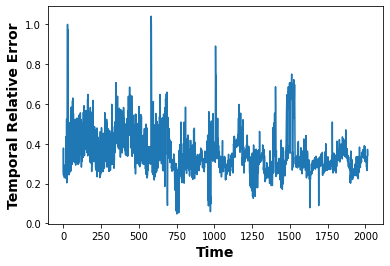

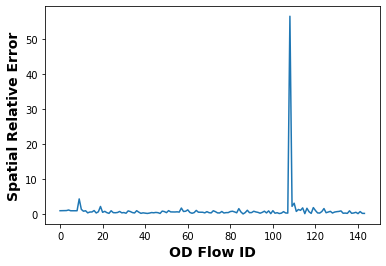

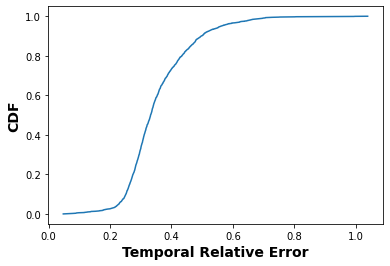

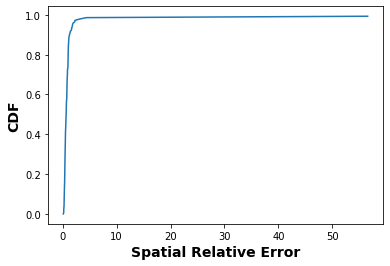

In [15]:
tres = TRE(100*X_test[:,:,:,0], X_pred_2)
sres = SRE(100*X_test[:,:,:,0], X_pred_2)


plt.plot(tres)
plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel("Temporal Relative Error",  fontsize=14, fontweight='bold')
plt.show()

plt.plot(sres)
plt.xlabel('OD Flow ID', fontsize=14, fontweight='bold')
plt.ylabel("Spatial Relative Error",  fontsize=14, fontweight='bold')
plt.show()

x, f = sorted(tres), np.arange(len(tres)) / len(tres)
plt.plot(x, f)
plt.xlabel('Temporal Relative Error', fontsize=14, fontweight='bold')
plt.ylabel("CDF",  fontsize=14, fontweight='bold')
plt.show()

x, f = sorted(sres), np.arange(len(sres)) / len(sres)
plt.plot(x, f)
plt.xlabel('Spatial Relative Error', fontsize=14, fontweight='bold')
plt.ylabel("CDF",  fontsize=14, fontweight='bold')
plt.show()

### RMSE

In [16]:
rmse = RMSE(100*X_test[:,:,:,0], X_pred_2)
print('average RMSE : {}'.format(rmse))

average RMSE : 13.90446644507477


### NMAE

In [17]:
nmae = NMAE(100*X_test[:,:,:,0], X_pred_2)
print('average NMAE : {}'.format(nmae))

average NMAE : 0.3543467178997159


### Mean, Std, Max of TRE

In [18]:
mu = np.mean(tres)
st = np.std(tres)
maximum = np.amax(tres)

print('mean, std and maximum of TRE are: {}, {} and {} respectively'.format(mu, st, maximum))

mean, s## Save predictions (and load them, if need be)td and maximum of TRE are: 0.3556695330188685, 0.1098430173682182 and 1.0386903934188598 respectively


### Save the results

In [19]:
np.save('X_preds_simple', X_pred_2)

# uncomment for loading from file and not running the training/testing again
# X_pred_2 = np.load('X_preds.npy', allow_pickle=True)

## Iterative optimization, starting from a "good" z, with regularization term

In [20]:
max_optimization_iterations = 5000
max_initial_point_iterations = 500
X_pred_2 = np.empty(shape=(test_size,12,12))


for i, y in enumerate(y_test):   
    z = tf.Variable(tf.random.normal(shape=(1,latent_dim), dtype=tf.float32))
    x_pred_start = model.decoder(z)[0,:,:,0]
    y_pred_start = tf.tensordot(A_var, tf.reshape(x_pred_start, (144,1)), 1)
    loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y, y_pred_start)) + 0.1*tf.norm(z)**2
    for iteration in range(max_initial_point_iterations):
        z_new = tf.Variable(tf.random.normal(shape=(1,latent_dim), dtype=tf.float32))
        x_pred_new = model.decoder(z_new)[0,:,:,0]
        y_pred_new = tf.tensordot(A_var, tf.reshape(x_pred_new, (144,1)), 1)
        loss_new = tf.reduce_mean(tf.keras.losses.mean_squared_error(y, y_pred_new)) + 0.1*tf.norm(z)**2
        if loss_new < loss:
            print('found new min loss of: {} in iteration {}'.format(loss_new, iteration))
            z = z_new
            loss = loss_new
    
    # initialize values
    minimum_rmse = np.Inf
    x_pred_best = None
    
    for iteration in range(max_optimization_iterations):
        with tf.GradientTape() as tape:
            # x_pred has shape [1 12 12 1] and we care only for [12 12]
            x_pred = model.decoder(z)[0,:,:,0]
            # find link counts (y_pred) that correspond to predicted TM (x_pred)
            y_pred = tf.tensordot(A_var, tf.reshape(x_pred, (144,1)), 1)
            # compute the loss between true link counts (y) and predicted link counts (y_pred)
            loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y, y_pred)) + 0.1*tf.norm(z)**2
            # find the root mean square error between true TM (X_test) and predicted TM (x_pred)
            rmse = tf.math.sqrt(tf.reduce_mean(tf.keras.losses.mean_squared_error(100*X_test[i,:,:,0], 100*x_pred)))
            # keep TM with the smallest rmse
            if tf.math.less(rmse, minimum_rmse):
                x_pred_best = x_pred
                minimum_rmse = rmse
        # get gradient of loss with respect to z
        grads = tape.gradient(loss, z)
        # update the value of z
        optimizer.apply_gradients(zip([grads], [z]))
    
    print()
    print('minimum RMSE between X_test[{}] and x_pred_best: {} Mbps after {} iterations'.format(i, minimum_rmse, iteration+1))
    X_pred_2[i] = np.array(100*x_pred_best)

found new min loss of: 1.8909287452697754 in iteration 0
found new min loss of: 0.8848618268966675 in iteration 1
found new min loss of: 0.8468015193939209 in iteration 5

minimum RMSE between X_test[0] and x_pred_best: 7.965854644775391 Mbps after 5000 iterations
found new min loss of: 1.0254682302474976 in iteration 4

minimum RMSE between X_test[1] and x_pred_best: 11.491058349609375 Mbps after 5000 iterations
found new min loss of: 0.9027634263038635 in iteration 3
found new min loss of: 0.8125490546226501 in iteration 5

minimum RMSE between X_test[2] and x_pred_best: 8.054712295532227 Mbps after 5000 iterations
found new min loss of: 1.1224000453948975 in iteration 11
found new min loss of: 0.49646538496017456 in iteration 12
found new min loss of: 0.44685977697372437 in iteration 13

minimum RMSE between X_test[3] and x_pred_best: 8.18679141998291 Mbps after 5000 iterations
found new min loss of: 0.6695030927658081 in iteration 5

minimum RMSE between X_test[4] and x_pred_best: 


minimum RMSE between X_test[32] and x_pred_best: 7.7786664962768555 Mbps after 5000 iterations
found new min loss of: 1.6581799983978271 in iteration 0
found new min loss of: 1.4989715814590454 in iteration 4

minimum RMSE between X_test[33] and x_pred_best: 12.07296371459961 Mbps after 5000 iterations
found new min loss of: 2.46602201461792 in iteration 1
found new min loss of: 1.8305121660232544 in iteration 6
found new min loss of: 1.2218340635299683 in iteration 7

minimum RMSE between X_test[34] and x_pred_best: 7.772156238555908 Mbps after 5000 iterations
found new min loss of: 1.814235806465149 in iteration 15
found new min loss of: 0.6952283382415771 in iteration 16

minimum RMSE between X_test[35] and x_pred_best: 11.568875312805176 Mbps after 5000 iterations
found new min loss of: 1.6139763593673706 in iteration 2

minimum RMSE between X_test[36] and x_pred_best: 7.7576398849487305 Mbps after 5000 iterations
found new min loss of: 1.0695077180862427 in iteration 0

minimum R


minimum RMSE between X_test[67] and x_pred_best: 14.565550804138184 Mbps after 5000 iterations
found new min loss of: 1.6738837957382202 in iteration 8
found new min loss of: 1.666445255279541 in iteration 10
found new min loss of: 1.638594627380371 in iteration 12
found new min loss of: 1.3640899658203125 in iteration 14
found new min loss of: 1.0781177282333374 in iteration 19

minimum RMSE between X_test[68] and x_pred_best: 9.98293685913086 Mbps after 5000 iterations
found new min loss of: 1.2087185382843018 in iteration 1
found new min loss of: 0.7767802476882935 in iteration 6

minimum RMSE between X_test[69] and x_pred_best: 13.640711784362793 Mbps after 5000 iterations
found new min loss of: 1.367159128189087 in iteration 9
found new min loss of: 1.2461965084075928 in iteration 19

minimum RMSE between X_test[70] and x_pred_best: 11.243270874023438 Mbps after 5000 iterations
found new min loss of: 0.8835036754608154 in iteration 5
found new min loss of: 0.8775678873062134 in i


minimum RMSE between X_test[103] and x_pred_best: 11.73784065246582 Mbps after 5000 iterations
found new min loss of: 1.4769816398620605 in iteration 0
found new min loss of: 0.8270890116691589 in iteration 2
found new min loss of: 0.8243897557258606 in iteration 426

minimum RMSE between X_test[104] and x_pred_best: 10.110138893127441 Mbps after 5000 iterations
found new min loss of: 1.4533963203430176 in iteration 43
found new min loss of: 1.1586263179779053 in iteration 48

minimum RMSE between X_test[105] and x_pred_best: 12.278297424316406 Mbps after 5000 iterations
found new min loss of: 3.449371337890625 in iteration 0
found new min loss of: 1.0775445699691772 in iteration 1
found new min loss of: 1.0039963722229004 in iteration 4
found new min loss of: 0.9282035231590271 in iteration 18
found new min loss of: 0.8386740684509277 in iteration 19

minimum RMSE between X_test[106] and x_pred_best: 9.456382751464844 Mbps after 5000 iterations
found new min loss of: 2.00282144546508


minimum RMSE between X_test[129] and x_pred_best: 13.388749122619629 Mbps after 5000 iterations
found new min loss of: 1.7483235597610474 in iteration 0
found new min loss of: 1.2130597829818726 in iteration 8

minimum RMSE between X_test[130] and x_pred_best: 10.747493743896484 Mbps after 5000 iterations
found new min loss of: 1.1743741035461426 in iteration 3
found new min loss of: 1.1655257940292358 in iteration 123
found new min loss of: 1.1551049947738647 in iteration 229

minimum RMSE between X_test[131] and x_pred_best: 13.847187995910645 Mbps after 5000 iterations
found new min loss of: 1.9358052015304565 in iteration 2
found new min loss of: 1.6886518001556396 in iteration 6
found new min loss of: 1.37276291847229 in iteration 8
found new min loss of: 1.2608762979507446 in iteration 11
found new min loss of: 0.7278001308441162 in iteration 14

minimum RMSE between X_test[132] and x_pred_best: 10.41130256652832 Mbps after 5000 iterations
found new min loss of: 4.33973836898803


minimum RMSE between X_test[159] and x_pred_best: 18.878076553344727 Mbps after 5000 iterations
found new min loss of: 1.0474189519882202 in iteration 0
found new min loss of: 0.813231348991394 in iteration 7

minimum RMSE between X_test[160] and x_pred_best: 10.16923713684082 Mbps after 5000 iterations
found new min loss of: 5.456019401550293 in iteration 0
found new min loss of: 3.7465176582336426 in iteration 1
found new min loss of: 1.7659327983856201 in iteration 2
found new min loss of: 1.4774527549743652 in iteration 3
found new min loss of: 1.3998247385025024 in iteration 28
found new min loss of: 1.3162775039672852 in iteration 96
found new min loss of: 1.2939246892929077 in iteration 98

minimum RMSE between X_test[161] and x_pred_best: 19.846778869628906 Mbps after 5000 iterations
found new min loss of: 1.7925631999969482 in iteration 0
found new min loss of: 1.3194310665130615 in iteration 2
found new min loss of: 1.3160903453826904 in iteration 11

minimum RMSE between X_


minimum RMSE between X_test[190] and x_pred_best: 9.026965141296387 Mbps after 5000 iterations
found new min loss of: 1.7086308002471924 in iteration 1
found new min loss of: 1.519951581954956 in iteration 5
found new min loss of: 1.1447103023529053 in iteration 8
found new min loss of: 0.9888293743133545 in iteration 9

minimum RMSE between X_test[191] and x_pred_best: 13.651844024658203 Mbps after 5000 iterations
found new min loss of: 1.1801778078079224 in iteration 2
found new min loss of: 1.0503183603286743 in iteration 4
found new min loss of: 1.0106496810913086 in iteration 6

minimum RMSE between X_test[192] and x_pred_best: 8.376084327697754 Mbps after 5000 iterations
found new min loss of: 1.291460633277893 in iteration 3
found new min loss of: 1.1100330352783203 in iteration 4
found new min loss of: 1.1019784212112427 in iteration 38

minimum RMSE between X_test[193] and x_pred_best: 12.509458541870117 Mbps after 5000 iterations
found new min loss of: 4.169126510620117 in i


minimum RMSE between X_test[225] and x_pred_best: 13.593235969543457 Mbps after 5000 iterations
found new min loss of: 1.2558176517486572 in iteration 0

minimum RMSE between X_test[226] and x_pred_best: 7.919606685638428 Mbps after 5000 iterations
found new min loss of: 1.3037068843841553 in iteration 3
found new min loss of: 0.8431862592697144 in iteration 9
found new min loss of: 0.6943577527999878 in iteration 13

minimum RMSE between X_test[227] and x_pred_best: 11.992085456848145 Mbps after 5000 iterations
found new min loss of: 1.8962613344192505 in iteration 0
found new min loss of: 1.352924108505249 in iteration 3
found new min loss of: 1.3262042999267578 in iteration 11
found new min loss of: 0.9300498962402344 in iteration 14
found new min loss of: 0.8730323314666748 in iteration 18
found new min loss of: 0.8652715086936951 in iteration 37
found new min loss of: 0.8104408979415894 in iteration 39

minimum RMSE between X_test[228] and x_pred_best: 8.642667770385742 Mbps afte


minimum RMSE between X_test[259] and x_pred_best: 12.369062423706055 Mbps after 5000 iterations
found new min loss of: 1.0978426933288574 in iteration 1
found new min loss of: 0.9298239350318909 in iteration 3
found new min loss of: 0.8176307082176208 in iteration 4

minimum RMSE between X_test[260] and x_pred_best: 9.36978530883789 Mbps after 5000 iterations
found new min loss of: 1.5835466384887695 in iteration 0
found new min loss of: 0.9317538738250732 in iteration 1

minimum RMSE between X_test[261] and x_pred_best: 13.695394515991211 Mbps after 5000 iterations
found new min loss of: 2.1605396270751953 in iteration 0
found new min loss of: 0.5728389620780945 in iteration 1

minimum RMSE between X_test[262] and x_pred_best: 14.372882843017578 Mbps after 5000 iterations
found new min loss of: 0.7988117337226868 in iteration 13

minimum RMSE between X_test[263] and x_pred_best: 14.587333679199219 Mbps after 5000 iterations
found new min loss of: 0.9167707562446594 in iteration 0
fou


minimum RMSE between X_test[293] and x_pred_best: 13.620485305786133 Mbps after 5000 iterations
found new min loss of: 1.279200792312622 in iteration 3

minimum RMSE between X_test[294] and x_pred_best: 8.986767768859863 Mbps after 5000 iterations
found new min loss of: 1.9897568225860596 in iteration 1
found new min loss of: 1.552948236465454 in iteration 2
found new min loss of: 1.267846941947937 in iteration 8
found new min loss of: 1.1852785348892212 in iteration 14
found new min loss of: 1.1664562225341797 in iteration 26

minimum RMSE between X_test[295] and x_pred_best: 12.075390815734863 Mbps after 5000 iterations
found new min loss of: 1.9613288640975952 in iteration 0
found new min loss of: 0.682220458984375 in iteration 2

minimum RMSE between X_test[296] and x_pred_best: 9.983777046203613 Mbps after 5000 iterations
found new min loss of: 1.8069289922714233 in iteration 4
found new min loss of: 1.6835510730743408 in iteration 6
found new min loss of: 1.127127766609192 in it


minimum RMSE between X_test[327] and x_pred_best: 12.312374114990234 Mbps after 5000 iterations
found new min loss of: 1.5138952732086182 in iteration 0

minimum RMSE between X_test[328] and x_pred_best: 9.645365715026855 Mbps after 5000 iterations
found new min loss of: 1.0891518592834473 in iteration 5

minimum RMSE between X_test[329] and x_pred_best: 16.453136444091797 Mbps after 5000 iterations
found new min loss of: 1.6441667079925537 in iteration 0
found new min loss of: 1.2130993604660034 in iteration 4
found new min loss of: 0.6719555854797363 in iteration 5
found new min loss of: 0.6558814644813538 in iteration 22

minimum RMSE between X_test[330] and x_pred_best: 8.612881660461426 Mbps after 5000 iterations
found new min loss of: 1.0002636909484863 in iteration 0

minimum RMSE between X_test[331] and x_pred_best: 13.185301780700684 Mbps after 5000 iterations
found new min loss of: 1.1959069967269897 in iteration 0

minimum RMSE between X_test[332] and x_pred_best: 13.488912


minimum RMSE between X_test[359] and x_pred_best: 13.294809341430664 Mbps after 5000 iterations
found new min loss of: 1.513250470161438 in iteration 1
found new min loss of: 1.4096968173980713 in iteration 7
found new min loss of: 1.1677286624908447 in iteration 9
found new min loss of: 0.9897911548614502 in iteration 10

minimum RMSE between X_test[360] and x_pred_best: 12.653067588806152 Mbps after 5000 iterations
found new min loss of: 2.777951955795288 in iteration 0
found new min loss of: 1.7441492080688477 in iteration 1
found new min loss of: 1.4325212240219116 in iteration 2
found new min loss of: 0.7458556294441223 in iteration 9

minimum RMSE between X_test[361] and x_pred_best: 13.81997013092041 Mbps after 5000 iterations
found new min loss of: 2.526988983154297 in iteration 0
found new min loss of: 1.5456008911132812 in iteration 1
found new min loss of: 1.5026813745498657 in iteration 3
found new min loss of: 0.9295873641967773 in iteration 11
found new min loss of: 0.75


minimum RMSE between X_test[391] and x_pred_best: 12.998830795288086 Mbps after 5000 iterations
found new min loss of: 3.9224376678466797 in iteration 0
found new min loss of: 0.6955044865608215 in iteration 1

minimum RMSE between X_test[392] and x_pred_best: 10.695596694946289 Mbps after 5000 iterations
found new min loss of: 1.9084832668304443 in iteration 3
found new min loss of: 1.2013026475906372 in iteration 5

minimum RMSE between X_test[393] and x_pred_best: 14.674795150756836 Mbps after 5000 iterations
found new min loss of: 1.1417847871780396 in iteration 2
found new min loss of: 0.74559485912323 in iteration 6

minimum RMSE between X_test[394] and x_pred_best: 9.652486801147461 Mbps after 5000 iterations
found new min loss of: 1.0141291618347168 in iteration 0

minimum RMSE between X_test[395] and x_pred_best: 13.59209156036377 Mbps after 5000 iterations
found new min loss of: 1.3160080909729004 in iteration 1

minimum RMSE between X_test[396] and x_pred_best: 10.538825035

found new min loss of: 1.1878992319107056 in iteration 224

minimum RMSE between X_test[428] and x_pred_best: 9.544489860534668 Mbps after 5000 iterations
found new min loss of: 2.337350845336914 in iteration 1
found new min loss of: 1.6459559202194214 in iteration 5

minimum RMSE between X_test[429] and x_pred_best: 14.918778419494629 Mbps after 5000 iterations
found new min loss of: 1.0587204694747925 in iteration 3
found new min loss of: 0.9198963642120361 in iteration 18
found new min loss of: 0.7659773826599121 in iteration 20

minimum RMSE between X_test[430] and x_pred_best: 11.940408706665039 Mbps after 5000 iterations
found new min loss of: 3.984698534011841 in iteration 0
found new min loss of: 1.889458417892456 in iteration 1
found new min loss of: 1.7164098024368286 in iteration 2
found new min loss of: 1.444022297859192 in iteration 6
found new min loss of: 0.9331240057945251 in iteration 7

minimum RMSE between X_test[431] and x_pred_best: 13.9160737991333 Mbps after 5000


minimum RMSE between X_test[458] and x_pred_best: 13.09699535369873 Mbps after 5000 iterations
found new min loss of: 0.865871787071228 in iteration 6

minimum RMSE between X_test[459] and x_pred_best: 12.868148803710938 Mbps after 5000 iterations
found new min loss of: 1.769653081893921 in iteration 2
found new min loss of: 1.1472541093826294 in iteration 4

minimum RMSE between X_test[460] and x_pred_best: 11.614256858825684 Mbps after 5000 iterations
found new min loss of: 1.457045316696167 in iteration 0

minimum RMSE between X_test[461] and x_pred_best: 16.379972457885742 Mbps after 5000 iterations
found new min loss of: 0.9138747453689575 in iteration 2

minimum RMSE between X_test[462] and x_pred_best: 10.06386661529541 Mbps after 5000 iterations
found new min loss of: 1.3947429656982422 in iteration 5
found new min loss of: 0.9233885407447815 in iteration 8
found new min loss of: 0.8842145204544067 in iteration 13

minimum RMSE between X_test[463] and x_pred_best: 12.991437911


minimum RMSE between X_test[496] and x_pred_best: 8.562322616577148 Mbps after 5000 iterations
found new min loss of: 2.3551151752471924 in iteration 0
found new min loss of: 1.868969202041626 in iteration 1
found new min loss of: 1.8202424049377441 in iteration 5
found new min loss of: 1.4138158559799194 in iteration 6
found new min loss of: 0.7955365180969238 in iteration 9

minimum RMSE between X_test[497] and x_pred_best: 13.754583358764648 Mbps after 5000 iterations
found new min loss of: 1.894447684288025 in iteration 0
found new min loss of: 1.7176501750946045 in iteration 1
found new min loss of: 0.8247570991516113 in iteration 2

minimum RMSE between X_test[498] and x_pred_best: 9.586947441101074 Mbps after 5000 iterations
found new min loss of: 1.1370989084243774 in iteration 0

minimum RMSE between X_test[499] and x_pred_best: 11.90877914428711 Mbps after 5000 iterations
found new min loss of: 1.2132543325424194 in iteration 2
found new min loss of: 1.0354783535003662 in it


minimum RMSE between X_test[530] and x_pred_best: 11.034661293029785 Mbps after 5000 iterations
found new min loss of: 1.0415773391723633 in iteration 9

minimum RMSE between X_test[531] and x_pred_best: 13.124446868896484 Mbps after 5000 iterations
found new min loss of: 1.9117579460144043 in iteration 0
found new min loss of: 1.2192384004592896 in iteration 1
found new min loss of: 1.1564898490905762 in iteration 5
found new min loss of: 1.1370865106582642 in iteration 6
found new min loss of: 0.3936168849468231 in iteration 7

minimum RMSE between X_test[532] and x_pred_best: 12.673537254333496 Mbps after 5000 iterations
found new min loss of: 1.9797394275665283 in iteration 3
found new min loss of: 1.3825137615203857 in iteration 4
found new min loss of: 0.7588160037994385 in iteration 5
found new min loss of: 0.6671274900436401 in iteration 7

minimum RMSE between X_test[533] and x_pred_best: 16.03571891784668 Mbps after 5000 iterations
found new min loss of: 0.9467465877532959 i


minimum RMSE between X_test[565] and x_pred_best: 9.210890769958496 Mbps after 5000 iterations
found new min loss of: 2.3774309158325195 in iteration 0
found new min loss of: 1.2517213821411133 in iteration 1
found new min loss of: 0.4174399673938751 in iteration 5

minimum RMSE between X_test[566] and x_pred_best: 9.836921691894531 Mbps after 5000 iterations
found new min loss of: 0.9048652052879333 in iteration 48

minimum RMSE between X_test[567] and x_pred_best: 11.521278381347656 Mbps after 5000 iterations
found new min loss of: 1.6729614734649658 in iteration 0
found new min loss of: 1.5185946226119995 in iteration 4
found new min loss of: 1.5026640892028809 in iteration 9
found new min loss of: 1.481618046760559 in iteration 15
found new min loss of: 1.1165924072265625 in iteration 16

minimum RMSE between X_test[568] and x_pred_best: 10.133810043334961 Mbps after 5000 iterations
found new min loss of: 1.5065321922302246 in iteration 0
found new min loss of: 1.0741634368896484 


minimum RMSE between X_test[598] and x_pred_best: 9.433575630187988 Mbps after 5000 iterations
found new min loss of: 0.8079786896705627 in iteration 1

minimum RMSE between X_test[599] and x_pred_best: 14.596875190734863 Mbps after 5000 iterations
found new min loss of: 1.4115492105484009 in iteration 28
found new min loss of: 0.4154316782951355 in iteration 33

minimum RMSE between X_test[600] and x_pred_best: 8.216778755187988 Mbps after 5000 iterations
found new min loss of: 1.2177236080169678 in iteration 1
found new min loss of: 1.0161885023117065 in iteration 5

minimum RMSE between X_test[601] and x_pred_best: 12.475027084350586 Mbps after 5000 iterations
found new min loss of: 1.0847944021224976 in iteration 0
found new min loss of: 0.7809089422225952 in iteration 5

minimum RMSE between X_test[602] and x_pred_best: 6.930796146392822 Mbps after 5000 iterations
found new min loss of: 1.4040172100067139 in iteration 0
found new min loss of: 1.1857459545135498 in iteration 6
fou

found new min loss of: 1.0367478132247925 in iteration 294

minimum RMSE between X_test[630] and x_pred_best: 10.90898609161377 Mbps after 5000 iterations
found new min loss of: 1.1437265872955322 in iteration 6
found new min loss of: 1.0537225008010864 in iteration 10
found new min loss of: 1.0358996391296387 in iteration 84

minimum RMSE between X_test[631] and x_pred_best: 18.612215042114258 Mbps after 5000 iterations
found new min loss of: 2.1644973754882812 in iteration 0
found new min loss of: 1.809508204460144 in iteration 4
found new min loss of: 1.2443822622299194 in iteration 5
found new min loss of: 0.9224284887313843 in iteration 8
found new min loss of: 0.8968115448951721 in iteration 32

minimum RMSE between X_test[632] and x_pred_best: 11.674273490905762 Mbps after 5000 iterations
found new min loss of: 0.9065247774124146 in iteration 2
found new min loss of: 0.9018874764442444 in iteration 20
found new min loss of: 0.6957453489303589 in iteration 21
found new min loss o


minimum RMSE between X_test[663] and x_pred_best: 18.379432678222656 Mbps after 5000 iterations
found new min loss of: 1.8330973386764526 in iteration 2
found new min loss of: 1.4192233085632324 in iteration 3

minimum RMSE between X_test[664] and x_pred_best: 21.741928100585938 Mbps after 5000 iterations
found new min loss of: 1.0827161073684692 in iteration 4
found new min loss of: 0.6952450275421143 in iteration 6

minimum RMSE between X_test[665] and x_pred_best: 22.10584831237793 Mbps after 5000 iterations
found new min loss of: 1.087481141090393 in iteration 1
found new min loss of: 0.9339313507080078 in iteration 9

minimum RMSE between X_test[666] and x_pred_best: 14.052643775939941 Mbps after 5000 iterations
found new min loss of: 0.9104004502296448 in iteration 2

minimum RMSE between X_test[667] and x_pred_best: 10.916790008544922 Mbps after 5000 iterations
found new min loss of: 1.1861293315887451 in iteration 0
found new min loss of: 1.1004892587661743 in iteration 6
foun


minimum RMSE between X_test[697] and x_pred_best: 16.130807876586914 Mbps after 5000 iterations
found new min loss of: 1.1560500860214233 in iteration 8
found new min loss of: 0.5311219692230225 in iteration 9

minimum RMSE between X_test[698] and x_pred_best: 23.1657772064209 Mbps after 5000 iterations
found new min loss of: 1.976853847503662 in iteration 0
found new min loss of: 1.6143856048583984 in iteration 3
found new min loss of: 1.1456737518310547 in iteration 4
found new min loss of: 1.0698434114456177 in iteration 11

minimum RMSE between X_test[699] and x_pred_best: 26.310705184936523 Mbps after 5000 iterations
found new min loss of: 1.289922833442688 in iteration 0
found new min loss of: 0.4768332839012146 in iteration 5

minimum RMSE between X_test[700] and x_pred_best: 17.93361473083496 Mbps after 5000 iterations
found new min loss of: 1.7507957220077515 in iteration 0
found new min loss of: 0.5007798075675964 in iteration 2

minimum RMSE between X_test[701] and x_pred_b


minimum RMSE between X_test[735] and x_pred_best: 14.980838775634766 Mbps after 5000 iterations
found new min loss of: 1.2366501092910767 in iteration 0
found new min loss of: 1.0327621698379517 in iteration 1
found new min loss of: 0.7279256582260132 in iteration 2
found new min loss of: 0.6759592294692993 in iteration 121

minimum RMSE between X_test[736] and x_pred_best: 10.942220687866211 Mbps after 5000 iterations
found new min loss of: 3.238957166671753 in iteration 0
found new min loss of: 1.6507017612457275 in iteration 1
found new min loss of: 1.0690466165542603 in iteration 19

minimum RMSE between X_test[737] and x_pred_best: 10.419363021850586 Mbps after 5000 iterations
found new min loss of: 3.1390767097473145 in iteration 3
found new min loss of: 2.55545973777771 in iteration 121
found new min loss of: 2.1611969470977783 in iteration 148
found new min loss of: 1.6373528242111206 in iteration 426
found new min loss of: 0.8496545553207397 in iteration 498

minimum RMSE bet


minimum RMSE between X_test[764] and x_pred_best: 9.286836624145508 Mbps after 5000 iterations
found new min loss of: 19.36752700805664 in iteration 1
found new min loss of: 15.736237525939941 in iteration 2
found new min loss of: 8.060853004455566 in iteration 169
found new min loss of: 5.669291019439697 in iteration 205
found new min loss of: 1.7120201587677002 in iteration 363
found new min loss of: 1.415215253829956 in iteration 422

minimum RMSE between X_test[765] and x_pred_best: 10.502812385559082 Mbps after 5000 iterations
found new min loss of: 21.529191970825195 in iteration 2
found new min loss of: 21.451213836669922 in iteration 7
found new min loss of: 19.011638641357422 in iteration 16
found new min loss of: 18.629444122314453 in iteration 86
found new min loss of: 1.0301322937011719 in iteration 104

minimum RMSE between X_test[766] and x_pred_best: 10.259078025817871 Mbps after 5000 iterations
found new min loss of: 1.768298625946045 in iteration 0
found new min loss 


minimum RMSE between X_test[797] and x_pred_best: 14.732173919677734 Mbps after 5000 iterations
found new min loss of: 10.515569686889648 in iteration 0
found new min loss of: 6.700012683868408 in iteration 1
found new min loss of: 5.0752716064453125 in iteration 6
found new min loss of: 4.080263137817383 in iteration 21
found new min loss of: 3.399975538253784 in iteration 71
found new min loss of: 2.7160825729370117 in iteration 72
found new min loss of: 1.8284103870391846 in iteration 96

minimum RMSE between X_test[798] and x_pred_best: 15.755669593811035 Mbps after 5000 iterations
found new min loss of: 1.9669172763824463 in iteration 0
found new min loss of: 1.7317001819610596 in iteration 8
found new min loss of: 1.7062119245529175 in iteration 11

minimum RMSE between X_test[799] and x_pred_best: 28.252992630004883 Mbps after 5000 iterations
found new min loss of: 15.623751640319824 in iteration 0
found new min loss of: 12.661378860473633 in iteration 12
found new min loss of:


minimum RMSE between X_test[834] and x_pred_best: 14.094644546508789 Mbps after 5000 iterations
found new min loss of: 1.5853760242462158 in iteration 2

minimum RMSE between X_test[835] and x_pred_best: 11.341776847839355 Mbps after 5000 iterations
found new min loss of: 0.7773682475090027 in iteration 0

minimum RMSE between X_test[836] and x_pred_best: 9.702144622802734 Mbps after 5000 iterations
found new min loss of: 1.2953572273254395 in iteration 0
found new min loss of: 1.0155913829803467 in iteration 2

minimum RMSE between X_test[837] and x_pred_best: 15.64564037322998 Mbps after 5000 iterations
found new min loss of: 1.4780254364013672 in iteration 32
found new min loss of: 1.435164451599121 in iteration 38
found new min loss of: 0.6600394248962402 in iteration 43

minimum RMSE between X_test[838] and x_pred_best: 17.14738655090332 Mbps after 5000 iterations
found new min loss of: 1.4389595985412598 in iteration 0
found new min loss of: 1.4272915124893188 in iteration 4
fou


minimum RMSE between X_test[869] and x_pred_best: 9.846744537353516 Mbps after 5000 iterations
found new min loss of: 2.6133697032928467 in iteration 0
found new min loss of: 2.212667465209961 in iteration 1
found new min loss of: 1.976043939590454 in iteration 2
found new min loss of: 1.7750608921051025 in iteration 3
found new min loss of: 1.371015191078186 in iteration 4
found new min loss of: 0.750720202922821 in iteration 5
found new min loss of: 0.6685602068901062 in iteration 7
found new min loss of: 0.43886807560920715 in iteration 8

minimum RMSE between X_test[870] and x_pred_best: 12.980368614196777 Mbps after 5000 iterations
found new min loss of: 0.9190983772277832 in iteration 0
found new min loss of: 0.8042042851448059 in iteration 6

minimum RMSE between X_test[871] and x_pred_best: 18.127822875976562 Mbps after 5000 iterations
found new min loss of: 0.7830202579498291 in iteration 3

minimum RMSE between X_test[872] and x_pred_best: 13.588446617126465 Mbps after 5000 


minimum RMSE between X_test[906] and x_pred_best: 10.914307594299316 Mbps after 5000 iterations
found new min loss of: 1.7771459817886353 in iteration 0
found new min loss of: 1.4218933582305908 in iteration 2
found new min loss of: 1.1268620491027832 in iteration 6

minimum RMSE between X_test[907] and x_pred_best: 11.126968383789062 Mbps after 5000 iterations
found new min loss of: 4.351870536804199 in iteration 0
found new min loss of: 2.3971364498138428 in iteration 1
found new min loss of: 1.07716965675354 in iteration 3
found new min loss of: 0.477475643157959 in iteration 4

minimum RMSE between X_test[908] and x_pred_best: 12.011666297912598 Mbps after 5000 iterations
found new min loss of: 1.0357002019882202 in iteration 0
found new min loss of: 0.7771691679954529 in iteration 1

minimum RMSE between X_test[909] and x_pred_best: 11.955042839050293 Mbps after 5000 iterations
found new min loss of: 1.6674968004226685 in iteration 1
found new min loss of: 1.3824304342269897 in i


minimum RMSE between X_test[944] and x_pred_best: 11.279833793640137 Mbps after 5000 iterations
found new min loss of: 3.571641206741333 in iteration 0
found new min loss of: 2.6464874744415283 in iteration 1
found new min loss of: 1.2347731590270996 in iteration 3
found new min loss of: 0.6798176765441895 in iteration 4

minimum RMSE between X_test[945] and x_pred_best: 11.043620109558105 Mbps after 5000 iterations
found new min loss of: 0.5083979368209839 in iteration 1

minimum RMSE between X_test[946] and x_pred_best: 10.787799835205078 Mbps after 5000 iterations
found new min loss of: 2.702239513397217 in iteration 1
found new min loss of: 1.055831789970398 in iteration 2
found new min loss of: 0.7684723138809204 in iteration 6
found new min loss of: 0.7367541790008545 in iteration 8

minimum RMSE between X_test[947] and x_pred_best: 11.964223861694336 Mbps after 5000 iterations
found new min loss of: 3.148803234100342 in iteration 0
found new min loss of: 1.8719751834869385 in i

found new min loss of: 1.1717562675476074 in iteration 269

minimum RMSE between X_test[974] and x_pred_best: 14.270899772644043 Mbps after 5000 iterations
found new min loss of: 58.242374420166016 in iteration 2
found new min loss of: 53.41320037841797 in iteration 3
found new min loss of: 11.581619262695312 in iteration 9

minimum RMSE between X_test[975] and x_pred_best: 19.92024803161621 Mbps after 5000 iterations
found new min loss of: 55.51494598388672 in iteration 2
found new min loss of: 55.291629791259766 in iteration 14
found new min loss of: 55.26493453979492 in iteration 15
found new min loss of: 54.89207458496094 in iteration 26
found new min loss of: 27.581092834472656 in iteration 30
found new min loss of: 4.547747611999512 in iteration 271

minimum RMSE between X_test[976] and x_pred_best: 20.099714279174805 Mbps after 5000 iterations
found new min loss of: 4.790511131286621 in iteration 3
found new min loss of: 2.0701773166656494 in iteration 342

minimum RMSE between 

found new min loss of: 2.3858566284179688 in iteration 429
found new min loss of: 1.8560247421264648 in iteration 431

minimum RMSE between X_test[1008] and x_pred_best: 30.01524543762207 Mbps after 5000 iterations
found new min loss of: 1.14888596534729 in iteration 3

minimum RMSE between X_test[1009] and x_pred_best: 39.20563888549805 Mbps after 5000 iterations
found new min loss of: 1.88663911819458 in iteration 1

minimum RMSE between X_test[1010] and x_pred_best: 29.06488609313965 Mbps after 5000 iterations
found new min loss of: 1.950608730316162 in iteration 0
found new min loss of: 1.5848634243011475 in iteration 371
found new min loss of: 1.2472333908081055 in iteration 432

minimum RMSE between X_test[1011] and x_pred_best: 40.78163146972656 Mbps after 5000 iterations
found new min loss of: 4.247393608093262 in iteration 1
found new min loss of: 1.8582463264465332 in iteration 3
found new min loss of: 1.8078336715698242 in iteration 90
found new min loss of: 1.60707163810729


minimum RMSE between X_test[1043] and x_pred_best: 13.430123329162598 Mbps after 5000 iterations
found new min loss of: 0.9989064335823059 in iteration 8

minimum RMSE between X_test[1044] and x_pred_best: 13.217100143432617 Mbps after 5000 iterations
found new min loss of: 0.6004089117050171 in iteration 10

minimum RMSE between X_test[1045] and x_pred_best: 11.769366264343262 Mbps after 5000 iterations
found new min loss of: 1.0745881795883179 in iteration 2

minimum RMSE between X_test[1046] and x_pred_best: 12.488320350646973 Mbps after 5000 iterations
found new min loss of: 1.8535873889923096 in iteration 1
found new min loss of: 1.2400622367858887 in iteration 4
found new min loss of: 1.0306651592254639 in iteration 8

minimum RMSE between X_test[1047] and x_pred_best: 13.156270980834961 Mbps after 5000 iterations
found new min loss of: 1.5928643941879272 in iteration 1
found new min loss of: 1.4091157913208008 in iteration 4

minimum RMSE between X_test[1048] and x_pred_best: 1


minimum RMSE between X_test[1080] and x_pred_best: 11.814233779907227 Mbps after 5000 iterations
found new min loss of: 1.1439589262008667 in iteration 0
found new min loss of: 1.0728598833084106 in iteration 5
found new min loss of: 0.7420432567596436 in iteration 6

minimum RMSE between X_test[1081] and x_pred_best: 10.821840286254883 Mbps after 5000 iterations
found new min loss of: 0.9564878940582275 in iteration 0
found new min loss of: 0.955117404460907 in iteration 9

minimum RMSE between X_test[1082] and x_pred_best: 11.19135570526123 Mbps after 5000 iterations
found new min loss of: 0.9889159798622131 in iteration 0
found new min loss of: 0.946556568145752 in iteration 4

minimum RMSE between X_test[1083] and x_pred_best: 10.18505573272705 Mbps after 5000 iterations
found new min loss of: 1.5678892135620117 in iteration 1
found new min loss of: 0.6691872477531433 in iteration 4

minimum RMSE between X_test[1084] and x_pred_best: 11.132408142089844 Mbps after 5000 iterations
f


minimum RMSE between X_test[1119] and x_pred_best: 13.10992431640625 Mbps after 5000 iterations
found new min loss of: 1.7525867223739624 in iteration 0
found new min loss of: 1.6195417642593384 in iteration 2
found new min loss of: 1.0976883172988892 in iteration 3

minimum RMSE between X_test[1120] and x_pred_best: 10.515321731567383 Mbps after 5000 iterations
found new min loss of: 0.9665491580963135 in iteration 1

minimum RMSE between X_test[1121] and x_pred_best: 11.53371810913086 Mbps after 5000 iterations
found new min loss of: 1.385050892829895 in iteration 3
found new min loss of: 1.329972743988037 in iteration 5
found new min loss of: 0.9744818210601807 in iteration 7

minimum RMSE between X_test[1122] and x_pred_best: 10.6358060836792 Mbps after 5000 iterations
found new min loss of: 2.1373748779296875 in iteration 0
found new min loss of: 0.7554135322570801 in iteration 2

minimum RMSE between X_test[1123] and x_pred_best: 11.481122970581055 Mbps after 5000 iterations
fou


minimum RMSE between X_test[1156] and x_pred_best: 16.764028549194336 Mbps after 5000 iterations
found new min loss of: 1.0119832754135132 in iteration 0
found new min loss of: 0.7865965962409973 in iteration 2

minimum RMSE between X_test[1157] and x_pred_best: 15.776040077209473 Mbps after 5000 iterations
found new min loss of: 1.9909778833389282 in iteration 2
found new min loss of: 0.5130394697189331 in iteration 3

minimum RMSE between X_test[1158] and x_pred_best: 17.229459762573242 Mbps after 5000 iterations
found new min loss of: 1.1270265579223633 in iteration 0
found new min loss of: 1.1025617122650146 in iteration 3

minimum RMSE between X_test[1159] and x_pred_best: 19.964962005615234 Mbps after 5000 iterations
found new min loss of: 0.9219549298286438 in iteration 3

minimum RMSE between X_test[1160] and x_pred_best: 24.39637565612793 Mbps after 5000 iterations
found new min loss of: 0.4803597033023834 in iteration 0

minimum RMSE between X_test[1161] and x_pred_best: 17.


minimum RMSE between X_test[1193] and x_pred_best: 19.7614688873291 Mbps after 5000 iterations
found new min loss of: 1.4151158332824707 in iteration 2

minimum RMSE between X_test[1194] and x_pred_best: 21.0399169921875 Mbps after 5000 iterations
found new min loss of: 2.896928310394287 in iteration 0
found new min loss of: 2.728534698486328 in iteration 1
found new min loss of: 2.050032138824463 in iteration 2
found new min loss of: 1.585437297821045 in iteration 5

minimum RMSE between X_test[1195] and x_pred_best: 20.488710403442383 Mbps after 5000 iterations
found new min loss of: 0.800973653793335 in iteration 0

minimum RMSE between X_test[1196] and x_pred_best: 20.938886642456055 Mbps after 5000 iterations
found new min loss of: 1.666041374206543 in iteration 0
found new min loss of: 1.5356311798095703 in iteration 3
found new min loss of: 1.217801570892334 in iteration 4
found new min loss of: 0.9815635681152344 in iteration 5

minimum RMSE between X_test[1197] and x_pred_bes


minimum RMSE between X_test[1229] and x_pred_best: 11.922165870666504 Mbps after 5000 iterations
found new min loss of: 0.901268482208252 in iteration 3

minimum RMSE between X_test[1230] and x_pred_best: 11.419057846069336 Mbps after 5000 iterations
found new min loss of: 1.2822232246398926 in iteration 0
found new min loss of: 1.242256760597229 in iteration 7

minimum RMSE between X_test[1231] and x_pred_best: 10.828110694885254 Mbps after 5000 iterations
found new min loss of: 1.2657848596572876 in iteration 7
found new min loss of: 0.809281587600708 in iteration 10

minimum RMSE between X_test[1232] and x_pred_best: 10.659832000732422 Mbps after 5000 iterations
found new min loss of: 1.9865466356277466 in iteration 0
found new min loss of: 1.170086145401001 in iteration 1

minimum RMSE between X_test[1233] and x_pred_best: 19.92948341369629 Mbps after 5000 iterations
found new min loss of: 1.7008514404296875 in iteration 0
found new min loss of: 1.6809837818145752 in iteration 1
f


minimum RMSE between X_test[1260] and x_pred_best: 16.224468231201172 Mbps after 5000 iterations
found new min loss of: 3.9883594512939453 in iteration 0
found new min loss of: 3.6981277465820312 in iteration 395
found new min loss of: 3.587310314178467 in iteration 486
found new min loss of: 2.0054280757904053 in iteration 492

minimum RMSE between X_test[1261] and x_pred_best: 12.405325889587402 Mbps after 5000 iterations
found new min loss of: 1.6995189189910889 in iteration 2
found new min loss of: 1.4463813304901123 in iteration 294

minimum RMSE between X_test[1262] and x_pred_best: 9.740275382995605 Mbps after 5000 iterations
found new min loss of: 1.0076026916503906 in iteration 2

minimum RMSE between X_test[1263] and x_pred_best: 15.05061149597168 Mbps after 5000 iterations
found new min loss of: 0.7752124667167664 in iteration 3
found new min loss of: 0.7750201225280762 in iteration 12
found new min loss of: 0.715123176574707 in iteration 18

minimum RMSE between X_test[126


minimum RMSE between X_test[1290] and x_pred_best: 10.236238479614258 Mbps after 5000 iterations
found new min loss of: 1.5263621807098389 in iteration 0
found new min loss of: 1.0534303188323975 in iteration 1
found new min loss of: 0.8790215253829956 in iteration 2
found new min loss of: 0.8749304413795471 in iteration 33
found new min loss of: 0.8253674507141113 in iteration 37

minimum RMSE between X_test[1291] and x_pred_best: 12.06540298461914 Mbps after 5000 iterations
found new min loss of: 0.7151229381561279 in iteration 0

minimum RMSE between X_test[1292] and x_pred_best: 13.493705749511719 Mbps after 5000 iterations
found new min loss of: 2.170166254043579 in iteration 0
found new min loss of: 2.0515811443328857 in iteration 2
found new min loss of: 1.4683092832565308 in iteration 7
found new min loss of: 0.7477258443832397 in iteration 9

minimum RMSE between X_test[1293] and x_pred_best: 18.438764572143555 Mbps after 5000 iterations
found new min loss of: 2.0290753841400


minimum RMSE between X_test[1323] and x_pred_best: 12.689517974853516 Mbps after 5000 iterations
found new min loss of: 2.432241916656494 in iteration 1
found new min loss of: 1.3632831573486328 in iteration 2
found new min loss of: 1.1855475902557373 in iteration 3

minimum RMSE between X_test[1324] and x_pred_best: 13.884974479675293 Mbps after 5000 iterations
found new min loss of: 1.2670211791992188 in iteration 0
found new min loss of: 0.932585597038269 in iteration 1
found new min loss of: 0.7593511343002319 in iteration 7

minimum RMSE between X_test[1325] and x_pred_best: 12.36262321472168 Mbps after 5000 iterations
found new min loss of: 1.1498076915740967 in iteration 0
found new min loss of: 1.1394379138946533 in iteration 77

minimum RMSE between X_test[1326] and x_pred_best: 11.700922012329102 Mbps after 5000 iterations
found new min loss of: 1.7959998846054077 in iteration 0
found new min loss of: 1.286515474319458 in iteration 2
found new min loss of: 1.117110252380371 


minimum RMSE between X_test[1357] and x_pred_best: 20.266483306884766 Mbps after 5000 iterations
found new min loss of: 1.1560455560684204 in iteration 22
found new min loss of: 0.9302096366882324 in iteration 23

minimum RMSE between X_test[1358] and x_pred_best: 16.769926071166992 Mbps after 5000 iterations
found new min loss of: 0.6550981998443604 in iteration 1
found new min loss of: 0.6522778272628784 in iteration 97

minimum RMSE between X_test[1359] and x_pred_best: 15.117195129394531 Mbps after 5000 iterations
found new min loss of: 1.2141478061676025 in iteration 5

minimum RMSE between X_test[1360] and x_pred_best: 12.509432792663574 Mbps after 5000 iterations
found new min loss of: 1.1823863983154297 in iteration 0
found new min loss of: 1.1555655002593994 in iteration 2
found new min loss of: 1.0600982904434204 in iteration 8
found new min loss of: 0.8057482242584229 in iteration 11

minimum RMSE between X_test[1361] and x_pred_best: 12.358024597167969 Mbps after 5000 iter


minimum RMSE between X_test[1393] and x_pred_best: 14.84187126159668 Mbps after 5000 iterations
found new min loss of: 0.8287162184715271 in iteration 1

minimum RMSE between X_test[1394] and x_pred_best: 27.827404022216797 Mbps after 5000 iterations
found new min loss of: 0.8013843894004822 in iteration 35
found new min loss of: 0.7794107794761658 in iteration 36

minimum RMSE between X_test[1395] and x_pred_best: 18.072120666503906 Mbps after 5000 iterations
found new min loss of: 1.5570744276046753 in iteration 1

minimum RMSE between X_test[1396] and x_pred_best: 20.58938980102539 Mbps after 5000 iterations
found new min loss of: 0.9618935585021973 in iteration 0

minimum RMSE between X_test[1397] and x_pred_best: 21.321121215820312 Mbps after 5000 iterations
found new min loss of: 0.7578777074813843 in iteration 0

minimum RMSE between X_test[1398] and x_pred_best: 22.26473045349121 Mbps after 5000 iterations
found new min loss of: 2.3515143394470215 in iteration 1
found new min 


minimum RMSE between X_test[1428] and x_pred_best: 11.486096382141113 Mbps after 5000 iterations
found new min loss of: 0.9776360988616943 in iteration 10
found new min loss of: 0.5237703323364258 in iteration 11
found new min loss of: 0.5056514143943787 in iteration 25

minimum RMSE between X_test[1429] and x_pred_best: 11.152667999267578 Mbps after 5000 iterations
found new min loss of: 1.9659804105758667 in iteration 0
found new min loss of: 1.433269739151001 in iteration 5
found new min loss of: 1.0214468240737915 in iteration 9

minimum RMSE between X_test[1430] and x_pred_best: 9.632213592529297 Mbps after 5000 iterations
found new min loss of: 0.7158557772636414 in iteration 1

minimum RMSE between X_test[1431] and x_pred_best: 10.078132629394531 Mbps after 5000 iterations
found new min loss of: 2.677885055541992 in iteration 0
found new min loss of: 2.2643332481384277 in iteration 3
found new min loss of: 1.5807721614837646 in iteration 4

minimum RMSE between X_test[1432] and


minimum RMSE between X_test[1464] and x_pred_best: 9.16118335723877 Mbps after 5000 iterations
found new min loss of: 0.676477313041687 in iteration 2

minimum RMSE between X_test[1465] and x_pred_best: 9.652644157409668 Mbps after 5000 iterations
found new min loss of: 1.2059524059295654 in iteration 2
found new min loss of: 0.8279585242271423 in iteration 4
found new min loss of: 0.8165263533592224 in iteration 13

minimum RMSE between X_test[1466] and x_pred_best: 10.038305282592773 Mbps after 5000 iterations
found new min loss of: 2.6797714233398438 in iteration 1
found new min loss of: 1.657788872718811 in iteration 2
found new min loss of: 1.1008104085922241 in iteration 4

minimum RMSE between X_test[1467] and x_pred_best: 10.307027816772461 Mbps after 5000 iterations
found new min loss of: 0.7820367813110352 in iteration 1
found new min loss of: 0.6402328610420227 in iteration 2

minimum RMSE between X_test[1468] and x_pred_best: 9.657272338867188 Mbps after 5000 iterations
fo


minimum RMSE between X_test[1501] and x_pred_best: 12.346305847167969 Mbps after 5000 iterations
found new min loss of: 3.5020809173583984 in iteration 0
found new min loss of: 2.7657337188720703 in iteration 1
found new min loss of: 1.8166422843933105 in iteration 4
found new min loss of: 1.3821663856506348 in iteration 6

minimum RMSE between X_test[1502] and x_pred_best: 25.753938674926758 Mbps after 5000 iterations
found new min loss of: 1.9927341938018799 in iteration 13
found new min loss of: 1.5281176567077637 in iteration 14
found new min loss of: 1.5126817226409912 in iteration 25

minimum RMSE between X_test[1503] and x_pred_best: 27.55092430114746 Mbps after 5000 iterations
found new min loss of: 5.544980049133301 in iteration 0
found new min loss of: 2.9100701808929443 in iteration 1
found new min loss of: 2.169279098510742 in iteration 5
found new min loss of: 2.1083343029022217 in iteration 6
found new min loss of: 2.0032763481140137 in iteration 7
found new min loss of:


minimum RMSE between X_test[1536] and x_pred_best: 11.527029991149902 Mbps after 5000 iterations
found new min loss of: 0.4275733232498169 in iteration 1

minimum RMSE between X_test[1537] and x_pred_best: 12.329679489135742 Mbps after 5000 iterations
found new min loss of: 1.7137181758880615 in iteration 0
found new min loss of: 0.9427405595779419 in iteration 1

minimum RMSE between X_test[1538] and x_pred_best: 14.021209716796875 Mbps after 5000 iterations
found new min loss of: 0.46323686838150024 in iteration 0

minimum RMSE between X_test[1539] and x_pred_best: 12.58963394165039 Mbps after 5000 iterations
found new min loss of: 1.5248801708221436 in iteration 0
found new min loss of: 0.9010144472122192 in iteration 1

minimum RMSE between X_test[1540] and x_pred_best: 11.072617530822754 Mbps after 5000 iterations
found new min loss of: 0.7617296576499939 in iteration 0

minimum RMSE between X_test[1541] and x_pred_best: 11.164261817932129 Mbps after 5000 iterations
found new min


minimum RMSE between X_test[1571] and x_pred_best: 14.8333740234375 Mbps after 5000 iterations
found new min loss of: 0.9023193120956421 in iteration 1
found new min loss of: 0.5266326665878296 in iteration 4

minimum RMSE between X_test[1572] and x_pred_best: 12.743925094604492 Mbps after 5000 iterations
found new min loss of: 1.5816510915756226 in iteration 1
found new min loss of: 0.7068044543266296 in iteration 3

minimum RMSE between X_test[1573] and x_pred_best: 19.44721221923828 Mbps after 5000 iterations
found new min loss of: 3.025724411010742 in iteration 0
found new min loss of: 1.6569311618804932 in iteration 2

minimum RMSE between X_test[1574] and x_pred_best: 12.774443626403809 Mbps after 5000 iterations
found new min loss of: 1.0860507488250732 in iteration 0
found new min loss of: 1.0212922096252441 in iteration 1

minimum RMSE between X_test[1575] and x_pred_best: 11.629542350769043 Mbps after 5000 iterations
found new min loss of: 0.742435097694397 in iteration 0

m


minimum RMSE between X_test[1604] and x_pred_best: 11.41092586517334 Mbps after 5000 iterations
found new min loss of: 1.1943280696868896 in iteration 0
found new min loss of: 1.081538438796997 in iteration 1

minimum RMSE between X_test[1605] and x_pred_best: 12.26897144317627 Mbps after 5000 iterations
found new min loss of: 1.42891526222229 in iteration 0
found new min loss of: 1.345832109451294 in iteration 4
found new min loss of: 1.1256424188613892 in iteration 7
found new min loss of: 0.8600974678993225 in iteration 10
found new min loss of: 0.7490664124488831 in iteration 25

minimum RMSE between X_test[1606] and x_pred_best: 10.077051162719727 Mbps after 5000 iterations
found new min loss of: 1.0648800134658813 in iteration 0

minimum RMSE between X_test[1607] and x_pred_best: 21.645626068115234 Mbps after 5000 iterations
found new min loss of: 1.1682454347610474 in iteration 0
found new min loss of: 0.8246809244155884 in iteration 1

minimum RMSE between X_test[1608] and x_p


minimum RMSE between X_test[1636] and x_pred_best: 11.322577476501465 Mbps after 5000 iterations
found new min loss of: 0.9293613433837891 in iteration 0

minimum RMSE between X_test[1637] and x_pred_best: 12.710653305053711 Mbps after 5000 iterations
found new min loss of: 1.1436171531677246 in iteration 1
found new min loss of: 0.9768483638763428 in iteration 14

minimum RMSE between X_test[1638] and x_pred_best: 11.786201477050781 Mbps after 5000 iterations
found new min loss of: 3.659770965576172 in iteration 0
found new min loss of: 1.9787758588790894 in iteration 1
found new min loss of: 1.4511568546295166 in iteration 3
found new min loss of: 0.9424296617507935 in iteration 8

minimum RMSE between X_test[1639] and x_pred_best: 13.06546688079834 Mbps after 5000 iterations
found new min loss of: 1.2450382709503174 in iteration 13
found new min loss of: 0.8835408091545105 in iteration 15
found new min loss of: 0.7825678586959839 in iteration 26
found new min loss of: 0.37686797976


minimum RMSE between X_test[1667] and x_pred_best: 10.991541862487793 Mbps after 5000 iterations
found new min loss of: 1.4229090213775635 in iteration 0
found new min loss of: 1.151828408241272 in iteration 2
found new min loss of: 1.1475520133972168 in iteration 48

minimum RMSE between X_test[1668] and x_pred_best: 10.287627220153809 Mbps after 5000 iterations
found new min loss of: 1.8255535364151 in iteration 2
found new min loss of: 1.4565365314483643 in iteration 5

minimum RMSE between X_test[1669] and x_pred_best: 10.241954803466797 Mbps after 5000 iterations
found new min loss of: 3.5168261528015137 in iteration 0
found new min loss of: 0.725351870059967 in iteration 1

minimum RMSE between X_test[1670] and x_pred_best: 13.281349182128906 Mbps after 5000 iterations
found new min loss of: 1.3197524547576904 in iteration 0

minimum RMSE between X_test[1671] and x_pred_best: 13.478699684143066 Mbps after 5000 iterations
found new min loss of: 1.2454278469085693 in iteration 1




minimum RMSE between X_test[1701] and x_pred_best: 11.920284271240234 Mbps after 5000 iterations
found new min loss of: 1.8194706439971924 in iteration 1
found new min loss of: 1.2838490009307861 in iteration 2
found new min loss of: 1.2709643840789795 in iteration 8
found new min loss of: 1.2009384632110596 in iteration 10

minimum RMSE between X_test[1702] and x_pred_best: 11.90909481048584 Mbps after 5000 iterations
found new min loss of: 1.025740146636963 in iteration 0
found new min loss of: 0.8726449608802795 in iteration 2

minimum RMSE between X_test[1703] and x_pred_best: 11.759040832519531 Mbps after 5000 iterations
found new min loss of: 1.0640015602111816 in iteration 4
found new min loss of: 1.0206698179244995 in iteration 39

minimum RMSE between X_test[1704] and x_pred_best: 12.451144218444824 Mbps after 5000 iterations
found new min loss of: 1.2525835037231445 in iteration 0
found new min loss of: 0.8792299032211304 in iteration 1

minimum RMSE between X_test[1705] and


minimum RMSE between X_test[1736] and x_pred_best: 9.575382232666016 Mbps after 5000 iterations
found new min loss of: 3.789689540863037 in iteration 0
found new min loss of: 2.1486189365386963 in iteration 2
found new min loss of: 1.0920257568359375 in iteration 3
found new min loss of: 1.0331951379776 in iteration 11
found new min loss of: 0.9462285041809082 in iteration 15
found new min loss of: 0.6989989280700684 in iteration 17
found new min loss of: 0.6613588333129883 in iteration 18

minimum RMSE between X_test[1737] and x_pred_best: 9.169708251953125 Mbps after 5000 iterations
found new min loss of: 2.4109060764312744 in iteration 0
found new min loss of: 1.2963913679122925 in iteration 1

minimum RMSE between X_test[1738] and x_pred_best: 14.447066307067871 Mbps after 5000 iterations
found new min loss of: 1.3264858722686768 in iteration 19
found new min loss of: 0.4791276454925537 in iteration 21

minimum RMSE between X_test[1739] and x_pred_best: 13.549269676208496 Mbps aft


minimum RMSE between X_test[1774] and x_pred_best: 10.937759399414062 Mbps after 5000 iterations
found new min loss of: 2.0529732704162598 in iteration 5
found new min loss of: 0.7817345857620239 in iteration 7

minimum RMSE between X_test[1775] and x_pred_best: 10.6055326461792 Mbps after 5000 iterations
found new min loss of: 0.9916924834251404 in iteration 0
found new min loss of: 0.7553396224975586 in iteration 7

minimum RMSE between X_test[1776] and x_pred_best: 10.19873332977295 Mbps after 5000 iterations
found new min loss of: 1.7162389755249023 in iteration 0
found new min loss of: 0.855854868888855 in iteration 2

minimum RMSE between X_test[1777] and x_pred_best: 10.628369331359863 Mbps after 5000 iterations
found new min loss of: 2.3715291023254395 in iteration 1
found new min loss of: 0.574576735496521 in iteration 2

minimum RMSE between X_test[1778] and x_pred_best: 10.383097648620605 Mbps after 5000 iterations
found new min loss of: 5.293429851531982 in iteration 0
fou


minimum RMSE between X_test[1812] and x_pred_best: 16.692445755004883 Mbps after 5000 iterations
found new min loss of: 0.8586992025375366 in iteration 129

minimum RMSE between X_test[1813] and x_pred_best: 11.207650184631348 Mbps after 5000 iterations
found new min loss of: 1.4511058330535889 in iteration 1
found new min loss of: 0.3227972388267517 in iteration 5

minimum RMSE between X_test[1814] and x_pred_best: 13.399181365966797 Mbps after 5000 iterations
found new min loss of: 1.2112681865692139 in iteration 0
found new min loss of: 1.0352427959442139 in iteration 2

minimum RMSE between X_test[1815] and x_pred_best: 12.908332824707031 Mbps after 5000 iterations
found new min loss of: 1.0449118614196777 in iteration 0

minimum RMSE between X_test[1816] and x_pred_best: 13.585654258728027 Mbps after 5000 iterations
found new min loss of: 1.7910032272338867 in iteration 0
found new min loss of: 0.7783899307250977 in iteration 4
found new min loss of: 0.6672553420066833 in iterati


minimum RMSE between X_test[1847] and x_pred_best: 13.451014518737793 Mbps after 5000 iterations
found new min loss of: 1.8385188579559326 in iteration 1
found new min loss of: 0.9127114415168762 in iteration 2
found new min loss of: 0.8764141201972961 in iteration 13

minimum RMSE between X_test[1848] and x_pred_best: 21.025184631347656 Mbps after 5000 iterations
found new min loss of: 1.2942065000534058 in iteration 2
found new min loss of: 0.7672664523124695 in iteration 3

minimum RMSE between X_test[1849] and x_pred_best: 17.537342071533203 Mbps after 5000 iterations
found new min loss of: 1.6307111978530884 in iteration 1
found new min loss of: 1.1926950216293335 in iteration 2
found new min loss of: 0.9960135221481323 in iteration 6
found new min loss of: 0.9599806070327759 in iteration 15

minimum RMSE between X_test[1850] and x_pred_best: 16.10059928894043 Mbps after 5000 iterations
found new min loss of: 1.1382733583450317 in iteration 0
found new min loss of: 0.842549860477


minimum RMSE between X_test[1882] and x_pred_best: 14.724390983581543 Mbps after 5000 iterations
found new min loss of: 2.519348382949829 in iteration 1
found new min loss of: 1.1786599159240723 in iteration 3
found new min loss of: 1.130135178565979 in iteration 17

minimum RMSE between X_test[1883] and x_pred_best: 14.758206367492676 Mbps after 5000 iterations
found new min loss of: 1.9617581367492676 in iteration 2
found new min loss of: 1.7187604904174805 in iteration 4

minimum RMSE between X_test[1884] and x_pred_best: 12.60129165649414 Mbps after 5000 iterations
found new min loss of: 0.8474500179290771 in iteration 53
found new min loss of: 0.8331619501113892 in iteration 57

minimum RMSE between X_test[1885] and x_pred_best: 14.394323348999023 Mbps after 5000 iterations
found new min loss of: 1.7821348905563354 in iteration 2
found new min loss of: 1.7131106853485107 in iteration 4
found new min loss of: 1.1108077764511108 in iteration 5

minimum RMSE between X_test[1886] and


minimum RMSE between X_test[1920] and x_pred_best: 9.68982219696045 Mbps after 5000 iterations
found new min loss of: 1.1999119520187378 in iteration 15
found new min loss of: 0.90575110912323 in iteration 17
found new min loss of: 0.7697582840919495 in iteration 18
found new min loss of: 0.5805485248565674 in iteration 22

minimum RMSE between X_test[1921] and x_pred_best: 10.666744232177734 Mbps after 5000 iterations
found new min loss of: 1.211909294128418 in iteration 4
found new min loss of: 1.2051315307617188 in iteration 14
found new min loss of: 0.5956067442893982 in iteration 16

minimum RMSE between X_test[1922] and x_pred_best: 10.215453147888184 Mbps after 5000 iterations
found new min loss of: 0.4847567081451416 in iteration 45

minimum RMSE between X_test[1923] and x_pred_best: 10.842423439025879 Mbps after 5000 iterations
found new min loss of: 1.4705860614776611 in iteration 4

minimum RMSE between X_test[1924] and x_pred_best: 10.776060104370117 Mbps after 5000 iterat


minimum RMSE between X_test[1960] and x_pred_best: 10.804363250732422 Mbps after 5000 iterations
found new min loss of: 0.8593761324882507 in iteration 0

minimum RMSE between X_test[1961] and x_pred_best: 13.792891502380371 Mbps after 5000 iterations
found new min loss of: 1.3106205463409424 in iteration 0
found new min loss of: 0.8580187559127808 in iteration 1

minimum RMSE between X_test[1962] and x_pred_best: 11.373151779174805 Mbps after 5000 iterations
found new min loss of: 1.3964221477508545 in iteration 1
found new min loss of: 1.3953146934509277 in iteration 131
found new min loss of: 1.091077446937561 in iteration 133

minimum RMSE between X_test[1963] and x_pred_best: 9.905190467834473 Mbps after 5000 iterations
found new min loss of: 0.5853244066238403 in iteration 23

minimum RMSE between X_test[1964] and x_pred_best: 11.357834815979004 Mbps after 5000 iterations
found new min loss of: 1.7207157611846924 in iteration 1
found new min loss of: 1.7037596702575684 in iterat


minimum RMSE between X_test[1997] and x_pred_best: 13.892777442932129 Mbps after 5000 iterations
found new min loss of: 2.2354047298431396 in iteration 0
found new min loss of: 1.3933215141296387 in iteration 1
found new min loss of: 0.7727320194244385 in iteration 3

minimum RMSE between X_test[1998] and x_pred_best: 12.938030242919922 Mbps after 5000 iterations
found new min loss of: 3.8486621379852295 in iteration 0
found new min loss of: 2.671224355697632 in iteration 1
found new min loss of: 1.9195894002914429 in iteration 2
found new min loss of: 0.6784831285476685 in iteration 3

minimum RMSE between X_test[1999] and x_pred_best: 13.313478469848633 Mbps after 5000 iterations
found new min loss of: 1.518170952796936 in iteration 0
found new min loss of: 1.0590553283691406 in iteration 2

minimum RMSE between X_test[2000] and x_pred_best: 12.229727745056152 Mbps after 5000 iterations
found new min loss of: 1.1444306373596191 in iteration 5

minimum RMSE between X_test[2001] and x

### Plotting

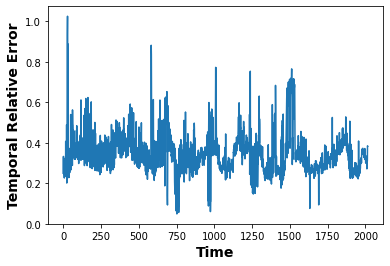

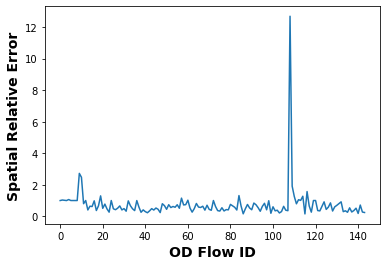

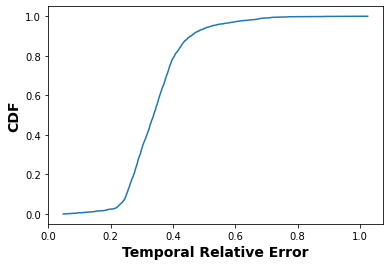

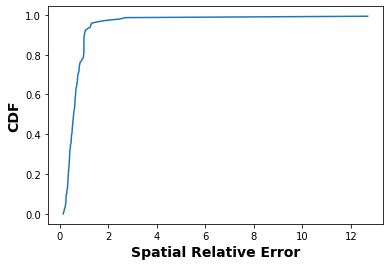

In [21]:
tres = TRE(100*X_test[:,:,:,0], X_pred_2)
sres = SRE(100*X_test[:,:,:,0], X_pred_2)


plt.plot(tres)
plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel("Temporal Relative Error",  fontsize=14, fontweight='bold')
plt.show()

plt.plot(sres)
plt.xlabel('OD Flow ID', fontsize=14, fontweight='bold')
plt.ylabel("Spatial Relative Error",  fontsize=14, fontweight='bold')
plt.show()

x, f = sorted(tres), np.arange(len(tres)) / len(tres)
plt.plot(x, f)
plt.xlabel('Temporal Relative Error', fontsize=14, fontweight='bold')
plt.ylabel("CDF",  fontsize=14, fontweight='bold')
plt.show()

x, f = sorted(sres), np.arange(len(sres)) / len(sres)
plt.plot(x, f)
plt.xlabel('Spatial Relative Error', fontsize=14, fontweight='bold')
plt.ylabel("CDF",  fontsize=14, fontweight='bold')
plt.show()

### RMSE

In [22]:
rmse = RMSE(100*X_test[:,:,:,0], X_pred_2)
print('average RMSE : {}'.format(rmse))

average RMSE : 13.689318327785076


### NMAE

In [23]:
nmae = NMAE(100*X_test[:,:,:,0], X_pred_2)
print('average NMAE : {}'.format(nmae))

average NMAE : 0.34656031809783727


### Mean, Std, Max of TRE

In [24]:
mu = np.mean(tres)
st = np.std(tres)
maximum = np.amax(tres)

print('mean, std and maximum of TRE are: {}, {} and {} respectively'.format(mu, st, maximum))

mean, std and maximum of TRE are: 0.3487648566656716, 0.0988816781904001 and 1.0248974799070372 respectively


### Save the results

In [25]:
np.save('X_preds_regularization', X_pred_2)

# uncomment for loading from file and not running the training/testing again
# X_pred_2 = np.load('X_preds.npy', allow_pickle=True)

## Concurrent optimization, starting from a "good" z, with regularization term

In [ ]:
round_optimization_iterations = 3000
round_training_epochs = 20
X_pred_2 = np.empty(shape=(test_size,12,12))
max_initial_point_iterations = 500



for i, y in enumerate(y_test):
    
    # new model for each test
    optimizer = tf.keras.optimizers.Adam()
    
    encoder_inputs = tf.keras.Input(shape=(12, 12, 1))
    x = tf.keras.layers.Dropout(0.25)(encoder_inputs)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(64, activation="relu")(latent_inputs)
    x = tf.keras.layers.Dense(3 * 3 * 64, activation="relu")(x)
    x = tf.keras.layers.Reshape((3, 3, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(64,  3, activation="relu", strides=2, padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(32,  3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="relu", padding="same")(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
    
    model = VAE(encoder, decoder)
    model.compile(optimizer=tf.keras.optimizers.Adam())
    earlystoppingmonitor = EarlyStoppingAtMinLoss()
    
    # find good starting point 
    z = tf.Variable(tf.random.normal(shape=(1,latent_dim), dtype=tf.float32))
    x_pred_start = model.decoder(z)[0,:,:,0]
    y_pred_start = tf.tensordot(A_var, tf.reshape(x_pred_start, (144,1)), 1)
    loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y, y_pred_start)) + 0.1*tf.norm(z)**2
    for iteration in range(max_initial_point_iterations):
        z_new = tf.Variable(tf.random.normal(shape=(1,latent_dim), dtype=tf.float32))
        x_pred_new = model.decoder(z_new)[0,:,:,0]
        y_pred_new = tf.tensordot(A_var, tf.reshape(x_pred_new, (144,1)), 1)
        loss_new = tf.reduce_mean(tf.keras.losses.mean_squared_error(y, y_pred_new)) + 0.1*tf.norm(z)**2
        if loss_new < loss:
            z = z_new
            loss = loss_new
    
    # initialize values
    minimum_rmse = np.Inf
    x_pred_best = None
    
    loops_run = 0
    while loops_run < 7:
        # continue training from last loop iteration
        model.fit(X_train, epochs=round_training_epochs, batch_size=128, callbacks=[earlystoppingmonitor],)
        for iteration in range(round_optimization_iterations):
            with tf.GradientTape() as tape:
                x_pred = model.decoder(z)[0,:,:,0] # HERE USE OPTIMAL z FROM PREVIOUS OPTIMIZATION                
                # find link counts (y_pred) that correspond to predicted TM (x_pred)
                y_pred = tf.tensordot(A_var, tf.reshape(x_pred, (144,1)), 1)
                # compute the loss between true link counts (y) and predicted link counts (y_pred)
                loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y, y_pred)) + 0.1*tf.norm(z)**2
                # find the root mean square error between true TM (X_test) and predicted TM (x_pred)
                # in Mbps
                rmse = tf.math.sqrt(tf.reduce_mean(tf.keras.losses.mean_squared_error(100*X_test[i,:,:,0], 100*x_pred)))
                # keep TM with the smallest rmse
                if tf.math.less(rmse, minimum_rmse):
                    x_pred_best = x_pred
                    minimum_rmse = rmse                        
            # get gradient of loss with respect to z
            grads = tape.gradient(loss, z)
            # update the value of z
            optimizer.apply_gradients(zip([grads], [z]))
        loops_run += 1
    
    print('minimum RMSE between X_test[{}] and x_pred_best: {} Mbps after {} iterations'.format(i, minimum_rmse, iteration))
    print()
    X_pred_2[i] = np.array(100*x_pred_best)        

Epoch 1/20
205/205 [==============================] - 4s 17ms/step - loss: 82.7504
Epoch 2/20
205/205 [==============================] - 3s 16ms/step - loss: 14.3668
Epoch 3/20
205/205 [==============================] - 3s 16ms/step - loss: 13.1965
Epoch 4/20
205/205 [==============================] - 3s 16ms/step - loss: 11.0308
Epoch 5/20
205/205 [==============================] - 3s 16ms/step - loss: 10.0628
Epoch 6/20
205/205 [==============================] - 3s 16ms/step - loss: 9.3782
Epoch 7/20
205/205 [==============================] - 4s 19ms/step - loss: 8.7533
Epoch 8/20
205/205 [==============================] - 4s 19ms/step - loss: 8.7726
Epoch 9/20
205/205 [==============================] - 4s 19ms/step - loss: 8.7059
Epoch 10/20
205/205 [==============================] - 4s 19ms/step - loss: 8.4329
Epoch 11/20
205/205 [==============================] - 4s 19ms/step - loss: 8.2600
Epoch 12/20
205/205 [==============================] - 4s 19ms/step - loss: 8.3695
Epoch 13

205/205 [==============================] - 4s 18ms/step - loss: 6.5817
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4992
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8619
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.3810
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2901
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6504
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4170
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4635
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8521
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5188
Epoch 8/20
205/205 [==============================] - 4s 18ms/step - loss: 6.4313
Epoch 9/20
205/205 [==============================] - 4s 18ms/step - loss: 6.3642
Epoch 10/20
205/205 [====

205/205 [==============================] - 4s 17ms/step - loss: 6.6890
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5595
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4472
Epoch 18/20
205/205 [==============================] - 4s 18ms/step - loss: 6.5103
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4089
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3531
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.5089
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3588
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3689
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4486
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3757
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5228
Epoch 7/20
205/205 [==

205/205 [==============================] - 4s 17ms/step - loss: 7.3860
Epoch 12/20
205/205 [==============================] - 4s 18ms/step - loss: 7.0257
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 8.0414
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9705
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0760
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9543
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8754
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3128
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9789
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2332
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.8326
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 6.9038
Epoch 3/20
205/205

205/205 [==============================] - 4s 17ms/step - loss: 6.6476
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3794
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4407
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4401
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3625
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5160
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5307
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5030
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4003
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6249
Epoch 18/20
205/205 [==============================] - 4s 18ms/step - loss: 6.3625
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3853
Epoch 20/20
205/2

205/205 [==============================] - 4s 17ms/step - loss: 10.6551
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 10.4849
Epoch 6/20
205/205 [==============================] - 4s 18ms/step - loss: 9.0067
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 8.7754
Epoch 8/20
205/205 [==============================] - 4s 18ms/step - loss: 9.2161
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 8.3590
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 8.9869
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 8.2815
Epoch 12/20
205/205 [==============================] - 4s 18ms/step - loss: 8.0883
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 8.2563
Epoch 14/20
205/205 [==============================] - 4s 18ms/step - loss: 8.7971
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 8.0071
Epoch 16/20
205/205

205/205 [==============================] - 4s 20ms/step - loss: 6.5914
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5206
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5336
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3489
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6452
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3699
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5080
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7537
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3987
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8168
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4977
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9630
Epoch 13/20
205/205 [===

205/205 [==============================] - 4s 17ms/step - loss: 6.4611
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3220
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2039
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.2867
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3742
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2553
Epoch 4/20
205/205 [==============================] - 4s 18ms/step - loss: 6.2883
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3347
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4858
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3878
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3733
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4704
Epoch 10/20
205/205 [====

205/205 [==============================] - 4s 17ms/step - loss: 7.1992
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8028
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9429
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8221
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7384
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7911
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7387
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.8606
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6359
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8473
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8707
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8243
Epoch 6/20
205/205 [=

205/205 [==============================] - 4s 17ms/step - loss: 6.2547
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3149
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3616
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3891
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2674
Epoch 16/20
205/205 [==============================] - 4s 18ms/step - loss: 6.3271
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4899
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5260
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4614
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3739
Epoch 1/20
205/205 [==============================] - 3s 15ms/step - loss: 6.2326
Epoch 2/20
205/205 [==============================] - 4s 19ms/step - loss: 6.4935
Epoch 3/20
205/205

205/205 [==============================] - 4s 17ms/step - loss: 8.8777
Epoch 8/20
205/205 [==============================] - 4s 18ms/step - loss: 8.7471
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 8.9356
Epoch 10/20
205/205 [==============================] - 4s 18ms/step - loss: 8.6862
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 8.1858
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 8.1651
Epoch 13/20
205/205 [==============================] - 4s 18ms/step - loss: 8.0117
Epoch 14/20
205/205 [==============================] - 4s 18ms/step - loss: 7.9423
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 8.1209
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 7.8793
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 7.8957
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 7.8803
Epoch 19/20
205/20

205/205 [==============================] - 4s 17ms/step - loss: 6.3918
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4419
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3692
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4039
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4193
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4037
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3794
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4321
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4506
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3759
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5220
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3861
Epoch 16/20
205/205 [

205/205 [==============================] - 4s 19ms/step - loss: 6.3173
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1227
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8470
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3507
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3154
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3466
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2227
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5223
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3757
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1814
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2699
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1853
Epoch 13/20
205/205 [===

205/205 [==============================] - 4s 17ms/step - loss: 6.8926
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9173
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8893
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7055
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.8092
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8450
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8966
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7300
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9849
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7219
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8571
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8202
Epoch 9/20
205/205 [====

205/205 [==============================] - 4s 17ms/step - loss: 6.6478
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4941
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4714
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8286
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4362
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4498
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3327
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.3175
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 6.5197
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2911
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3623
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0474
Epoch 6/20
205/205 [=

205/205 [==============================] - 4s 18ms/step - loss: 8.3336
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 8.3303
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 8.5029
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 7.8992
Epoch 14/20
205/205 [==============================] - 4s 18ms/step - loss: 8.5017
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 8.1985
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 7.8086
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 7.8356
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 8.1466
Epoch 19/20
205/205 [==============================] - 4s 18ms/step - loss: 7.6500
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 7.7916
Epoch 1/20
205/205 [==============================] - 3s 16ms/step - loss: 7.3293
Epoch 2/20
205/20

205/205 [==============================] - 4s 17ms/step - loss: 6.5695
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6058
Epoch 9/20
205/205 [==============================] - 4s 18ms/step - loss: 6.5166
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7368
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5579
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3650
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4719
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4938
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3968
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3099
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5419
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3035
Epoch 19/20
205/20

205/205 [==============================] - 4s 17ms/step - loss: 6.3586
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4029
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3934
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2920
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1737
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1864
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9493
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4140
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2137
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9882
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2107
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2795
Epoch 16/20
205/205 [

205/205 [==============================] - 4s 17ms/step - loss: 6.8082
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.7127
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0431
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 9.0996
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8991
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8626
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9432
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7701
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8472
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9715
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8755
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 6.7545
Epoch 12/20
205/205 [====

205/205 [==============================] - 4s 17ms/step - loss: 6.3756
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4146
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5664
Epoch 20/20
205/205 [==============================] - 4s 18ms/step - loss: 6.3783
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.4902
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 6.4846
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4237
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3862
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5828
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3791
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5169
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2941
Epoch 9/20
205/205 [====

205/205 [==============================] - 4s 17ms/step - loss: 7.6924
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 7.7001
Epoch 15/20
205/205 [==============================] - 4s 18ms/step - loss: 7.8727
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 8.1269
Epoch 17/20
205/205 [==============================] - 4s 18ms/step - loss: 7.2819
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 7.5117
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2531
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3478
Epoch 1/20
205/205 [==============================] - 3s 17ms/step - loss: 7.6315
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 7.2537
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 7.1269
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3982
Epoch 5/20
205/205 [

205/205 [==============================] - 4s 18ms/step - loss: 6.4367
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5969
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4912
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6141
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5088
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0360
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4533
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4541
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4548
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 7.4420
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3852
Epoch 1/20
205/205 [==============================] - 3s 15ms/step - loss: 6.3915
Epoch 2/20
205/20

205/205 [==============================] - 4s 18ms/step - loss: 6.3439
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3989
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5888
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3530
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3041
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5044
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3970
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4561
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3050
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4370
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3866
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4929
Epoch 19/20
205/20

205/205 [==============================] - 4s 18ms/step - loss: 7.3051
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8984
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6645
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7827
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5215
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6451
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5540
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5837
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6956
Epoch 12/20
205/205 [==============================] - 4s 18ms/step - loss: 7.0731
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5551
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7116
Epoch 15/20
205/205 [=

205/205 [==============================] - 4s 17ms/step - loss: 6.4462
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.3356
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3986
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4197
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3150
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3435
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8285
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5309
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4932
Epoch 9/20
205/205 [==============================] - 4s 18ms/step - loss: 7.4456
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4609
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3509
Epoch 12/20
205/205 [====

205/205 [==============================] - 4s 17ms/step - loss: 7.7766
Epoch 17/20
205/205 [==============================] - 4s 18ms/step - loss: 7.7074
Epoch 18/20
205/205 [==============================] - 4s 18ms/step - loss: 7.6035
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 7.4483
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 7.8336
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 7.1728
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 7.4276
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 7.4025
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2368
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1494
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 7.5877
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0268
Epoch 8/20
205/205 [===

205/205 [==============================] - 4s 17ms/step - loss: 6.5050
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5214
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4293
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5994
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4707
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3337
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5874
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4392
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.6590
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3110
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5348
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4826
Epoch 5/20
205/205 [

205/205 [==============================] - 4s 17ms/step - loss: 6.5377
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.0253
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1860
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.0517
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.0586
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2016
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2641
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.0877
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.0650
Epoch 19/20
205/205 [==============================] - 4s 18ms/step - loss: 6.1242
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.0261
minimum RMSE between X_test[37] and x_pred_best: 13.089546203613281 Mbps after 2999 iterations

Epo

205/205 [==============================] - 4s 17ms/step - loss: 7.0136
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4167
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5377
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2098
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5361
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3912
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5428
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3446
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6582
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5156
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4469
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5421
Epoch 18/20
205/205

205/205 [==============================] - 4s 17ms/step - loss: 6.4207
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6052
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3726
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4704
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5613
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4453
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3878
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4224
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5187
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5277
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3820
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7311
Epoch 15/20
205/205 [=

205/205 [==============================] - 4s 17ms/step - loss: 7.6515
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 7.6446
Epoch 1/20
205/205 [==============================] - 3s 16ms/step - loss: 7.2943
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 7.4191
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 7.1399
Epoch 4/20
205/205 [==============================] - 4s 18ms/step - loss: 7.5241
Epoch 5/20
205/205 [==============================] - 4s 18ms/step - loss: 7.0393
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0824
Epoch 7/20
205/205 [==============================] - 4s 18ms/step - loss: 7.0463
Epoch 8/20
205/205 [==============================] - 4s 18ms/step - loss: 6.9452
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0770
Epoch 10/20
205/205 [==============================] - 4s 18ms/step - loss: 7.2756
Epoch 11/20
205/205 [====

205/205 [==============================] - 4s 18ms/step - loss: 6.3751
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6955
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5567
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3234
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3860
Epoch 1/20
205/205 [==============================] - 4s 21ms/step - loss: 6.4583
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6060
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5535
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5680
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4784
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3173
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5778
Epoch 8/20
205/205 [===

205/205 [==============================] - 4s 17ms/step - loss: 6.1835
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2210
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2415
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3336
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1900
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2768
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2866
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2907
minimum RMSE between X_test[44] and x_pred_best: 10.9177827835083 Mbps after 2999 iterations

Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 78.0495
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 15.1079
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 11.9617
Epoch

205/205 [==============================] - 4s 17ms/step - loss: 6.6991
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 7.4037
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9594
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5588
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6496
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9094
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7113
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4895
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6798
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4953
Epoch 19/20
205/205 [==============================] - 4s 18ms/step - loss: 6.4687
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5164
Epoch 1/20
205/2

205/205 [==============================] - 4s 17ms/step - loss: 6.3755
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2920
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3022
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3444
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0305
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6704
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3894
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6859
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4727
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3054
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5763
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2853
Epoch 18/20
205/205

205/205 [==============================] - 4s 18ms/step - loss: 7.4142
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1480
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 7.9802
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3562
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2713
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1771
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2829
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2425
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 7.4517
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1723
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2050
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8873
Epoch 14/20
205/205 [==

205/205 [==============================] - 4s 17ms/step - loss: 6.6061
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5205
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.3725
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 6.6533
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5180
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7574
Epoch 5/20
205/205 [==============================] - 4s 18ms/step - loss: 6.4349
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5037
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6787
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3735
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2856
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3920
Epoch 11/20
205/205 [====

205/205 [==============================] - 4s 17ms/step - loss: 6.1710
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3405
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.0842
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4213
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2060
minimum RMSE between X_test[51] and x_pred_best: 12.90007209777832 Mbps after 2999 iterations

Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 82.1682
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 15.6772
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 11.5939
Epoch 4/20
205/205 [==============================] - 4s 18ms/step - loss: 10.6253
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 9.2413
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 9.2723
Epoch 

205/205 [==============================] - 4s 17ms/step - loss: 6.9873
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8229
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 7.5195
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7179
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8715
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7725
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8169
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1745
Epoch 20/20
205/205 [==============================] - 4s 18ms/step - loss: 6.7459
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.7940
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6847
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9793
Epoch 4/20
205/205 

205/205 [==============================] - 4s 17ms/step - loss: 6.4546
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2053
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2802
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2834
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2409
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2873
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2248
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3919
Epoch 17/20
205/205 [==============================] - 4s 18ms/step - loss: 6.7430
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1764
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2014
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3424
Epoch 1/20
205/2

205/205 [==============================] - 4s 17ms/step - loss: 7.7033
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2891
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2809
Epoch 8/20
205/205 [==============================] - 4s 18ms/step - loss: 7.1108
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2308
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1338
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1871
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1425
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3380
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2457
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9600
Epoch 16/20
205/205 [==============================] - 4s 18ms/step - loss: 6.9551
Epoch 17/20
205/205 

205/205 [==============================] - 4s 17ms/step - loss: 6.3523
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4048
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3938
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8702
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2983
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5294
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4475
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4704
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4481
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2350
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3650
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1826
Epoch 14/20
205/205 [==

205/205 [==============================] - 4s 17ms/step - loss: 6.9747
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.9757
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3316
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3569
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0931
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0060
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0469
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8137
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6294
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3052
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9049
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8972
Epoch 12/20
205/205 [====

205/205 [==============================] - 4s 17ms/step - loss: 6.5710
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5475
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6948
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6848
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.5499
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4136
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5909
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5229
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6377
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5562
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5203
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5514
Epoch 9/20
205/205 [====

205/205 [==============================] - 4s 17ms/step - loss: 7.6990
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 8.1801
Epoch 15/20
205/205 [==============================] - 4s 18ms/step - loss: 7.5297
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 7.5228
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2698
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 7.4063
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3586
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2669
Epoch 1/20
205/205 [==============================] - 3s 15ms/step - loss: 7.1717
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 7.6155
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 7.0958
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9471
Epoch 5/20
205/205 [

205/205 [==============================] - 4s 17ms/step - loss: 6.6761
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3974
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5607
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3639
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4260
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5578
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4897
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5559
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4679
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5885
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3502
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.4659
Epoch 2/20
205/20

205/205 [==============================] - 4s 17ms/step - loss: 6.2469
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2901
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1265
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2527
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1619
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3467
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2808
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2030
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2855
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2284
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1480
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3364
Epoch 19/20
205/20

205/205 [==============================] - 4s 18ms/step - loss: 6.6128
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7269
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9242
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9362
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8513
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7843
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0463
Epoch 10/20
205/205 [==============================] - 4s 18ms/step - loss: 6.5467
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5631
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5230
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6977
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9597
Epoch 15/20
205/205 [=

205/205 [==============================] - 4s 17ms/step - loss: 6.3482
Epoch 1/20
205/205 [==============================] - 3s 15ms/step - loss: 6.3383
Epoch 2/20
205/205 [==============================] - 3s 16ms/step - loss: 6.2903
Epoch 3/20
205/205 [==============================] - 4s 19ms/step - loss: 6.1919
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5455
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3453
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2760
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3609
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2684
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0730
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3859
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3923
Epoch 12/20
205/205 [====

205/205 [==============================] - 4s 17ms/step - loss: 7.6511
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 8.0355
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 7.4956
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 7.6087
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 7.8143
Epoch 1/20
205/205 [==============================] - 3s 15ms/step - loss: 7.5834
Epoch 2/20
205/205 [==============================] - 3s 15ms/step - loss: 7.3707
Epoch 3/20
205/205 [==============================] - 4s 19ms/step - loss: 7.2480
Epoch 4/20
205/205 [==============================] - 4s 18ms/step - loss: 7.3506
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0955
Epoch 6/20
205/205 [==============================] - 4s 18ms/step - loss: 7.1126
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3548
Epoch 8/20
205/205 [===

205/205 [==============================] - 4s 17ms/step - loss: 6.8373
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9155
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9504
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8201
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8672
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8076
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2890
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8665
Epoch 1/20
205/205 [==============================] - 3s 15ms/step - loss: 6.7631
Epoch 2/20
205/205 [==============================] - 3s 17ms/step - loss: 7.2930
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 6.7226
Epoch 4/20
205/205 [==============================] - 4s 18ms/step - loss: 6.6563
Epoch 5/20
205/205 [

205/205 [==============================] - 4s 17ms/step - loss: 6.2539
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2701
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3314
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3347
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1642
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2210
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2837
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9614
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6312
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1969
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2894
minimum RMSE between X_test[70] and x_pred_best: 11.361501693725586 Mbps after 2999 iterations

Epo

205/205 [==============================] - 4s 17ms/step - loss: 6.9420
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8123
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2125
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1871
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6761
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6319
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6191
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6496
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6316
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6295
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6075
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5271
Epoch 18/20
205/205

205/205 [==============================] - 4s 17ms/step - loss: 6.3182
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3587
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4640
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4614
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3776
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2971
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3763
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3615
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 6.7732
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2619
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2879
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3333
Epoch 15/20
205/205 [=

205/205 [==============================] - 4s 19ms/step - loss: 6.7536
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6928
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6724
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5894
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6632
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1128
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6734
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8930
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6274
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5718
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0469
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5033
Epoch 13/20
205/205 [===

205/205 [==============================] - 4s 17ms/step - loss: 6.3143
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2085
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2137
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.1123
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3812
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2222
Epoch 4/20
205/205 [==============================] - 4s 18ms/step - loss: 6.4102
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2297
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1307
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2126
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1605
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1060
Epoch 10/20
205/205 [====

205/205 [==============================] - 4s 18ms/step - loss: 6.9842
Epoch 15/20
205/205 [==============================] - 4s 18ms/step - loss: 7.4648
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9808
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9577
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1461
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8395
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7851
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.7922
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 7.6236
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8806
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8483
Epoch 5/20
205/205 [==============================] - 4s 18ms/step - loss: 6.9387
Epoch 6/20
205/205 [=

205/205 [==============================] - 4s 17ms/step - loss: 6.4371
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6627
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3668
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3194
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3595
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3857
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3236
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4580
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3720
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3645
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.3016
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 6.4268
Epoch 3/20
205/205

205/205 [==============================] - 4s 17ms/step - loss: 8.4232
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 8.3726
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 9.4667
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 8.5273
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 8.0765
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 8.0276
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 7.7518
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 8.0460
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3184
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 7.4564
Epoch 17/20
205/205 [==============================] - 4s 18ms/step - loss: 7.3161
Epoch 18/20
205/205 [==============================] - 4s 18ms/step - loss: 7.2432
Epoch 19/20
205/20

Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5342
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4590
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5296
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7432
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6853
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5429
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6330
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4909
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4715
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6045
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8381
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4945
Epoch 16/2

205/205 [==============================] - 4s 18ms/step - loss: 7.4102
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 7.5723
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1868
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1487
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9979
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0884
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0624
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9646
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2316
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 7.0814
Epoch 12/20
205/205 [==============================] - 4s 18ms/step - loss: 6.9895
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0376
Epoch 14/20
205/205 [==

205/205 [==============================] - 4s 17ms/step - loss: 6.5842
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4090
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.3146
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 6.7513
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3663
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3149
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4112
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4198
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3161
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2691
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6597
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2427
Epoch 11/20
205/205 [====

205/205 [==============================] - 4s 17ms/step - loss: 6.3403
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1402
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1749
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2107
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.0715
minimum RMSE between X_test[84] and x_pred_best: 13.006077766418457 Mbps after 2999 iterations

Epoch 1/20
205/205 [==============================] - 5s 20ms/step - loss: 70.2568
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 13.2446
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 11.5703
Epoch 4/20
205/205 [==============================] - 4s 18ms/step - loss: 10.4303
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 10.5337
Epoch 6/20
205/205 [==============================] - 4s 18ms/step - loss: 9.6102
Epoc

205/205 [==============================] - 4s 17ms/step - loss: 6.5824
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7364
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1077
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8359
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7048
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0087
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6808
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7078
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4337
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.8746
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 6.4536
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4010
Epoch 4/20
205/205 

205/205 [==============================] - 4s 17ms/step - loss: 6.4387
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1521
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2192
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3301
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2522
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3821
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2891
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2149
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1920
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1461
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5434
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1921
Epoch 1/20
205/2

205/205 [==============================] - 4s 17ms/step - loss: 7.1049
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2980
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2837
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 7.6092
Epoch 9/20
205/205 [==============================] - 4s 18ms/step - loss: 7.0531
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 7.4214
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0923
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0740
Epoch 13/20
205/205 [==============================] - 4s 18ms/step - loss: 6.9607
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9835
Epoch 15/20
205/205 [==============================] - 4s 18ms/step - loss: 6.7661
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0966
Epoch 17/20
205/205 

205/205 [==============================] - 3s 17ms/step - loss: 6.9454
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 6.4570
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6420
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6967
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4712
Epoch 7/20
205/205 [==============================] - 4s 18ms/step - loss: 6.5959
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3810
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4567
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3938
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4943
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0702
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4311
Epoch 14/20
205/205 [==

205/205 [==============================] - 4s 17ms/step - loss: 6.8132
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2327
minimum RMSE between X_test[91] and x_pred_best: 13.21773624420166 Mbps after 2999 iterations

Epoch 1/20
205/205 [==============================] - 4s 15ms/step - loss: 76.1578
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 14.1830
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 11.9892
Epoch 4/20
205/205 [==============================] - 4s 18ms/step - loss: 11.4172
Epoch 5/20
205/205 [==============================] - 4s 18ms/step - loss: 10.6405
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 9.6704
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 9.3654
Epoch 8/20
205/205 [==============================] - 4s 18ms/step - loss: 9.7613
Epoch 9/20
205/205 [==============================] - 4s 18ms/step - loss: 9.3370
Epoch 10

205/205 [==============================] - 4s 17ms/step - loss: 6.8650
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6293
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6222
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6575
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6472
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5824
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6919
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.6503
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6945
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5569
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5619
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4826
Epoch 6/20
205/205 [=

205/205 [==============================] - 4s 17ms/step - loss: 6.2736
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3569
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2514
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2038
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1829
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.0998
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2944
Epoch 18/20
205/205 [==============================] - 4s 18ms/step - loss: 6.1253
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3679
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2415
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.3637
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 6.2666
Epoch 3/20
205/205

205/205 [==============================] - 4s 17ms/step - loss: 7.2217
Epoch 8/20
205/205 [==============================] - 4s 18ms/step - loss: 7.2570
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3152
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3297
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1770
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3367
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 8.0936
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3988
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0747
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 7.2384
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0502
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 7.4258
Epoch 19/20
205/20

205/205 [==============================] - 4s 17ms/step - loss: 6.3202
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3875
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4600
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0621
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5552
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4939
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4920
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4041
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3720
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6650
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4861
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3937
Epoch 16/20
205/205 [

205/205 [==============================] - 4s 17ms/step - loss: 6.5848
minimum RMSE between X_test[98] and x_pred_best: 10.619702339172363 Mbps after 2999 iterations

Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 74.7297
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 14.9156
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 12.2970
Epoch 4/20
205/205 [==============================] - 4s 18ms/step - loss: 12.2554
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 10.4938
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 9.5800
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 9.2059
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 8.8648
Epoch 9/20
205/205 [==============================] - 4s 18ms/step - loss: 8.4663
Epoch 10/20
205/205 [==============================] - 4s 18ms/step - loss: 8.2400
Epoch 1

205/205 [==============================] - 4s 17ms/step - loss: 6.8964
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6274
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6305
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6160
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 7.4426
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.6624
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 6.8098
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7296
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6456
Epoch 5/20
205/205 [==============================] - 4s 18ms/step - loss: 6.5781
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7459
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9723
Epoch 8/20
205/205 [===

205/205 [==============================] - 4s 17ms/step - loss: 6.3313
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4681
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4759
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5063
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3987
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4436
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3858
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3702
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.4027
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4370
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 6.4559
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7234
Epoch 5/20
205/205 [

205/205 [==============================] - 4s 18ms/step - loss: 6.7060
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5022
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6204
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5260
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7376
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6232
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6336
Epoch 18/20
205/205 [==============================] - 4s 18ms/step - loss: 6.8645
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5523
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4684
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.5122
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6132
Epoch 3/20
205/205

205/205 [==============================] - 4s 17ms/step - loss: 8.6898
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1089
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 5.9855
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 6.0930
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1064
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.0152
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.0539
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1560
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1378
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1139
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.0718
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.0823
Epoch 20/20
205/2

205/205 [==============================] - 4s 17ms/step - loss: 6.4800
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8393
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3402
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6551
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5777
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 6.5741
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3201
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5240
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3399
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2951
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4477
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5920
Epoch 18/20
205/205

205/205 [==============================] - 4s 19ms/step - loss: 15.0411
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 12.3804
Epoch 4/20
205/205 [==============================] - 4s 18ms/step - loss: 11.0050
Epoch 5/20
205/205 [==============================] - 4s 18ms/step - loss: 10.4363
Epoch 6/20
205/205 [==============================] - 4s 18ms/step - loss: 9.6348
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 9.5965
Epoch 8/20
205/205 [==============================] - 4s 18ms/step - loss: 8.6860
Epoch 9/20
205/205 [==============================] - 4s 18ms/step - loss: 8.6589
Epoch 10/20
205/205 [==============================] - 4s 18ms/step - loss: 9.9493
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 8.3063
Epoch 12/20
205/205 [==============================] - 4s 18ms/step - loss: 8.3671
Epoch 13/20
205/205 [==============================] - 4s 18ms/step - loss: 8.3633
Epoch 14/20
205/205

205/205 [==============================] - 4s 17ms/step - loss: 6.4788
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4860
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.4896
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3904
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 7.6791
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7585
Epoch 5/20
205/205 [==============================] - 4s 18ms/step - loss: 6.8330
Epoch 6/20
205/205 [==============================] - 4s 18ms/step - loss: 6.5102
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7507
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4127
Epoch 9/20
205/205 [==============================] - 4s 18ms/step - loss: 6.4253
Epoch 10/20
205/205 [==============================] - 4s 18ms/step - loss: 6.3736
Epoch 11/20
205/205 [====

205/205 [==============================] - 4s 17ms/step - loss: 6.2007
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1864
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2284
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2061
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2566
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.1681
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2326
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1093
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3812
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.1597
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5924
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3540
Epoch 8/20
205/205 [===

205/205 [==============================] - 4s 17ms/step - loss: 6.8255
Epoch 13/20
205/205 [==============================] - 4s 18ms/step - loss: 7.0988
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8284
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9416
Epoch 16/20
205/205 [==============================] - 4s 18ms/step - loss: 6.9067
Epoch 17/20
205/205 [==============================] - 4s 18ms/step - loss: 7.0045
Epoch 18/20
205/205 [==============================] - 4s 18ms/step - loss: 6.8474
Epoch 19/20
205/205 [==============================] - 4s 18ms/step - loss: 6.9416
Epoch 20/20
205/205 [==============================] - 4s 18ms/step - loss: 6.9485
Epoch 1/20
205/205 [==============================] - 3s 17ms/step - loss: 6.7521
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 6.8370
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7639
Epoch 4/20
205/205 

205/205 [==============================] - 4s 18ms/step - loss: 6.2872
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.8282
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2989
Epoch 12/20
205/205 [==============================] - 4s 18ms/step - loss: 6.3457
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2118
Epoch 14/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2434
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3295
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3189
Epoch 17/20
205/205 [==============================] - 4s 18ms/step - loss: 6.3603
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2475
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2696
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4323
Epoch 1/20
205/2

205/205 [==============================] - 4s 18ms/step - loss: 9.6049
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 9.2087
Epoch 7/20
205/205 [==============================] - 4s 18ms/step - loss: 8.9739
Epoch 8/20
205/205 [==============================] - 4s 18ms/step - loss: 8.4682
Epoch 9/20
205/205 [==============================] - 4s 18ms/step - loss: 8.3483
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 8.4065
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 8.3584
Epoch 12/20
205/205 [==============================] - 4s 18ms/step - loss: 8.4654
Epoch 13/20
205/205 [==============================] - 4s 18ms/step - loss: 8.2262
Epoch 14/20
205/205 [==============================] - 4s 18ms/step - loss: 8.1423
Epoch 15/20
205/205 [==============================] - 4s 18ms/step - loss: 8.0058
Epoch 16/20
205/205 [==============================] - 4s 18ms/step - loss: 7.7595
Epoch 17/20
205/205 

205/205 [==============================] - 4s 18ms/step - loss: 6.6971
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 6.5975
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 7.6444
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5859
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5458
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6351
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0586
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6433
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6715
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 6.6516
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9917
Epoch 13/20
205/205 [==============================] - 4s 18ms/step - loss: 6.8820
Epoch 14/20
205/205 [==

205/205 [==============================] - 4s 17ms/step - loss: 7.4839
Epoch 1/20
205/205 [==============================] - 3s 16ms/step - loss: 7.2540
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 8.1073
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 7.8685
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 7.1537
Epoch 5/20
205/205 [==============================] - 4s 18ms/step - loss: 7.4162
Epoch 6/20
205/205 [==============================] - 4s 18ms/step - loss: 7.1207
Epoch 7/20
205/205 [==============================] - 4s 18ms/step - loss: 7.2570
Epoch 8/20
205/205 [==============================] - 4s 18ms/step - loss: 7.1648
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 7.0767
Epoch 10/20
205/205 [==============================] - 4s 18ms/step - loss: 7.2640
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 8.5122
Epoch 12/20
205/205 [====

205/205 [==============================] - 4s 18ms/step - loss: 6.5659
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3933
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5171
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4091
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.6447
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 6.2688
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3294
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4449
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6100
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4406
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.2917
Epoch 8/20
205/205 [==============================] - 4s 18ms/step - loss: 6.3049
Epoch 9/20
205/205 [====

205/205 [==============================] - 4s 17ms/step - loss: 6.4451
Epoch 15/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5201
Epoch 16/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3711
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3030
Epoch 18/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4336
Epoch 19/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4036
Epoch 20/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4275
minimum RMSE between X_test[117] and x_pred_best: 18.315282821655273 Mbps after 2999 iterations

Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 85.0005
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 15.1389
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 12.5779
Epoch 4/20
205/205 [==============================] - 4s 18ms/step - loss: 11.3884
Ep

205/205 [==============================] - 4s 18ms/step - loss: 6.6133
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9395
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7805
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.9935
Epoch 14/20
205/205 [==============================] - 4s 18ms/step - loss: 6.9251
Epoch 15/20
205/205 [==============================] - 4s 18ms/step - loss: 6.7885
Epoch 16/20
205/205 [==============================] - 4s 18ms/step - loss: 6.9069
Epoch 17/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5586
Epoch 18/20
205/205 [==============================] - 4s 18ms/step - loss: 6.6945
Epoch 19/20
205/205 [==============================] - 4s 18ms/step - loss: 6.7029
Epoch 20/20
205/205 [==============================] - 4s 18ms/step - loss: 6.5795
Epoch 1/20
205/205 [==============================] - 3s 15ms/step - loss: 6.7842
Epoch 2/20
205/20

205/205 [==============================] - 4s 18ms/step - loss: 9.7610
Epoch 9/20
205/205 [==============================] - 4s 18ms/step - loss: 8.8404
Epoch 10/20
205/205 [==============================] - 4s 18ms/step - loss: 8.8206
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 8.5889
Epoch 12/20
205/205 [==============================] - 4s 18ms/step - loss: 8.7345
Epoch 13/20
205/205 [==============================] - 4s 18ms/step - loss: 8.3589
Epoch 14/20
205/205 [==============================] - 4s 18ms/step - loss: 8.4447
Epoch 15/20
205/205 [==============================] - 4s 18ms/step - loss: 7.8409
Epoch 16/20
205/205 [==============================] - 4s 18ms/step - loss: 7.6442
Epoch 17/20
205/205 [==============================] - 4s 18ms/step - loss: 7.5349
Epoch 18/20
205/205 [==============================] - 4s 18ms/step - loss: 7.3862
Epoch 19/20
205/205 [==============================] - 4s 18ms/step - loss: 7.8500
Epoch 20/20
205/2

205/205 [==============================] - 4s 17ms/step - loss: 6.5871
Epoch 6/20
205/205 [==============================] - 4s 18ms/step - loss: 6.4143
Epoch 7/20
205/205 [==============================] - 4s 18ms/step - loss: 6.5859
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6941
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5611
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7729
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3053
Epoch 12/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4061
Epoch 13/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5926
Epoch 14/20
205/205 [==============================] - 4s 18ms/step - loss: 6.3759
Epoch 15/20
205/205 [==============================] - 4s 18ms/step - loss: 6.4824
Epoch 16/20
205/205 [==============================] - 4s 18ms/step - loss: 6.4295
Epoch 17/20
205/205 

205/205 [==============================] - 4s 17ms/step - loss: 7.2008
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 7.5010
Epoch 5/20
205/205 [==============================] - 4s 18ms/step - loss: 7.8438
Epoch 6/20
205/205 [==============================] - 4s 18ms/step - loss: 7.1280
Epoch 7/20
205/205 [==============================] - 4s 18ms/step - loss: 7.2169
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3079
Epoch 9/20
205/205 [==============================] - 4s 18ms/step - loss: 7.0857
Epoch 10/20
205/205 [==============================] - 4s 18ms/step - loss: 7.0214
Epoch 11/20
205/205 [==============================] - 4s 18ms/step - loss: 7.0979
Epoch 12/20
205/205 [==============================] - 4s 18ms/step - loss: 6.9405
Epoch 13/20
205/205 [==============================] - 4s 18ms/step - loss: 7.2382
Epoch 14/20
205/205 [==============================] - 4s 18ms/step - loss: 7.1325
Epoch 15/20
205/205 [=

205/205 [==============================] - 4s 17ms/step - loss: 6.5932
Epoch 1/20
205/205 [==============================] - 4s 20ms/step - loss: 6.4596
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4566
Epoch 3/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3994
Epoch 4/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4886
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6897
Epoch 6/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3797
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3452
Epoch 8/20
205/205 [==============================] - 4s 17ms/step - loss: 6.3725
Epoch 9/20
205/205 [==============================] - 4s 17ms/step - loss: 6.4967
Epoch 10/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5318
Epoch 11/20
205/205 [==============================] - 4s 17ms/step - loss: 6.6602
Epoch 12/20
205/205 [====

205/205 [==============================] - 4s 19ms/step - loss: 6.4042
Epoch 18/20
205/205 [==============================] - 4s 19ms/step - loss: 6.5693
Epoch 19/20
205/205 [==============================] - 4s 19ms/step - loss: 6.1942
Epoch 20/20
205/205 [==============================] - 4s 19ms/step - loss: 6.4834
minimum RMSE between X_test[124] and x_pred_best: 10.531045913696289 Mbps after 2999 iterations

Epoch 1/20
205/205 [==============================] - 5s 22ms/step - loss: 75.4691
Epoch 2/20
205/205 [==============================] - 4s 18ms/step - loss: 14.6879
Epoch 3/20
205/205 [==============================] - 4s 19ms/step - loss: 12.7599
Epoch 4/20
205/205 [==============================] - 4s 19ms/step - loss: 10.9718
Epoch 5/20
205/205 [==============================] - 4s 19ms/step - loss: 10.2646
Epoch 6/20
205/205 [==============================] - 4s 19ms/step - loss: 10.2710
Epoch 7/20
205/205 [==============================] - 4s 18ms/step - loss: 8.8041
Epo

205/205 [==============================] - 3s 17ms/step - loss: 6.6556
Epoch 14/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5867
Epoch 15/20
205/205 [==============================] - 3s 17ms/step - loss: 6.8971
Epoch 16/20
205/205 [==============================] - 3s 17ms/step - loss: 6.7818
Epoch 17/20
205/205 [==============================] - 3s 17ms/step - loss: 6.7832
Epoch 18/20
205/205 [==============================] - 3s 17ms/step - loss: 7.3321
Epoch 19/20
205/205 [==============================] - 3s 17ms/step - loss: 6.9235
Epoch 20/20
205/205 [==============================] - 3s 17ms/step - loss: 6.9209
Epoch 1/20
205/205 [==============================] - 3s 15ms/step - loss: 6.7495
Epoch 2/20
205/205 [==============================] - 3s 17ms/step - loss: 6.7901
Epoch 3/20
205/205 [==============================] - 3s 17ms/step - loss: 6.7140
Epoch 4/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5656
Epoch 5/20
205/205 [

205/205 [==============================] - 3s 17ms/step - loss: 6.2977
Epoch 11/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3694
Epoch 12/20
205/205 [==============================] - 3s 17ms/step - loss: 7.0638
Epoch 13/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3957
Epoch 14/20
205/205 [==============================] - 3s 17ms/step - loss: 6.0883
Epoch 15/20
205/205 [==============================] - 3s 17ms/step - loss: 6.2792
Epoch 16/20
205/205 [==============================] - 3s 17ms/step - loss: 6.1172
Epoch 17/20
205/205 [==============================] - 3s 17ms/step - loss: 6.6633
Epoch 18/20
205/205 [==============================] - 3s 17ms/step - loss: 6.1861
Epoch 19/20
205/205 [==============================] - 3s 17ms/step - loss: 6.1968
Epoch 20/20
205/205 [==============================] - 3s 17ms/step - loss: 6.2681
Epoch 1/20
205/205 [==============================] - 4s 18ms/step - loss: 6.0954
Epoch 2/20
205/20

205/205 [==============================] - 3s 17ms/step - loss: 6.6577
Epoch 9/20
205/205 [==============================] - 3s 17ms/step - loss: 6.7057
Epoch 10/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5304
Epoch 11/20
205/205 [==============================] - 3s 17ms/step - loss: 7.0041
Epoch 12/20
205/205 [==============================] - 3s 17ms/step - loss: 6.6178
Epoch 13/20
205/205 [==============================] - 3s 17ms/step - loss: 6.6113
Epoch 14/20
205/205 [==============================] - 3s 17ms/step - loss: 6.6386
Epoch 15/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4708
Epoch 16/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5531
Epoch 17/20
205/205 [==============================] - 3s 17ms/step - loss: 6.8465
Epoch 18/20
205/205 [==============================] - 3s 17ms/step - loss: 6.7746
Epoch 19/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4949
Epoch 20/20
205/2

205/205 [==============================] - 3s 17ms/step - loss: 6.1729
Epoch 6/20
205/205 [==============================] - 3s 17ms/step - loss: 6.1744
Epoch 7/20
205/205 [==============================] - 3s 17ms/step - loss: 6.1278
Epoch 8/20
205/205 [==============================] - 3s 17ms/step - loss: 6.0302
Epoch 9/20
205/205 [==============================] - 3s 17ms/step - loss: 6.0513
Epoch 10/20
205/205 [==============================] - 3s 17ms/step - loss: 6.0517
Epoch 11/20
205/205 [==============================] - 3s 17ms/step - loss: 6.1592
Epoch 12/20
205/205 [==============================] - 3s 17ms/step - loss: 6.0914
Epoch 13/20
205/205 [==============================] - 3s 17ms/step - loss: 6.2548
Epoch 14/20
205/205 [==============================] - 3s 17ms/step - loss: 6.1956
Epoch 15/20
205/205 [==============================] - 3s 17ms/step - loss: 6.2093
Epoch 16/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3102
Epoch 17/20
205/205 

205/205 [==============================] - 3s 17ms/step - loss: 6.5997
Epoch 4/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4551
Epoch 5/20
205/205 [==============================] - 3s 17ms/step - loss: 6.6891
Epoch 6/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4974
Epoch 7/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5817
Epoch 8/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4277
Epoch 9/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3864
Epoch 10/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3853
Epoch 11/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4164
Epoch 12/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3735
Epoch 13/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5458
Epoch 14/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3229
Epoch 15/20
205/205 [=

205/205 [==============================] - 4s 19ms/step - loss: 6.8229
Epoch 2/20
205/205 [==============================] - 3s 17ms/step - loss: 7.0717
Epoch 3/20
205/205 [==============================] - 3s 17ms/step - loss: 6.8297
Epoch 4/20
205/205 [==============================] - 3s 17ms/step - loss: 6.8385
Epoch 5/20
205/205 [==============================] - 3s 17ms/step - loss: 6.9203
Epoch 6/20
205/205 [==============================] - 3s 17ms/step - loss: 6.8380
Epoch 7/20
205/205 [==============================] - 3s 17ms/step - loss: 6.9453
Epoch 8/20
205/205 [==============================] - 3s 17ms/step - loss: 6.7416
Epoch 9/20
205/205 [==============================] - 3s 17ms/step - loss: 6.8559
Epoch 10/20
205/205 [==============================] - 3s 17ms/step - loss: 6.7327
Epoch 11/20
205/205 [==============================] - 3s 17ms/step - loss: 6.8206
Epoch 12/20
205/205 [==============================] - 3s 17ms/step - loss: 6.8257
Epoch 13/20
205/205 [===

205/205 [==============================] - 3s 17ms/step - loss: 6.3108
Epoch 19/20
205/205 [==============================] - 3s 17ms/step - loss: 6.6435
Epoch 20/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3967
Epoch 1/20
205/205 [==============================] - 4s 19ms/step - loss: 6.2173
Epoch 2/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4132
Epoch 3/20
205/205 [==============================] - 3s 17ms/step - loss: 6.9036
Epoch 4/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5737
Epoch 5/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3951
Epoch 6/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4004
Epoch 7/20
205/205 [==============================] - 3s 17ms/step - loss: 6.2583
Epoch 8/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4495
Epoch 9/20
205/205 [==============================] - 3s 17ms/step - loss: 6.2711
Epoch 10/20
205/205 [====

205/205 [==============================] - 3s 17ms/step - loss: 8.3228
Epoch 15/20
205/205 [==============================] - 3s 17ms/step - loss: 8.7752
Epoch 16/20
205/205 [==============================] - 3s 17ms/step - loss: 8.5736
Epoch 17/20
205/205 [==============================] - 3s 17ms/step - loss: 8.7241
Epoch 18/20
205/205 [==============================] - 3s 17ms/step - loss: 8.1858
Epoch 19/20
205/205 [==============================] - 3s 17ms/step - loss: 7.7736
Epoch 20/20
205/205 [==============================] - 3s 17ms/step - loss: 7.8135
Epoch 1/20
205/205 [==============================] - 3s 15ms/step - loss: 7.5333
Epoch 2/20
205/205 [==============================] - 4s 19ms/step - loss: 7.8255
Epoch 3/20
205/205 [==============================] - 3s 17ms/step - loss: 7.4656
Epoch 4/20
205/205 [==============================] - 3s 17ms/step - loss: 7.6548
Epoch 5/20
205/205 [==============================] - 4s 17ms/step - loss: 7.3607
Epoch 6/20
205/205 [=

205/205 [==============================] - 3s 17ms/step - loss: 6.7024
Epoch 12/20
205/205 [==============================] - 3s 17ms/step - loss: 6.9311
Epoch 13/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5548
Epoch 14/20
205/205 [==============================] - 3s 17ms/step - loss: 6.6123
Epoch 15/20
205/205 [==============================] - 3s 17ms/step - loss: 6.9855
Epoch 16/20
205/205 [==============================] - 3s 17ms/step - loss: 6.7394
Epoch 17/20
205/205 [==============================] - 3s 17ms/step - loss: 6.7916
Epoch 18/20
205/205 [==============================] - 3s 17ms/step - loss: 6.8589
Epoch 19/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4652
Epoch 20/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5690
Epoch 1/20
205/205 [==============================] - 4s 17ms/step - loss: 6.5534
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 6.7389
Epoch 3/20
205/205

205/205 [==============================] - 3s 17ms/step - loss: 6.3837
Epoch 9/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3692
Epoch 10/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5132
Epoch 11/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3514
Epoch 12/20
205/205 [==============================] - 3s 17ms/step - loss: 6.2307
Epoch 13/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4269
Epoch 14/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3732
Epoch 15/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3683
Epoch 16/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3085
Epoch 17/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3015
Epoch 18/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4351
Epoch 19/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3352
Epoch 20/20
205/2

205/205 [==============================] - 3s 17ms/step - loss: 6.4851
Epoch 7/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5869
Epoch 8/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4087
Epoch 9/20
205/205 [==============================] - 3s 17ms/step - loss: 6.8187
Epoch 10/20
205/205 [==============================] - 3s 17ms/step - loss: 6.6517
Epoch 11/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5394
Epoch 12/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4493
Epoch 13/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5364
Epoch 14/20
205/205 [==============================] - 3s 17ms/step - loss: 6.8284
Epoch 15/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5177
Epoch 16/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3986
Epoch 17/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4356
Epoch 18/20
205/205

205/205 [==============================] - 3s 15ms/step - loss: 84.9666
Epoch 2/20
205/205 [==============================] - 4s 17ms/step - loss: 15.2075
Epoch 3/20
205/205 [==============================] - 4s 18ms/step - loss: 11.9918
Epoch 4/20
205/205 [==============================] - 3s 17ms/step - loss: 11.2207
Epoch 5/20
205/205 [==============================] - 3s 17ms/step - loss: 10.4024
Epoch 6/20
205/205 [==============================] - 3s 17ms/step - loss: 9.7018
Epoch 7/20
205/205 [==============================] - 3s 17ms/step - loss: 9.5125
Epoch 8/20
205/205 [==============================] - 3s 17ms/step - loss: 9.0317
Epoch 9/20
205/205 [==============================] - 3s 17ms/step - loss: 9.2342
Epoch 10/20
205/205 [==============================] - 3s 17ms/step - loss: 8.6139
Epoch 11/20
205/205 [==============================] - 3s 17ms/step - loss: 8.5333
Epoch 12/20
205/205 [==============================] - 3s 17ms/step - loss: 8.8899
Epoch 13/20
205/205

205/205 [==============================] - 3s 17ms/step - loss: 7.0483
Epoch 19/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5367
Epoch 20/20
205/205 [==============================] - 3s 17ms/step - loss: 6.9655
Epoch 1/20
205/205 [==============================] - 3s 15ms/step - loss: 6.5298
Epoch 2/20
205/205 [==============================] - 3s 15ms/step - loss: 6.4724
Epoch 3/20
205/205 [==============================] - 4s 19ms/step - loss: 6.2474
Epoch 4/20
205/205 [==============================] - 3s 17ms/step - loss: 7.1205
Epoch 5/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4417
Epoch 6/20
205/205 [==============================] - 3s 17ms/step - loss: 6.5542
Epoch 7/20
205/205 [==============================] - 3s 17ms/step - loss: 6.6206
Epoch 8/20
205/205 [==============================] - 3s 17ms/step - loss: 6.4680
Epoch 9/20
205/205 [==============================] - 3s 17ms/step - loss: 6.3825
Epoch 10/20
205/205 [====